## <u>1. General</u>

In [1]:
import os
import re
import gc
import glob
import json
import math
import time
import copy
import ctypes
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from google.colab import drive
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from datetime import date, datetime, timedelta


from tokenizers.processors import TemplateProcessing
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR

from sklearn.metrics import (
  roc_auc_score,
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  balanced_accuracy_score,
  average_precision_score,
  roc_curve,
  brier_score_loss,
  matthews_corrcoef,
  confusion_matrix
)

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [20]:
# Set the seeds globally for reproducibility (all seeds everywhere = 42).
seed = 42
random.seed(seed)
# Pandas uses the numpy random state if none is passed.
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)

## <u>2. Extract Imports</u>

In [4]:
def extract_ember_features(
  dataset_path,
  max_samples=None,
  max_imports_len=512,
  output_file=None
):
  """
  Extract the following features from the samples contained in the EMBER2024 dataset (and save
  them to a file):
    - The SHA-256 hash of the sample (key = sha256);
    - The first submission date of the sample (key = first_submission_date);
    - The family label of the sample, Null if the sample is benign (key = family);
    - The label of the sample, 0 if the sample is benign (key = label);
    - The imports used by the sample (key = imports);

  Args:
    path            : The path to the EMBER2024 dataset directory.
    max_samples     : The max number of samples to extract features from (all samples by default).
    max_imports_len : The max number of imports to extract for each sample (512 by default).
    output_file     : Path to which to save the extracted features to (auto-generated by default).

  Returns:
    None
  """

  # Generate an output file if none is provided.
  if not output_file:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"ember_features_{timestamp}.jsonl"

  dir_path = dataset_path or "/content/drive/MyDrive"
  jsonl_files = glob.glob(os.path.join(dir_path, "*_train.jsonl"))

  # Build an index of valid samples with minimal parsing.
  print("Building an index of valid samples...")
  print("=" * 60)

  sample_index = []
  seen_hashes = set()

  for file_path in tqdm(jsonl_files, desc="Indexing..."):
    print(f"Indexing {file_path}...")

    with open(file_path, "r") as f:
      for line_no, line in enumerate(f):
        # Extract only what is needed for filtering.
        try:
          sample = json.loads(line)

          sha256 = sample.get("sha256", None)
          # Discard samples with no hash as well as duplicates.
          if not sha256 or sha256 in seen_hashes:
            continue

          label = sample.get("label", None)
          # Discard samples that have an invalid label.
          if label not in [0, 1]:
            continue

          # Check if the sample has a first submission date and imports.
          if not sample.get("first_submission_date") or not sample.get("imports"):
            continue

          # Add the valid file to the index (store minimal information).
          sample_index.append({
            "file_path": file_path,
            "line_no": line_no,
            "sha256": sha256,
            "first_submission": sample.get("first_submission_date"),
            "label": label
          })

          # Add the valid file to the list of seen hashes.
          seen_hashes.add(sha256)

        except json.JSONDecodeError:
          continue

        # Exit early if enough samples have been collected.
        if max_samples and len(sample_index) >= max_samples:
          break

    # Exit early if enough samples have been collected.
    if max_samples and len(sample_index) >= max_samples:
      break

  print(f"\nFound a total of {len(sample_index)} valid samples.")

  if max_samples:
    sample_index = sample_index[:max_samples]
    print(f"Using only the first {max_samples} samples.")

  print("=" * 60)

  # Load the valid samples in chunks of 10k and save them to a file.
  chunk_size = 10000
  total_chunks = (len(sample_index) + chunk_size - 1) // chunk_size

  print(f"\nLoading {len(sample_index)} samples in {total_chunks} chunks of {chunk_size}...")
  print("=" * 60)

  # Initialize the output file (will be overwritten if it already exists).
  with open(output_file, "w") as f:
    # Just create / clear the file.
    pass

  total_processed = 0

  for chunk_idx in tqdm(range(total_chunks), desc="Loading..."):
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, len(sample_index))
    chunk_samples = sample_index[start_idx:end_idx]

    print(f"Loading chunk {chunk_idx + 1} / {total_chunks}...")

    # Group the chunk samples by file for efficient reading.
    samples_by_file = {}
    for sample_info in chunk_samples:
      file_path = sample_info["file_path"]
      if file_path not in samples_by_file:
        samples_by_file[file_path] = []
      samples_by_file[file_path].append(sample_info["line_no"])

    chunk_data = []

    for file_path, line_numbers in samples_by_file.items():
      line_numbers = set(line_numbers)

      with open(file_path, "r") as f:
        for line_no, line in enumerate(f):
          if line_no not in line_numbers:
            continue

          sample = json.loads(line)

          sha256 = sample.get("sha256", None)

          first_submission = sample.get("first_submission_date", None)
          if first_submission:
            try:
              first_submission = datetime.fromtimestamp(first_submission)
            except:
              first_submission = None

          # If no family label is present then the sample is benign.
          family_label = sample.get("family", "benign")
          label = sample.get("label", None)

          # Extract the sample imports (structured as DLL: [functions]).
          imports_dict = sample.get("imports", {})
          imports_list = []

          # Flatten the imports structure into a dll::function format.
          for dll, functions in imports_dict.items():
            for function in functions:
              # Skip entries that are empty.
              if function:
                imports_list.append(f"{dll}::{function}")
                # Break if enough imports have been collected.
                if len(imports_list) >= max_imports_len:
                  break

            # Break if enough imports have been collected.
            if len(imports_list) >= max_imports_len:
              break

          # Add the sample to the chunk data (final validation for first submission and imports).
          if first_submission and imports_list:
            chunk_data.append({
              "sha256": sha256,
              # Convert to string for JSON serialization.
              "first_submission": first_submission.isoformat(),
              "family": family_label,
              "label": label,
              "imports": imports_list
            })

    # Sort the chunk chronologically (by first submission date).
    if chunk_data:
      chunk_df = pd.DataFrame(chunk_data)
      chunk_df = chunk_df.sort_values(by="first_submission").reset_index(drop=True)

      # Append the chunk to the output file (JSONL format).
      with open(output_file, "a") as f:
        for _, row in chunk_df.iterrows():
          json_line = json.dumps(row.to_dict()) + "\n"
          f.write(json_line)

      total_processed += len(chunk_data)

    else:
      print(f"No valid samples have been found in chunk {chunk_idx + 1}!!")

  print(f"\nTotal samples loaded: {total_processed}")
  print(f"Results saved to: {output_file}")
  print("=" * 60)

In [5]:
# Use 400k to get to about 250k for the specified malware percentage per set.
# Take 2 => 800k samples.
# Take 3 => 1M samples.
max_samples = 1000000

In [8]:
extract_ember_features("/content/drive/MyDrive", max_samples=max_samples, output_file=f"/content/drive/MyDrive/samples_{max_samples}.jsonl")

Building an index of valid samples...


Indexing...:   0%|          | 0/52 [00:00<?, ?it/s]

Indexing /content/drive/MyDrive/2023-09-24_2023-09-30_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-10-01_2023-10-07_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-10-08_2023-10-14_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-10-15_2023-10-21_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-10-22_2023-10-28_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-10-29_2023-11-04_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-11-05_2023-11-11_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-11-12_2023-11-18_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-11-19_2023-11-25_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-11-26_2023-12-02_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-12-03_2023-12-09_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-12-10_2023-12-16_Win32_train.jsonl...
Indexing /content/drive/MyDrive/2023-12-17_2023-12-23_Win32_train.jsonl...
Indexing /content/drive/M

Loading...:   0%|          | 0/100 [00:00<?, ?it/s]

Loading chunk 1 / 100...
Loading chunk 2 / 100...
Loading chunk 3 / 100...
Loading chunk 4 / 100...
Loading chunk 5 / 100...
Loading chunk 6 / 100...
Loading chunk 7 / 100...
Loading chunk 8 / 100...
Loading chunk 9 / 100...
Loading chunk 10 / 100...
Loading chunk 11 / 100...
Loading chunk 12 / 100...
Loading chunk 13 / 100...
Loading chunk 14 / 100...
Loading chunk 15 / 100...
Loading chunk 16 / 100...
Loading chunk 17 / 100...
Loading chunk 18 / 100...
Loading chunk 19 / 100...
Loading chunk 20 / 100...
Loading chunk 21 / 100...
Loading chunk 22 / 100...
Loading chunk 23 / 100...
Loading chunk 24 / 100...
Loading chunk 25 / 100...
Loading chunk 26 / 100...
Loading chunk 27 / 100...
Loading chunk 28 / 100...
Loading chunk 29 / 100...
Loading chunk 30 / 100...
Loading chunk 31 / 100...
Loading chunk 32 / 100...
Loading chunk 33 / 100...
Loading chunk 34 / 100...
Loading chunk 35 / 100...
Loading chunk 36 / 100...
Loading chunk 37 / 100...
Loading chunk 38 / 100...
Loading chunk 39 / 10

## <u>3. Create Chronological Train / Gap / Test Split</u>

In [6]:
def load_jsonl_to_dataframe(jsonl_path):
  data = []

  with open(jsonl_path, "r") as f:
    for line in f:
      # Skip any empty lines.
      if line.strip():
        data.append(json.loads(line))

  return pd.DataFrame(data)


def save_dataframe_to_jsonl(df, output_path):
  with open(output_path, "w") as f:
    for _, row in df.iterrows():
      row_dict = row.to_dict()

      # Convert timestamp objects to ISO format strings before dumping to JSON.
      if "first_submission" in row_dict and isinstance(row_dict["first_submission"], date):
          row_dict["first_submission"] = row_dict["first_submission"].isoformat()

      json_line = json.dumps(row_dict) + "\n"
      f.write(json_line)

In [7]:
def create_temporal_split(
  data_path,
  train_end_date,
  test_start_date,
  test_end_date=None,
  train_ratio=0.5,
  test_ratio=0.5,
  save_splits=False,
  output_dir=None
):
  """
  Create a train / test split based on the first submission date of the samples. Check for
  malware family overlap between the train and test sets and enforce the specified ratios.

  Args:
    data_path       : Path to the input file containing the valid samples.
    train_end_date  : The cut-off date for the training set.
    test_start_date : The start date for the test set (ensuring a timegap).
    test_end_date   : The cut-off date for the test set (all remaining samples by default).
    train_ratio     : The percentage of malicious samples for training (all by default).
    test_ratio      : The percentage of malicious samples for testing (all by default).
    save_splits     : Whether to save the splits to separate JSONL files.
    output_dir      : Directory to save the split files to (if save_splits=True).

  Returns:
    A tuple containing the training and test DataFrames.
  """

  # Load the data file into a DataFrame.
  print(f"Loading valid samples...")
  print("=" * 60)
  df = load_jsonl_to_dataframe(data_path)
  print(f"Loaded {len(df)} samples from {data_path}.")
  print("=" * 60)

  # Convert the first submission dates to datetime format.
  df["first_submission"] = pd.to_datetime(df["first_submission"]).dt.date

  # Split the dataset according to the specified dates.
  train_mask = df["first_submission"] <= train_end_date
  gap_mask = (df["first_submission"] > train_end_date) & (df["first_submission"] < test_start_date)

  if test_end_date:
    test_mask = (df["first_submission"] >= test_start_date) & (df["first_submission"] <= test_end_date)
  else:
    test_mask = df["first_submission"] >= test_start_date

  train_candidates = df[train_mask].copy()
  gap_data = df[gap_mask].copy()
  test_candidates = df[test_mask].copy()

  def apply_ratio_filter(data, target_ratio):
    if not target_ratio or len(data) == 0:
      return data

    malware_samples = data[data["label"] == 1]
    benignware_samples = data[data["label"] == 0]

    total_malware = len(malware_samples)
    total_benignware = len(benignware_samples)

    # Determine how many samples can be used while maintaining the specified ratio.
    if target_ratio > 0:
      max_total_from_malware = int(total_malware / target_ratio)
    else:
      max_total_from_malware = total_benignware

    if target_ratio < 1:
      max_total_from_benignware = int(total_benignware / (1 - target_ratio))
    else:
      max_total_from_benignware = total_malware

    max_total = min(max_total_from_malware, max_total_from_benignware)

    # Determine how many samples are needed.
    total_malware_needed = int(max_total * target_ratio)
    total_benignware_needed = max_total - total_malware_needed

    # Sample the required number of samples.
    selected_malware = malware_samples.sample(n=total_malware_needed, random_state=42)
    selected_benignware = benignware_samples.sample(n=total_benignware_needed, random_state=42)

    result = pd.concat([selected_malware, selected_benignware])
    result = result.sort_values("first_submission").reset_index(drop=True)

    return result

  # Apply ratio filtering to maintain chronological order and achieve the target ratio.
  train_data = apply_ratio_filter(train_candidates, train_ratio)
  test_data = apply_ratio_filter(test_candidates, test_ratio)

  print(f"\nSplit Analysis")
  print("=" * 60)
  print(f"Training samples (up to {train_end_date}): {len(train_data)}.")
  print(f"Gap samples (discarded): {len(gap_data)}.")
  print(f"Test samples (from {test_start_date}): {len(test_data)}.")

  # Print ratio information about the generated DataFrames.
  if len(train_data) > 0:
    train_malware_count = (train_data["label"] == 1).sum()
    actual_train_ratio = train_malware_count / len(train_data)
    print(f"Actual percentage of malware samples for training: {actual_train_ratio * 100:.2f}%.")

  if len(test_data) > 0:
    test_malware_count = (test_data["label"] == 1).sum()
    actual_test_ratio = test_malware_count / len(test_data)
    print(f"Actual percentage of malware samples for testing: {actual_test_ratio * 100:.2f}%.")

  # Check for family overlap (according to the TESSERACT paper).
  train_families = set(train_data[train_data["label"] == 1]["family"].dropna().unique())
  test_families = set(test_data[test_data["label"] == 1]["family"].dropna().unique())
  overlap_families = train_families & test_families

  if overlap_families:
    print(f"A total of {len(overlap_families)} malware families appear in both the training and testing sets!!")

  print("=" * 60)

  # Save the splits to separate JSONL files (if specified).
  if save_splits:
    if output_dir is None:
      # If no output directory is specified, use the parent.
      output_dir = Path(data_path).parent
    else:
      output_dir = Path(output_dir)

    # Create the directory (and any missing parents) if it (or they) does (or do) not exist.
    output_dir.mkdir(parents=True, exist_ok=True)

    train_path = output_dir / "train_split.jsonl"
    test_path = output_dir / "test_split.jsonl"

    print(f"\nSaving train and test splits to disk...")
    print("=" * 60)
    save_dataframe_to_jsonl(train_data, train_path)
    save_dataframe_to_jsonl(test_data, test_path)
    print(f"Train split saved to: {train_path}")
    print(f"Test split saved to: {test_path}")
    print("=" * 60)

  return train_data, test_data

In [21]:
"""
For 1 million samples we have:
  - Start date      : 24.09.2023 (the last 10% are kept as validation);
  - End date        : 29.06.2024;
  - Total           : 279 days;
  - Train end date  : 28.02.2024 (approx. 5 months for training);
  - Test start date : 01.04.2024 (approx. 1 month gap between the sets);
  - Test end date   : 29.06.2024 (approx. 3 months for testing).
"""

train_end = date(2024, 2, 28)
test_start = date(2024, 4, 1)

train, test = create_temporal_split(
  f"/content/drive/MyDrive/samples_{max_samples}.jsonl",
  train_end_date=train_end,
  test_start_date=test_start,
  train_ratio=0.25,
  # Using 0.40 to achieve approx 0.1 after filtering by families.
  test_ratio=0.4,
  save_splits=True,
  output_dir="/content/drive/MyDrive"
)

Loading valid samples...
Loaded 1000000 samples from /content/drive/MyDrive/samples_1000000.jsonl.

Split Analysis
Training samples (up to 2024-02-28): 357589.
Gap samples (discarded): 117631.
Test samples (from 2024-04-01): 248361.
Actual percentage of malware samples for training: 25.00%.
Actual percentage of malware samples for testing: 40.00%.
A total of 1403 malware families appear in both the training and testing sets!!

Saving train and test splits to disk...
Train split saved to: /content/drive/MyDrive/train_split.jsonl
Test split saved to: /content/drive/MyDrive/test_split.jsonl


In [18]:
train = load_jsonl_to_dataframe("/content/drive/MyDrive/train_split.jsonl")
test = load_jsonl_to_dataframe("/content/drive/MyDrive/test_split.jsonl")
n_val = int(0.1 * len(train))

# The last 10% is for validation.
train_main = train.iloc[:-n_val]
val_candidate = train.iloc[-n_val:]

# Separate the validation candidate in classes.
malware = val_candidate[val_candidate["label"] == 1]
benign  = val_candidate[val_candidate["label"] == 0]

# How many malware samples to keep for 45% (lowers after family overlap removal).
target_malware = int(0.45 * len(val_candidate))

# Sample malware down (or up as needed).
if len(malware) >= target_malware:
  malware_sampled = malware.sample(n=target_malware, random_state=42)
else:
  malware_sampled = malware.sample(n=target_malware, replace=True, random_state=42)

# Sample benign to fill the rest.
target_benign = len(val_candidate) - target_malware
if len(benign) >= target_benign:
  benign_sampled = benign.sample(n=target_benign, random_state=42)
else:
  benign_sampled = benign.sample(n=target_benign, replace=True, random_state=42)

# Final validation set (concatenate and sort chronologically).
val = pd.concat([malware_sampled, benign_sampled]).sort_index()

# The training set stays untouched.
train_final = train_main.copy()

Earliest date: 2023-09-24.
Latest date: 2024-02-14.
Train: 321831 samples | Malware: 25.10%.
Earliest date: 2024-02-14.
Latest date: 2024-02-28.
Validation: 35758 samples | Malware: 45.00%.


In [50]:
def check_ratio(df, name):
  malware_ratio = (df["label"] == 1).mean() * 100

  # Show the earliest and latest samples.
  earliest_date = df["first_submission"].min()
  latest_date = df["first_submission"].max()
  print(f"Earliest date: {earliest_date}.")
  print(f"Latest date: {latest_date}.")
  print(f"{name}: {len(df)} samples | Malware: {malware_ratio:.2f}%.")

# The validation set needs to emulate the test set (i.e. real deployment scenarios).
check_ratio(train_final, "Train")
check_ratio(val, "Validation")

Earliest date: 2023-09-24 00:00:00.
Latest date: 2024-02-14 00:00:00.
Train: 309774 samples | Malware: 25.15%.
Earliest date: 2024-02-14 00:00:00.
Latest date: 2024-02-28 00:00:00.
Validation: 35758 samples | Malware: 45.00%.


## <u>4. Remove Family Overlap - 08.10.20</u>

In [19]:
def remove_family_overlap(train_data, test_data):
  """
  Remove all test samples whose families can be found in the training set. This ensures
  no overfitting on family features (since the purpose is binary classification).

  Args:
    train_data : The samples used for training.
    test_data  : The samples used for evaluation.

  Returns:
    The modified evaluation DataFrame.
  """

  print(f"Removing samples with overlapping families...")
  print("=" * 60)

  train_families = set(train_data[train_data["label"] == 1]["family"].dropna().unique())

  # Keep a sample if it's benignware or if it's malware but its family is not in the training set.
  keep_mask = (test_data["label"] == 0) | (~test_data["family"].isin(train_families))
  filtered_test_data = test_data[keep_mask].copy()

  # Determine how many samples were removed.
  removed_count = len(test_data) - len(filtered_test_data)

  if removed_count > 0:
    print(f"Removed {removed_count} test samples with overlapping families.")

    original_malware = (test_data["label"] == 1).sum()
    remaining_malware = (filtered_test_data["label"] == 1).sum()
    print(f"Number of malware samples in the test set: {original_malware} => {remaining_malware}.")

    original_ratio = original_malware / len(test_data)
    new_ratio = remaining_malware / len(filtered_test_data) if len(filtered_test_data) > 0 else 0
    print(f"Percentage of malware samples in the test set: {original_ratio * 100:.2f}% => {new_ratio * 100:.2f}%.")
    print("=" * 60)

  return filtered_test_data

In [27]:
# Make sure train and test are disjoint (use the full train set to that val and test are also disjoint).
filtered_test = remove_family_overlap(train, test)
# Make sure the final train and validation sets are disjoint (for realistic hyperparameter tuning).
filtered_val = remove_family_overlap(train_final, val)
# Now there is no family overlap between: (train, val), (train, test) and (val, test).

Removing samples with overlapping families...
Removed 85409 test samples with overlapping families.
Number of malware samples in the test set: 99344 => 13935.
Percentage of malware samples in the test set: 40.00% => 8.55%.
Removing samples with overlapping families...
Removed 14166 test samples with overlapping families.
Number of malware samples in the test set: 16091 => 1925.
Percentage of malware samples in the test set: 45.00% => 8.92%.


In [21]:
# Print how a sample currently looks like.
print(f"Pre-Normalization Samples")
print("=" * 60)

example = train_final.iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']} ({'malware' if example['label'] == 1 else 'benign'})")
print(f"Timestamp: {example['first_submission']}")
print(f"Family: {example['family']}")
print(f"Number of imports: {len(example['imports'])}")
print(f"First 10 imports: {example['imports'][:10]}")
print("=" * 60)

example = filtered_val.iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']} ({'malware' if example['label'] == 1 else 'benign'})")
print(f"Timestamp: {example['first_submission']}")
print(f"Family: {example['family']}")
print(f"Number of imports: {len(example['imports'])}")
print(f"First 10 imports: {example['imports'][:10]}")
print("=" * 60)

example = filtered_test.iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']} ({'malware' if example['label'] == 1 else 'benign'})")
print(f"Timestamp: {example['first_submission']}")
print(f"Family: {example['family']}")
print(f"Number of imports: {len(example['imports'])}")
print(f"First 10 imports: {example['imports'][:10]}")
print("=" * 60)

Pre-Normalization Sample
SHA256: e19016cdc028554c...
Label: 0 (benign)
Timestamp: 2023-09-24
Family: None
Number of imports: 68
First 2 imports: ['msys-ncursesw6.dll::SP', 'msys-ncursesw6.dll::_nc_screen_of']


## <u>5. Analyse Temporal Distributions</u>

In [28]:
def analyse_temporal_distribution(data, label="Dataset"):
  """
  Analyse the temporal distribution for samples in the given dataset. Plot the following:
    - Histogram of sample submission dates;
    - Time series plot of sample counts (malware vs. benignware);
    - Stacked area chart for the daily distribution;

  Args:
    data  : A DataFrame with 'first_submission' and 'label' columns.
    label : The label for the plot.

  Returns:
    None
  """

  # Convert timestamps to datetime format.
  data["first_submission"] = pd.to_datetime(data["first_submission"])

  # Get timestamps for different categories.
  all_timestamps = data["first_submission"]
  malware_timestamps = data[data["label"] == 1]
  benignware_timestamps = data[data["label"] == 0]

  print(f"\n{label} Temporal Distribution:")
  print("=" * 60)
  print(f"Earliest: {all_timestamps.min().date()}.")
  print(f"Latest: {all_timestamps.max().date()}.")
  print(f"Span: {(all_timestamps.max() - all_timestamps.min()).days} days.")
  print(f"Malware samples: {len(malware_timestamps)}.")
  print(f"Benign samples: {len(benignware_timestamps)}.")
  print("=" * 60)

  # Plot 1: Histogram of sample dates.
  print("\n")

  plt.figure(figsize=(12, 6))
  plt.hist(all_timestamps.dt.date, bins=150, edgecolor="black", alpha=0.7)
  plt.title(f"{label} - Histogram of Sample Submission Dates")
  plt.xlabel("Submission Date")
  plt.ylabel("Number of Samples")
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  # Plot 2: Time series of daily counts.
  print("\n")

  # Create daily counts using groupby (more efficient than resample for this use case).
  daily_counts = data.set_index("first_submission").groupby([
    pd.Grouper(freq="D"),
    "label"
  ]).size().unstack(fill_value=0)

  daily_counts["total"] = daily_counts.sum(axis=1)

  # Rename columns for clarity
  daily_counts.columns = ["Benign", "Malware", "Total"] if 0 in daily_counts.columns else ["Malware", "Total"]

  plt.figure(figsize=(12, 6))
  plt.plot(
    daily_counts.index,
    daily_counts["Total"],
    label="Total Samples",
    linewidth=2,
    alpha=0.8
  )

  if "Malware" in daily_counts.columns:
    plt.plot(
      daily_counts.index,
      daily_counts["Malware"],
      label="Malware Samples",
      linewidth=1.5,
      alpha=0.7,
      color="red"
    )

  if "Benign" in daily_counts.columns:
    plt.plot(
      daily_counts.index,
      daily_counts["Benign"],
      label="Benignware Samples",
      linewidth=1.5,
      alpha=0.7,
      color="green"
    )

  plt.title(f"{label} - Daily Sample Counts Over Time")
  plt.xlabel("Submission Date")
  plt.ylabel("Number of Samples")
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  # Plot 3: Stacked area chart.
  print("\n")

  if len(daily_counts) > 0:
    plt.figure(figsize=(12, 6))

    if "Malware" in daily_counts.columns and "Benign" in daily_counts.columns:
      plt.stackplot(
        daily_counts.index,
        daily_counts["Benign"],
        daily_counts["Malware"],
        labels=["Benign", "Malware"],
        colors=["green", "red"],
        alpha=0.7
      )

      plt.title(f"{label} - Stacked Daily Distribution")
      plt.xlabel("Submission Date")
      plt.ylabel("Number of Samples")
      plt.legend(loc="upper left")
      plt.grid(True, alpha=0.3)
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()


Training Set Temporal Distribution:
Earliest: 2023-09-24.
Latest: 2024-02-14.
Span: 143 days.
Malware samples: 80779.
Benign samples: 241052.




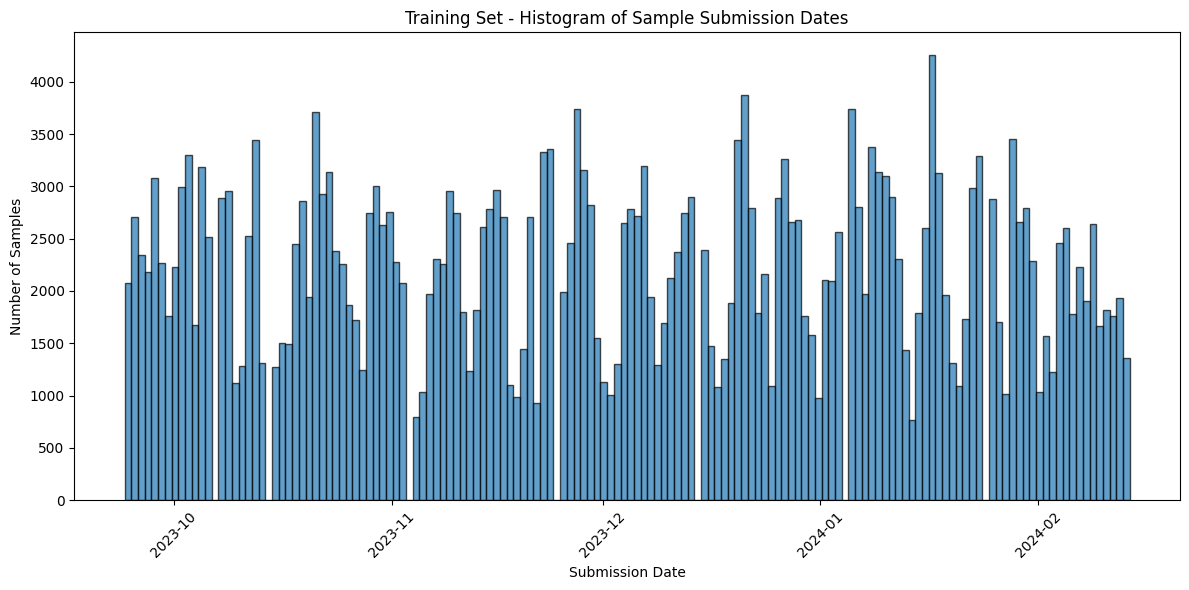

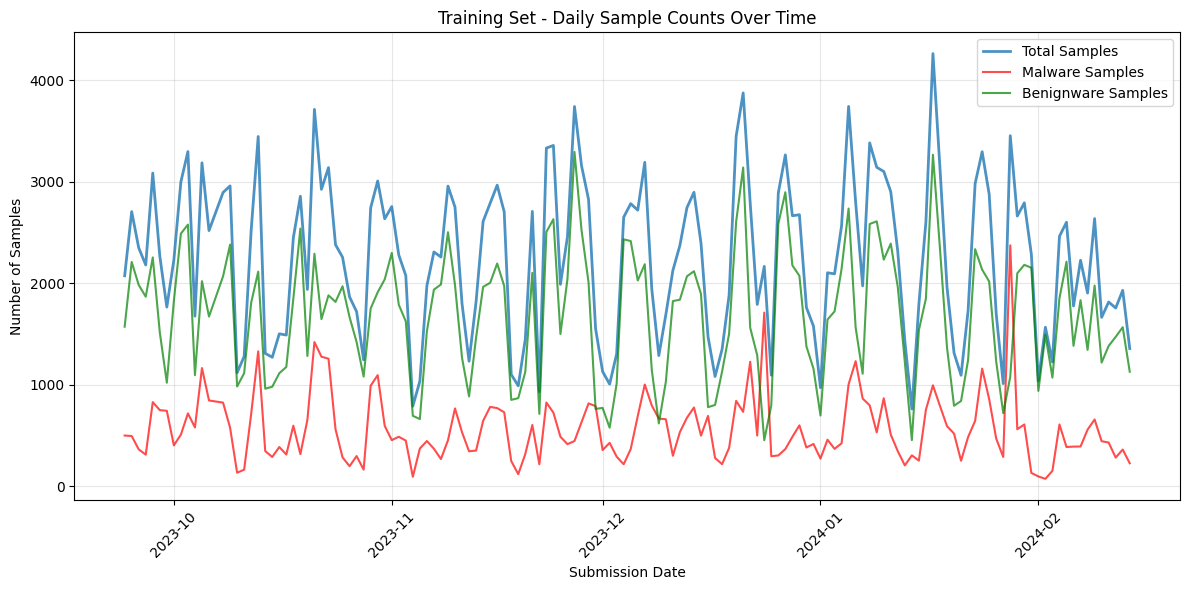

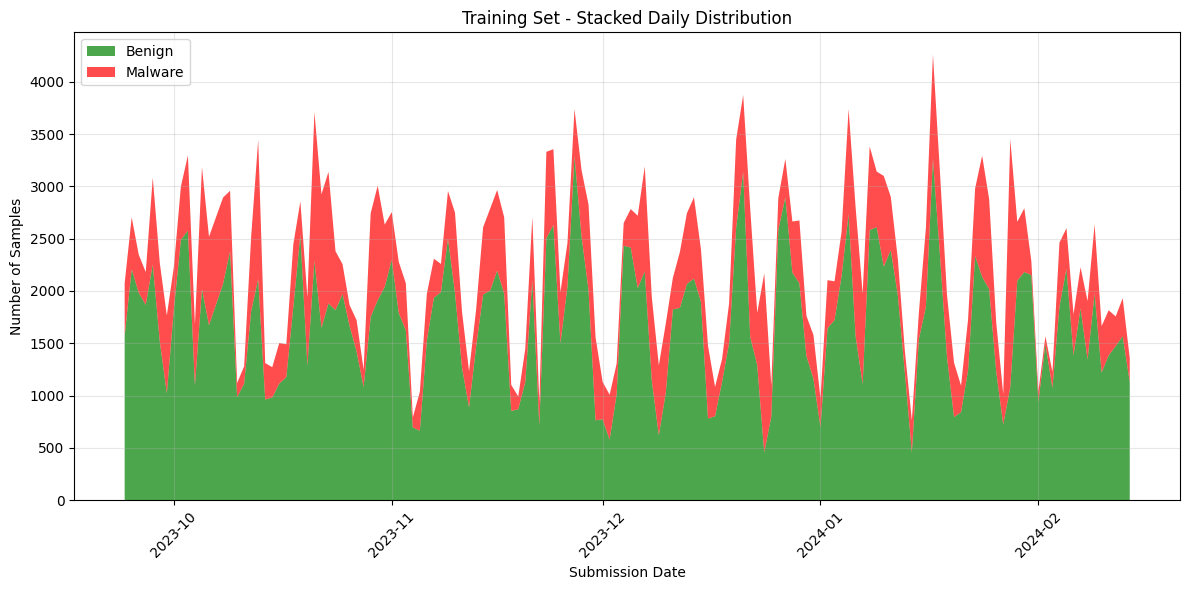


Validation Set Temporal Distribution:
Earliest: 2024-02-14.
Latest: 2024-02-28.
Span: 14 days.
Malware samples: 1925.
Benign samples: 19667.




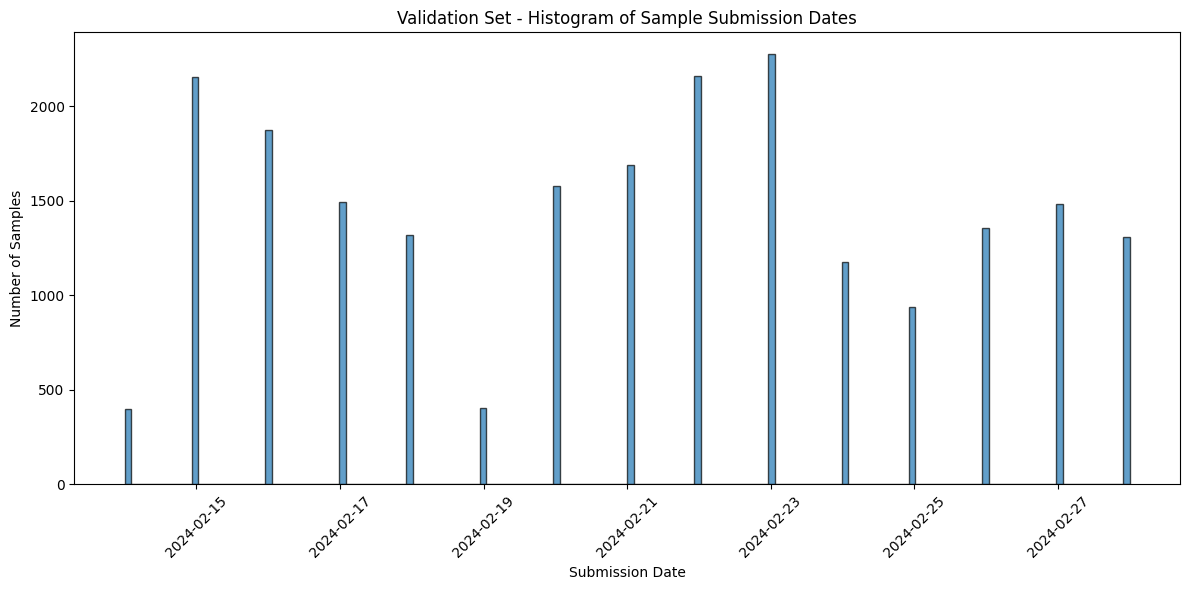

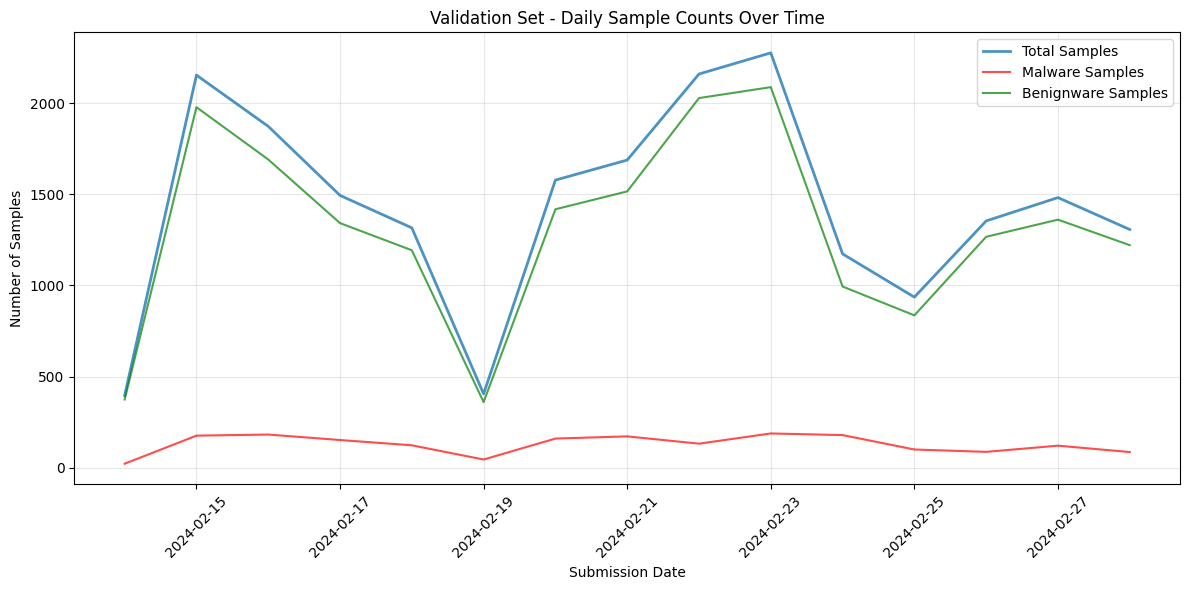

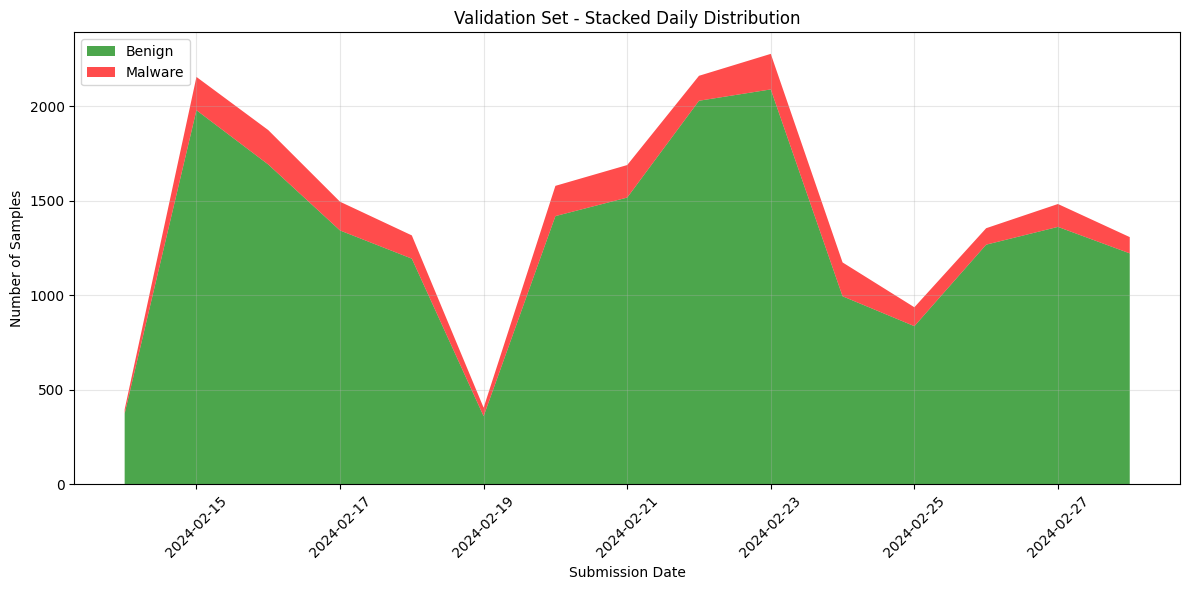


Strict Test Set Temporal Distribution:
Earliest: 2024-04-01.
Latest: 2024-06-29.
Span: 89 days.
Malware samples: 13935.
Benign samples: 149017.




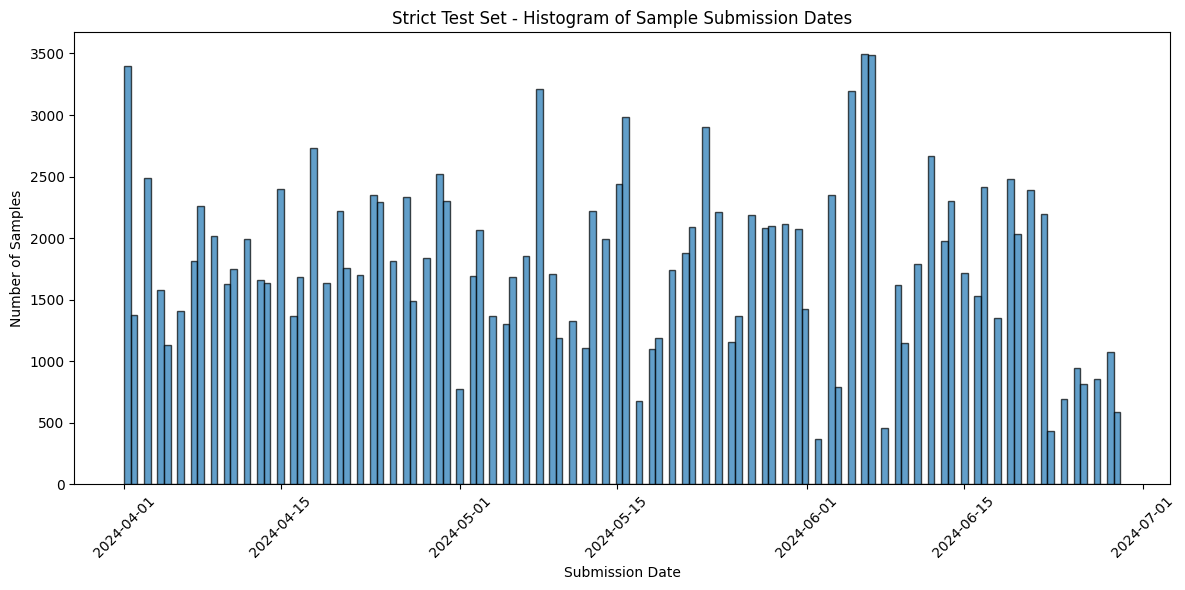

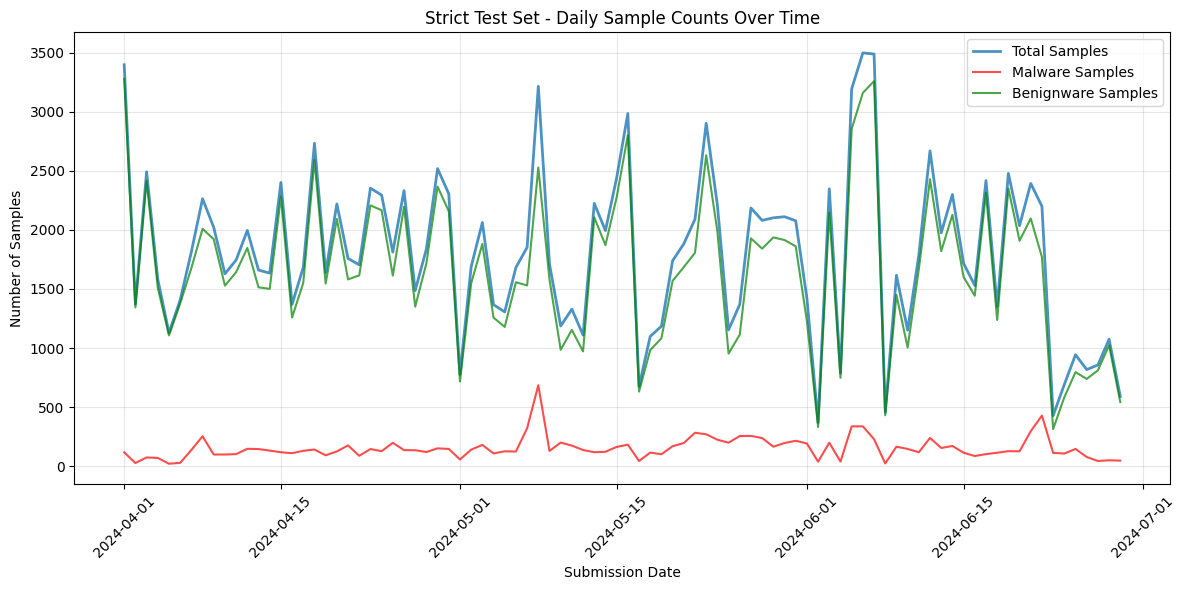

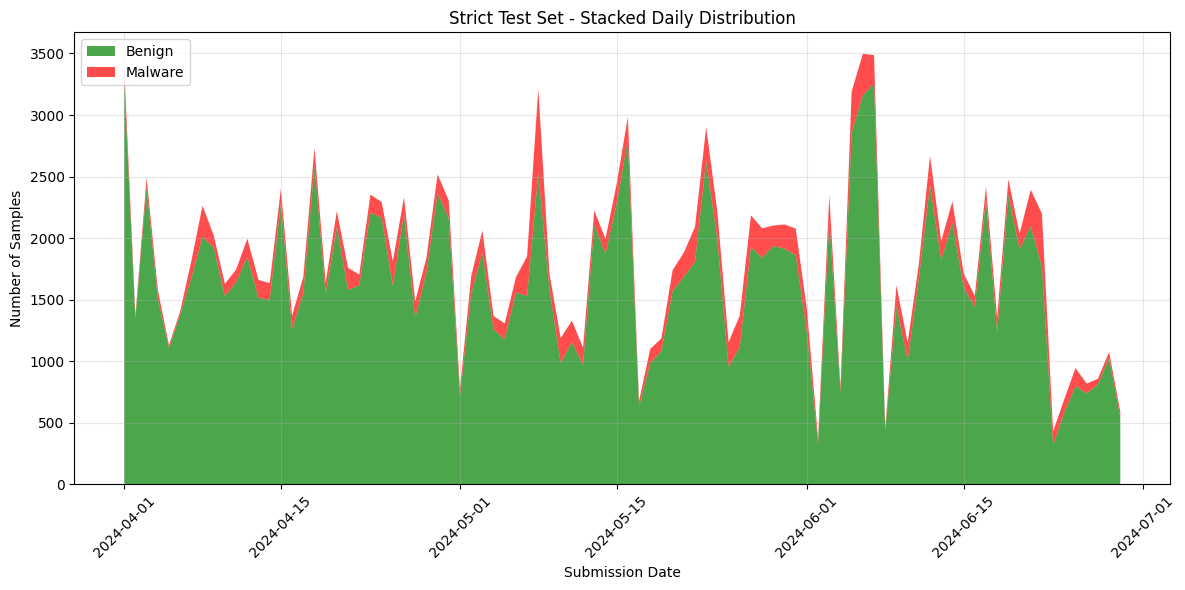

In [29]:
analyse_temporal_distribution(train_final, label="Training Set")
analyse_temporal_distribution(filtered_val, label="Validation Set")
analyse_temporal_distribution(filtered_test, label="Strict Test Set")

## <u>6. Normalize Imports</u>

In [9]:
def normalize_import_string(imp):
  """
  Standardize import strings to obtain a more consistent format and a smaller vocabulary
  (fewer unique tokens result in less sparse data and better generalization) with 'some'
  expansion. The following transformations take place:
    - Lowercase every character;
    - Remove common prefixes (_imp__, imp_ etc.);
    - Remove all numbers part of the DLL;
    - Remove DLL extensions;
    - Remove ordinal imports;
    - Handle mangled MSVC imports;
    - Handle mangled Borland / Delphi imports;
    - Remove multiple consecutive underscores;
    - Remove any other special characters (*, (, etc.);
  To prevent data leakage, all normalization operations are based on characters and patterns
  observed in the training set to enable proper coverage testing of the downstream tokenizer).

  Args:
    imp : The import string to be standardized.

  Returns:
    The standardized import string.
  """

  # Lowercase import string.
  imp = imp.lower()

  # Remove common prefixes added by disassemblers and compilers.
  imp = re.sub(r"^__imp__", "", imp)
  imp = re.sub(r"^__imp_", "", imp)
  imp = re.sub(r"^_imp__", "", imp)
  imp = re.sub(r"^_imp_", "", imp)
  imp = re.sub(r"^imp_", "", imp)

  # Remove the stdcall suffix (eg. CreateFileA@28).
  imp = re.sub(r"@\d+$", "", imp)

  # Remove .dll / .bpl / .sys / .ocx / .cpl extensions anywhere in the import string.
  imp = re.sub(r"\.dll\b", "", imp)
  imp = re.sub(r"\.bpl\b", "", imp)
  imp = re.sub(r"\.sys\b", "", imp)
  imp = re.sub(r"\.ocx\b", "", imp)
  imp = re.sub(r"\.cpl\b", "", imp)

  # Remove .acm / .ax / .efi / .mui extensions anywhere in the import string.
  imp = re.sub(r"\.acm\b", "", imp)
  imp = re.sub(r"\.ax\b", "", imp)
  imp = re.sub(r"\.efi\b", "", imp)
  imp = re.sub(r"\.mui\b", "", imp)

  # Remove &dll extension anywhere in the import string.
  imp = re.sub(r"&dll\b", "", imp)

  # Remove ! from anywhere in the import string.
  imp = re.sub(r"!", "", imp)

  # Remove any whitespaces.
  imp = re.sub(r"\s+", "", imp)

  # Replace multiple successive underscores (e.g. dll::p___argc) with one underscore.
  imp = re.sub(r"_{2,}", "_", imp)

  # Handle ordinal imports (e.g. kernel32::#123 => kernel32::ord_123).
  imp = re.sub(r"\#(\d+)$", r"ord_\1", imp)
  # Handle ordinal imports (e.g. mfc100u::ordinal9588 => mfc100u::ord_123).
  imp = re.sub(r"ordinal(\d+)$", r"ord_\1", imp)
  # Handle ordinal imports (e.g. cmmlib::0 => cmmlib::ord_0).
  imp = re.sub(r"::(\d+)$", r"::ord_\1", imp)

  dll, symbol = imp.split("::")

  # Check if the DLL name repeats (e.g. mfc100u::mfc100u:ordinal9850).
  if symbol.startswith(dll):
    # Remove both the repeated DLL as well as the : separator.
    symbol = symbol[len(dll) + 1:]
    imp = f"{dll}::{symbol}"

  # Remove ordinal imports and imports with empty functions.
  if symbol.startswith("ord_") or symbol == "":
    return None

  # Extract the readable base function name for mangled MSVC (after ::?).
  match = re.search(r"\?\w+", imp)
  if match:
    base_function = match.group()[1:]
    imp = re.sub(r"::\?.*$", f"::{base_function}", imp)

  # Handle Borland / Delphi symbols containing @ or $.
  if "@@" in imp or "@" in imp:
    dll, _, symbol = imp.partition("::")

    # Split on $ (the suffixes come after $).
    symbol = symbol.split("$", 1)[0]

    # Remove any trailing @'s.
    symbol = symbol.rstrip("@")

    # Split on @ and use the last element.
    symbol = symbol.split("@")[-1]

    imp = f"{dll}::{symbol}"

  dll, symbol = imp.split("::")

  # Handle API set DLLs (strip versions e.g. -l1-1-0).
  dll = re.sub(r"-l\d+(-\d+)*$", "", dll)

  # Remove trailing version numbers / build numbers (e.g. libpng-1.6.37 => libpng).
  dll = re.sub(r"[-_.]*\d+(?:[-_.]\d+)*[a-z]*$", "", dll)

  # Remove leading or trailing underscores from the function.
  symbol = symbol.strip("_")

  # Remove the trailing A / W in the function name (these are now lowercased).
  symbol = re.sub(r"([a-zA-Z0-9]+)[AW]$", r"\1", symbol, flags=re.IGNORECASE)

  imp = f"{dll}::{symbol}"

  # Replace dashes with underscores.
  imp = re.sub(r"[-\.]", "_", imp)

  # Replace any remaining $ with s. Debatable.
  imp = re.sub(r"\$", "s", imp)

  # Remove any remaining &.
  imp = re.sub(r"&", "", imp)

  # Remove parenthesis () from anywhere in the import string.
  imp = re.sub(r"[()]", "", imp)

  # Remove * from anywhere in the import string.
  imp = re.sub(r"\*", "", imp)

  # Remove + from anywhere in the import string.
  imp = re.sub(r"\+", "", imp)

  # Remove / from anywhere in the import string.
  imp = re.sub(r"/", "", imp)

  # Remove ? from anywhere in the import string.
  imp = re.sub(r"\?", "", imp)

  # Remove @ from anywhere in the import string.
  imp = re.sub(r"@", "", imp)

  # Replace :\ with underscores.
  imp = re.sub(r":\\", "_", imp)

  # Replace \ with underscores.
  imp = re.sub(r"\\", "_", imp)

  # Remove curly braces from anywhere in the import string.
  imp = re.sub(r"\{|\}", "", imp)

  # Remove trailing or leading underscores in the import.
  imp = imp.strip("_")

  # Remove any trailling or leading colons.
  imp = re.sub(r":+$", "", imp)
  imp = re.sub(r"^:+", "", imp)

  # Replace : that are not part of a :: (i.e. not preceded or followed by :) with underscores.
  imp = re.sub(r"(?<!:):(?!\:)", "_", imp)

  # Remove any , anywhere in the import.
  imp = re.sub(r",", "", imp)

  # Remove any % anywhere in the import.
  imp = re.sub(r"%", "", imp)

  # Remove any [, ] from anywhere in the import.
  imp = re.sub(r"\[|\]", "", imp)

  # Remove any ; from anywhere in the import.
  imp = re.sub(r";", "", imp)

  # Remove imports that may have become invalid after filtering.
  if not imp or imp == ".":
    return None

  return imp


def normalize_dataset(dataset, min_imports_len, max_imports_len):
  """
  Standardize (as described above) all samples in a dataset in place. Remove all samples
  that fail any of the following conditions:
    - Have no imports left after standardization;
    - Have not enough imports left after standardization (< min_imports_len).
    - Have too many imports left after standardization (> max_imports_len).
  Regarding the last condition, the maximum imports length becomes a hyperparameter. Use
  the 95th percentile etc. to determine the optimal value (or allow all lengths?).

  Args:
    dataset         : The dataset to be standardized (as a DataFrame).
    min_imports_len : The minimum number of imports a sample must have after standardization.
    max_imports_len : The maximum number of imports a sample can contain.

  Returns:
    None
  """

  print(f"Normalizing import strings...")
  print("=" * 60)

  initial_count = len(dataset)

  dataset["imports"] = [
    [
      std_imp for imp in imports_list
      # Only call the normalization function once.
      if (std_imp := normalize_import_string(imp))
    ]
    for imports_list in tqdm(dataset["imports"].values, desc="Normalizing...")
  ]

  # Filter the samples by length constraints.
  import_lengths = dataset["imports"].str.len()

  # Create a mask for samples to be removed.
  remove_mask = (
    (import_lengths < min_imports_len) |
    (import_lengths > max_imports_len) |
    (import_lengths == 0)
  )

  # Get the indices of samples to be dropped.
  indices_to_remove = dataset[remove_mask].index

  # Drop and reset index in place.
  dataset.drop(indices_to_remove, inplace=True)
  dataset.reset_index(drop=True, inplace=True)

  removed_count = initial_count - len(dataset)

  print(f"Removed {removed_count} samples during normalization.")
  print("=" * 60)

In [10]:
print(normalize_import_string("xmlrtl270::@xml@win@msxmldom@tmsxmldomdocumentfactory@$bcctr$qqrv"))
print(normalize_import_string("plugin_api.dll::?set_response_bad@functions@protobuf@nscapi@@YAX"))
print(normalize_import_string("vclimg270::@vcl@imaging@gifimg@finalization$qqrv"))
print(normalize_import_string("vcl50::@mtx@__initialization$qqrv"))
print(normalize_import_string("mfc100u::mfc100u:ordinal9588"))
print(normalize_import_string("mfc90u::mfc90u:ordinal2447"))
print(normalize_import_string("msvbvm60::__vbavarmove"))
print(normalize_import_string("dll::0"))
print(normalize_import_string("kernel32::ordinal100"))
print(normalize_import_string("kernel32::ord_10"))
print(normalize_import_string("rtl270::"))
print(normalize_import_string("kernel32::createfilew"))
print(normalize_import_string("libgdbm-6::function"))
print(normalize_import_string("libpng-1.6.37::function"))
print(normalize_import_string("api-ms-win-core-sysinfo-l1-1-0::getsystemtimeasfiletime"))
print(normalize_import_string("mfc90u::mfc90u:function"))
print(normalize_import_string("kernel32::getpatha"))
print(normalize_import_string("api_ms_win_crt_runtime::p___argc"))
print(normalize_import_string("msvcp::1"))
print(normalize_import_string("libc++::function"))
print(normalize_import_string("ql/core::function"))
print(normalize_import_string("wcmdpa::w?$ran(rnx$wstring$$pna)i"))
print(normalize_import_string("{ql/core::function}"))
print(normalize_import_string("{api\\example\\bla::function}"))
print(normalize_import_string("dwutility::2"))
print(normalize_import_string("c:\\windows\\system32\\netapi::netserverenum"))
print(normalize_import_string("\\drake22\\ptr\\library::messagewithlinkback"))
print(normalize_import_string("\\drake22\\ptr\\library::message\\withlinkback"))
print(normalize_import_string("c:\\windows\\system32\\net:api::netserverenum"))
print(normalize_import_string("c:\\win%dows\\system32\\net:api::netserverenum,"))
print(normalize_import_string("c:\\win%dows\\sys]tem32\\net:api::netservere[num:"))

xmlrtl::tmsxmldomdocumentfactory
plugin_api::set_response_bad
vclimg::finalization
vcl::initialization
None
None
msvbvm::vbavarmove
None
None
None
None
kernel::createfile
libgdbm::function
libpng::function
api_ms_win_core_sysinfo::getsystemtimeasfiletime
mfc::function
kernel::getpath
api_ms_win_crt_runtime::p_argc
None
libc::function
qlcore::function
wcmdpa::wsranrnxswstringsspnai
qlcore::function
api_example_bla::function
None
c_windows_system32_netapi::netserverenum
drake22_ptr_library::messagewithlinkback
drake22_ptr_library::message_withlinkback
c_windows_system32_net_api::netserverenum
c_windows_system32_net_api::netserverenum
c_windows_system32_net_api::netserverenum


In [31]:
normalize_dataset(train_final, min_imports_len=5, max_imports_len=512)
normalize_dataset(filtered_val, min_imports_len=5, max_imports_len=512)
normalize_dataset(filtered_test, min_imports_len=5, max_imports_len=512)

Normalizing import strings...


Normalizing...:   0%|          | 0/321831 [00:00<?, ?it/s]

Removed 12057 samples during normalization.
Normalizing import strings...


Normalizing...:   0%|          | 0/21592 [00:00<?, ?it/s]

Removed 722 samples during normalization.
Normalizing import strings...


Normalizing...:   0%|          | 0/162952 [00:00<?, ?it/s]

Removed 4292 samples during normalization.


In [35]:
# Print how a sample looks like post-normalization.
print(f"Post-Normalization Sample")
print("=" * 60)

example = train_final.iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']} ({'malware' if example['label'] == 1 else 'benign'})")
print(f"Timestamp: {example['first_submission']}")
print(f"Family: {example['family']}")
print(f"Number of imports: {len(example['imports'])}")
print(f"First 10 imports: {example['imports'][:10]}")
print("=" * 60)

example = filtered_val.iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']} ({'malware' if example['label'] == 1 else 'benign'})")
print(f"Timestamp: {example['first_submission']}")
print(f"Family: {example['family']}")
print(f"Number of imports: {len(example['imports'])}")
print(f"First 10 imports: {example['imports'][:10]}")
print("=" * 60)

example = filtered_test.iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']} ({'malware' if example['label'] == 1 else 'benign'})")
print(f"Timestamp: {example['first_submission']}")
print(f"Family: {example['family']}")
print(f"Number of imports: {len(example['imports'])}")
print(f"First 10 imports: {example['imports'][:10]}")
print("=" * 60)

Post-Normalization Sample
SHA256: e19016cdc028554c...
Label: 0 (benign)
Timestamp: 2023-09-24 00:00:00
Family: None
Number of imports: 68
First 2 imports: ['msys_ncursesw::sp', 'msys_ncursesw::nc_screen_of']


## <u>7. Analyse Import Sequences Length Distribution</u>

In [11]:
def analyse_import_length_distribution(dataset, percentile=95):
  """
  Analyze the distribution of import sequence lengths in a dataset and determine a
  maximum length based on a given percentile.

  Args:
    dataset     : A DataFrame with an imports column (already normalized).
    percentile  : The percentile to use for determining the recommended maximum length.

  Returns:
    The recommended maximum sequence length.
  """

  print(f"Analyzing import sequence length distribution...")
  print("=" * 60)

  # Calculate the length of the import sequence for each sample.
  import_lengths = dataset["imports"].str.len()

  # Print descriptive statistics for the import lengths.
  display(import_lengths.describe())

  # Calculate the recommended maximum length based on the specified percentile.
  recommended_max_length = int(np.percentile(import_lengths, percentile))

  # Plot a histogram of the import lengths.
  plt.figure(figsize=(12, 6))
  plt.hist(import_lengths, bins=100, edgecolor="black", alpha=0.7)
  plt.axvline(recommended_max_length, color="red", linestyle="dashed", linewidth=2, label=f"{percentile}th Percentile ({recommended_max_length})")
  plt.title("Distribution of Import Sequence Lengths")
  plt.xlabel("Number of Imports")
  plt.ylabel("Number of Samples")
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

  print(f"\nRecommended maximum sequence length ({percentile}th percentile): {recommended_max_length}.")
  print("=" * 60)

  return recommended_max_length

Analyzing import sequence length distribution...


count    309774.000000
mean        168.700892
std         142.640151
min           5.000000
25%          65.000000
50%         131.000000
75%         215.000000
max         512.000000
Name: imports, dtype: float64

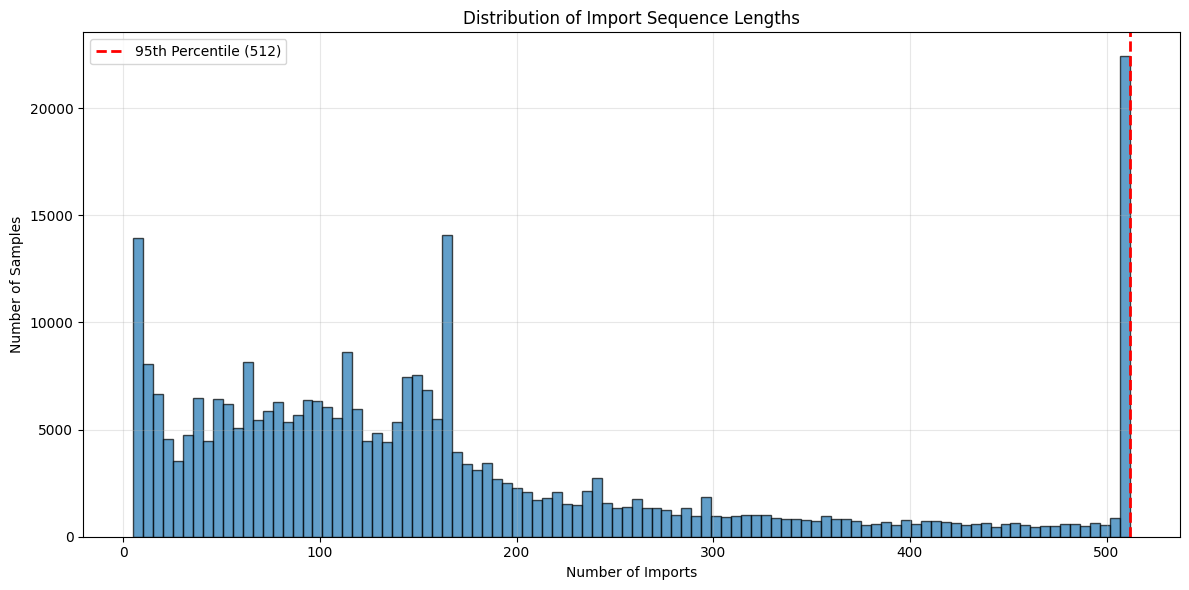


Recommended maximum sequence length (95th percentile): 512.
Analyzing import sequence length distribution...


count    20870.000000
mean       184.937470
std        148.490473
min          5.000000
25%         73.000000
50%        144.000000
75%        246.000000
max        512.000000
Name: imports, dtype: float64

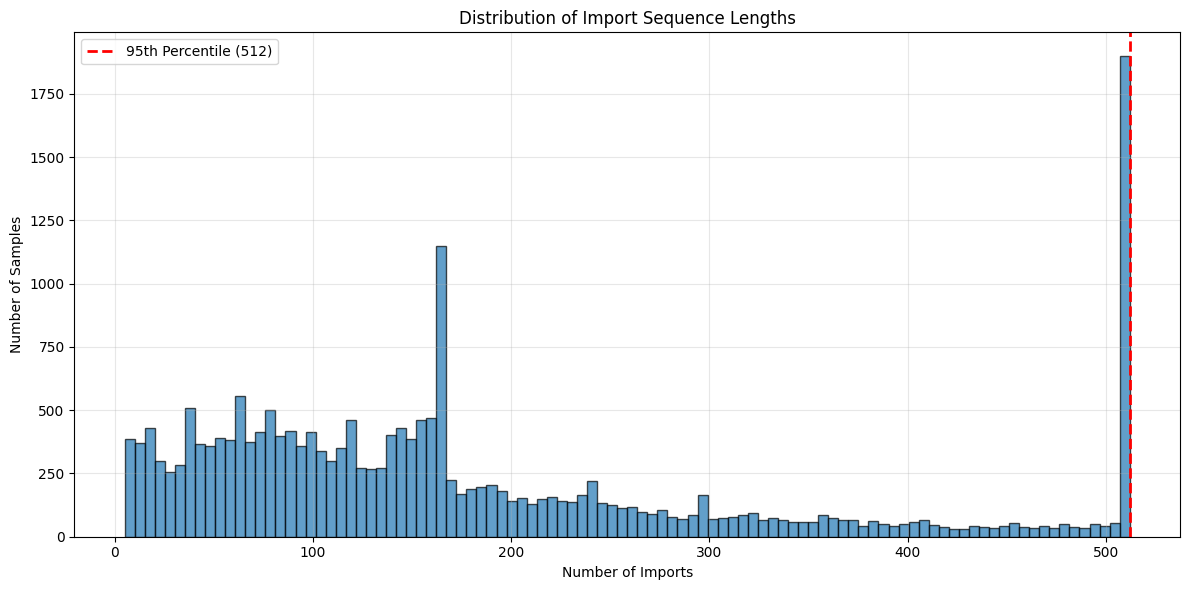


Recommended maximum sequence length (95th percentile): 512.
Analyzing import sequence length distribution...


count    158660.000000
mean        181.770339
std         142.588010
min           5.000000
25%          78.000000
50%         145.000000
75%         238.000000
max         512.000000
Name: imports, dtype: float64

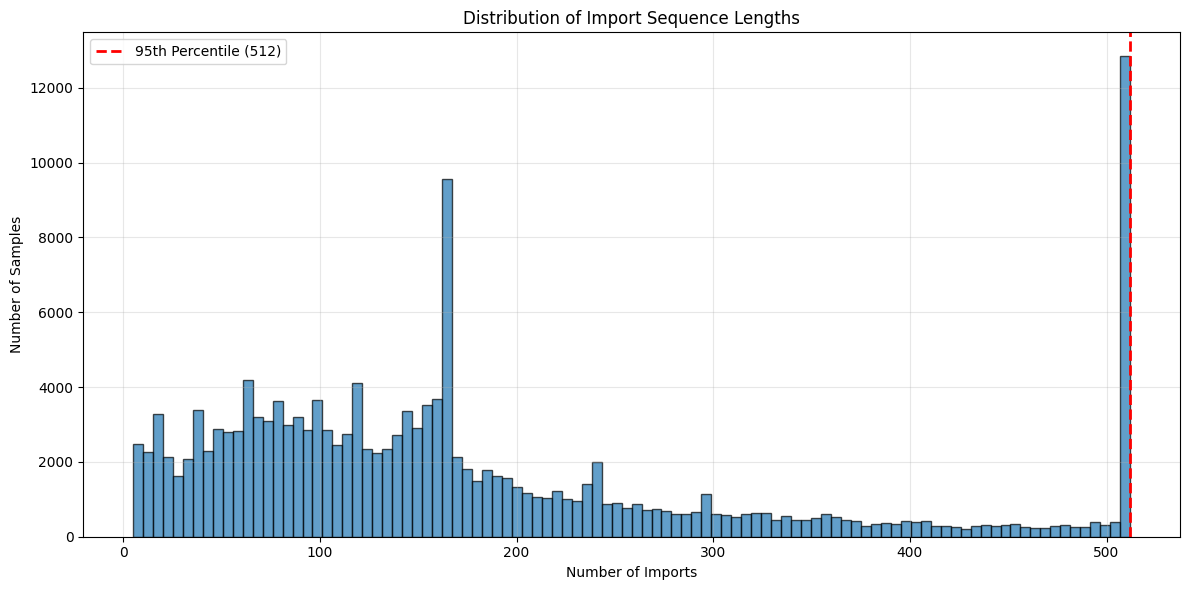


Recommended maximum sequence length (95th percentile): 512.


In [37]:
recommended_max_length = analyse_import_length_distribution(train_final, percentile=95)
recommended_max_length = analyse_import_length_distribution(filtered_val, percentile=95)
recommended_max_length = analyse_import_length_distribution(filtered_test, percentile=95)

## <u>8. Post-Normalization Split Temporal Analysis</u>

Post-Normalization Split Analysis
Training samples after normalization: 309774
Validation samples after normalization: 20870
Test samples after normalization: 158660
Normalized import examples:
First 5 imports: ['msys_ncursesw::sp', 'msys_ncursesw::nc_screen_of', 'msys_ncursesw::nc_wcrtomb', 'msys_ncursesw::copywin', 'msys_ncursesw::delwin']
Percentage of malware samples in the training set after normalization: 25.15%.
Percentage of malware samples in the validation set after normalization: 8.64%.
Percentage of malware samples in the test set after normalization: 8.24%.

Normalized Training Set Temporal Distribution:
Earliest: 2023-09-24.
Latest: 2024-02-14.
Span: 143 days.
Malware samples: 77907.
Benign samples: 231867.




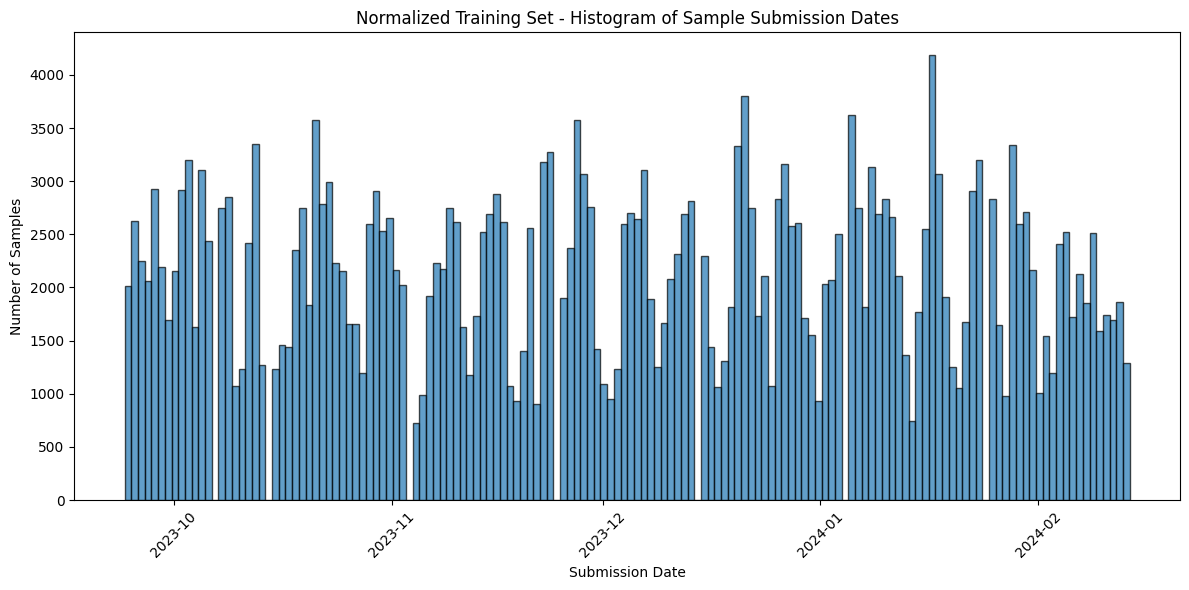

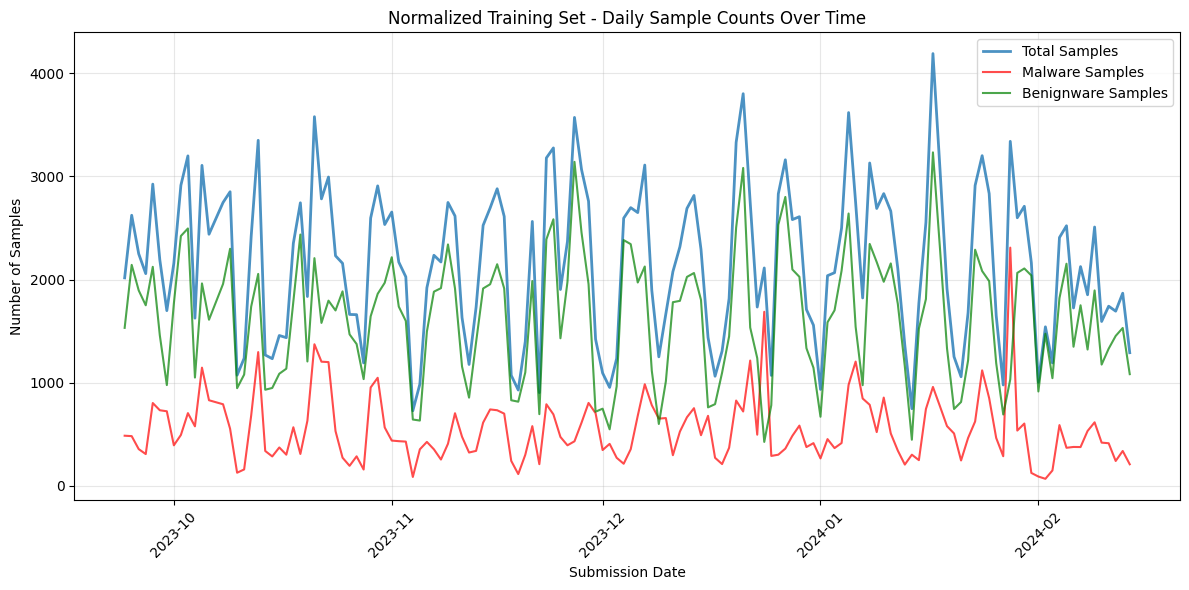

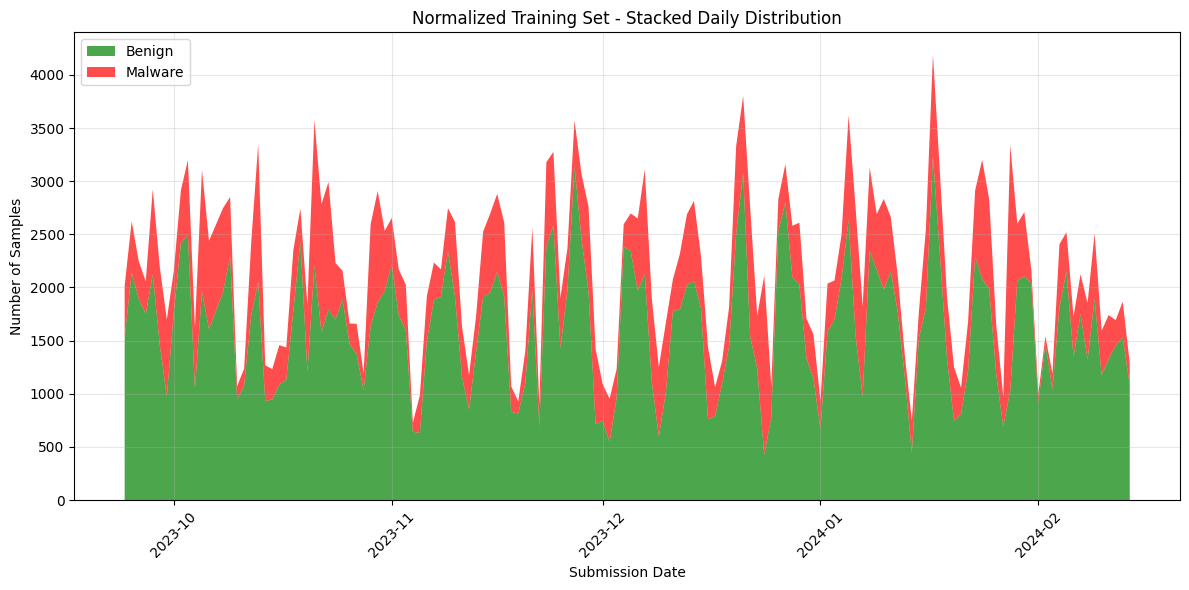


Normalized Validation Set Temporal Distribution:
Earliest: 2024-02-14.
Latest: 2024-02-28.
Span: 14 days.
Malware samples: 1804.
Benign samples: 19066.




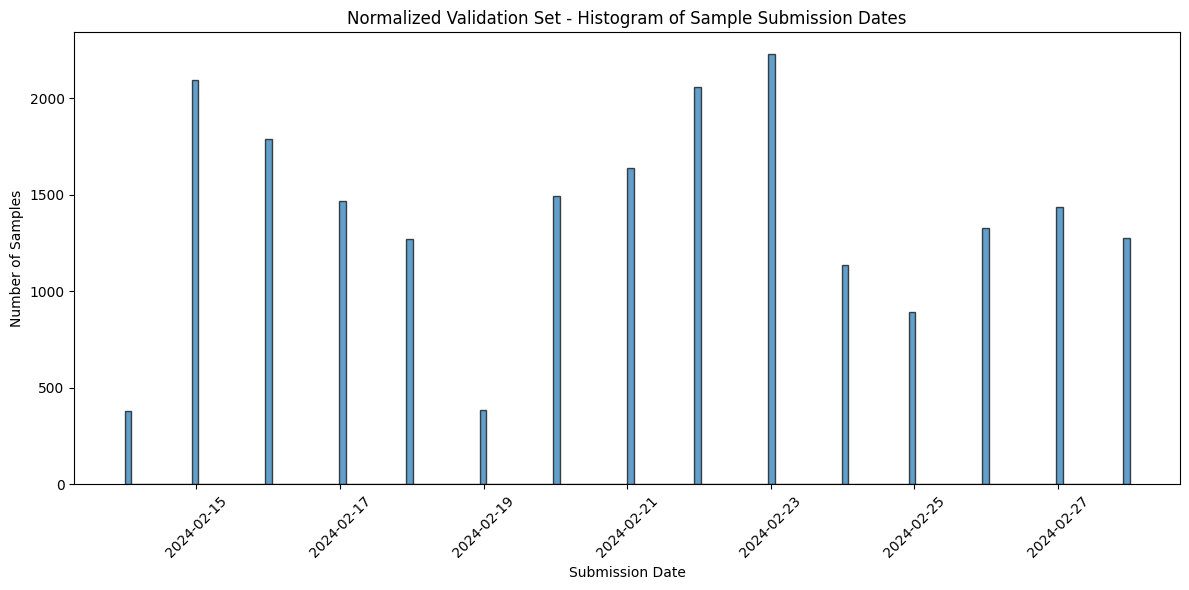

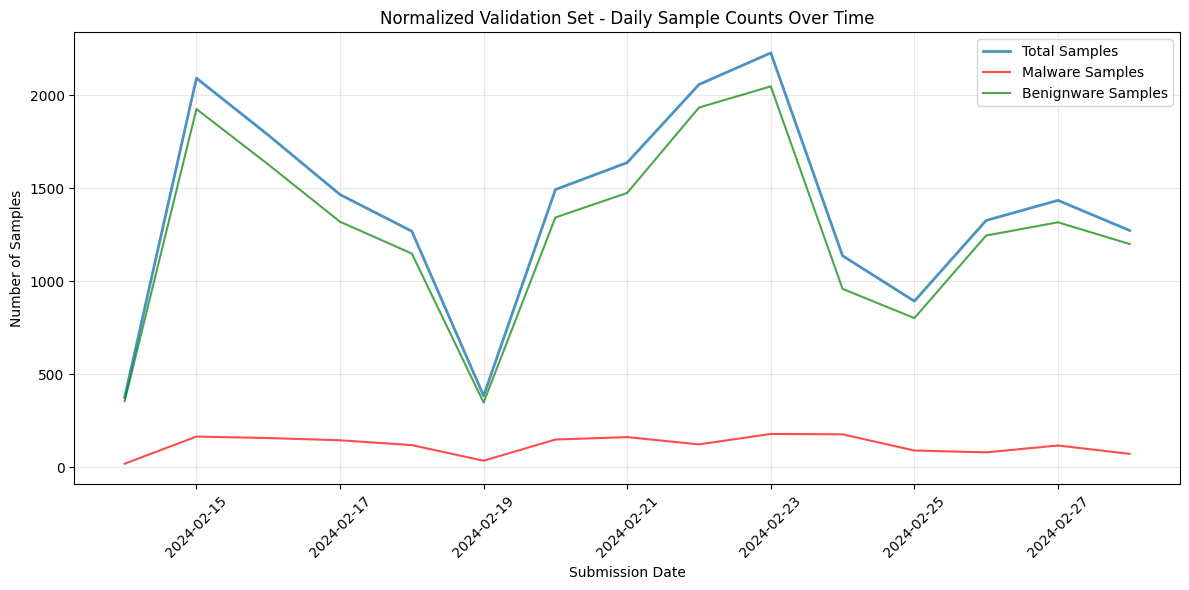

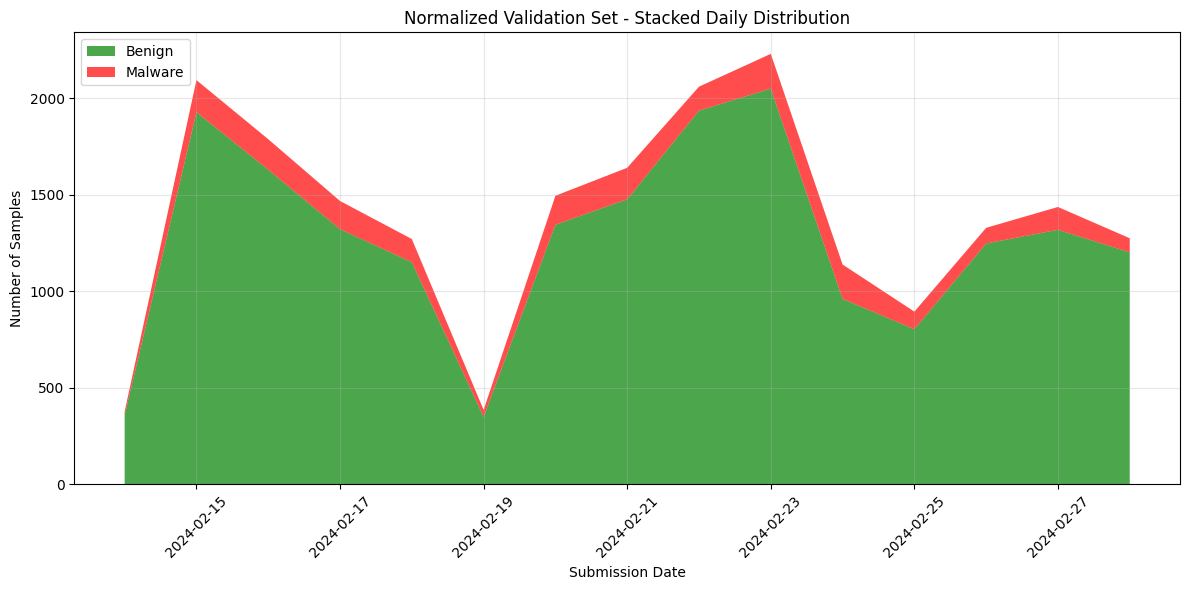


Normalized Strict Test Set Temporal Distribution:
Earliest: 2024-04-01.
Latest: 2024-06-29.
Span: 89 days.
Malware samples: 13071.
Benign samples: 145589.




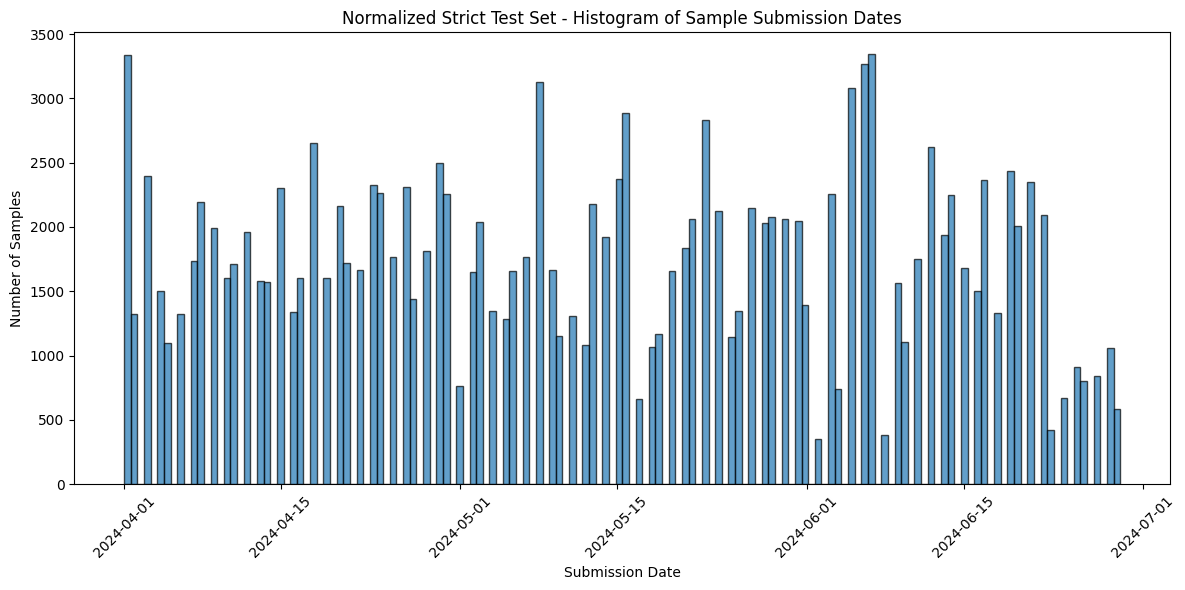

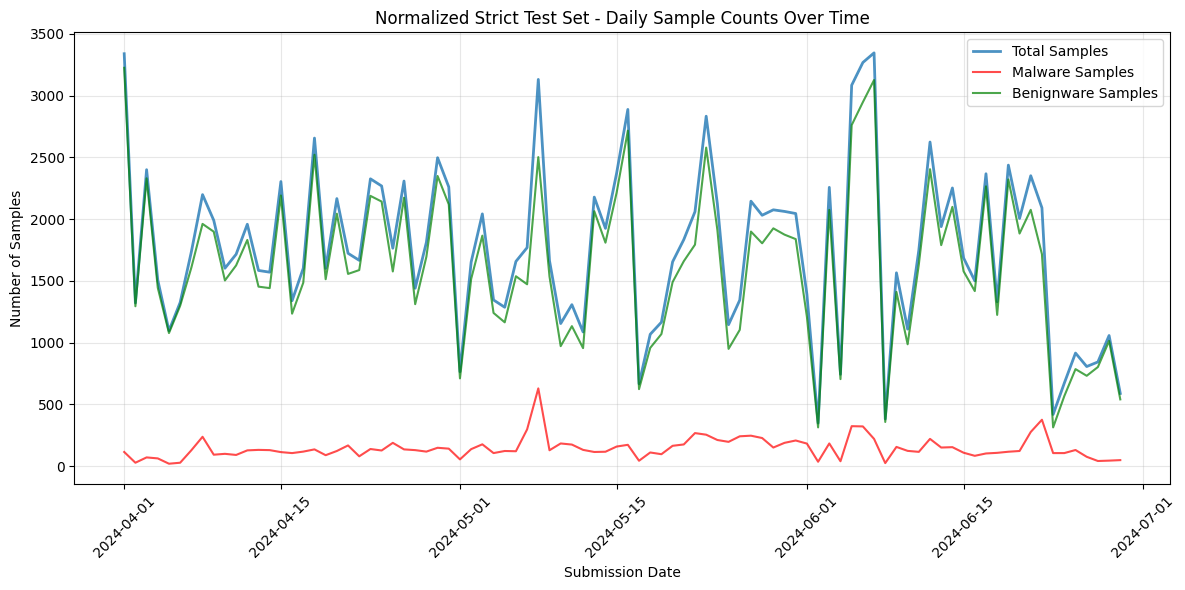

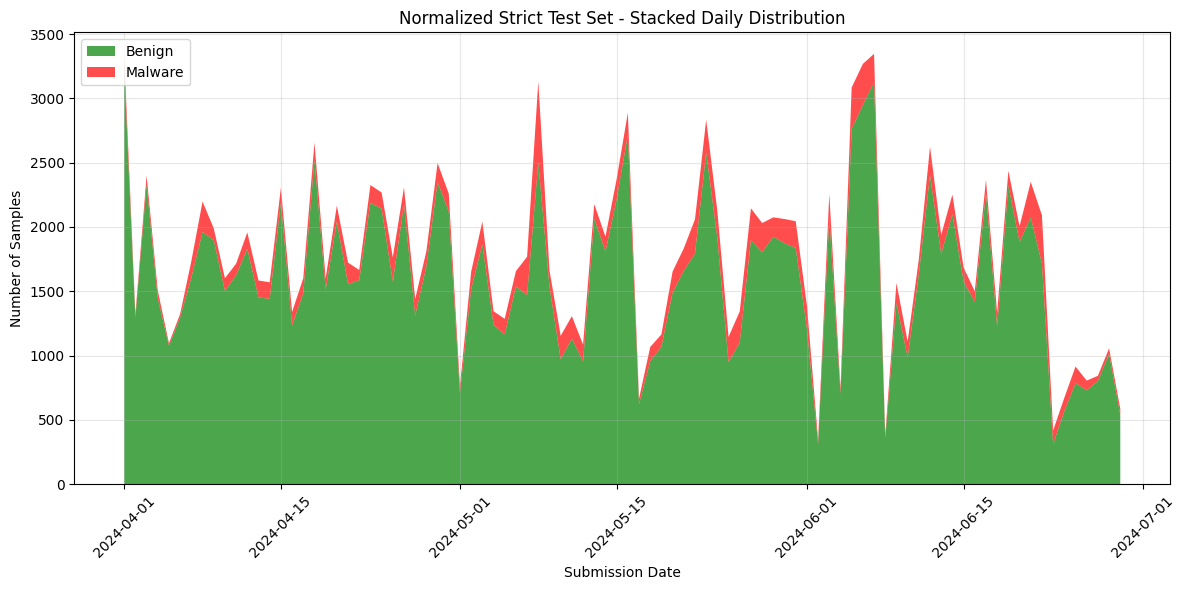

In [38]:
print("Post-Normalization Split Analysis")
print("=" * 60)
print(f"Training samples after normalization: {len(train_final)}")
print(f"Validation samples after normalization: {len(filtered_val)}")
print(f"Test samples after normalization: {len(filtered_test)}")
print(f"Normalized import examples:")
print(f"First 10 imports: {train_final.iloc[0]['imports'][:10]}")

# Check the malware percentage in the final train, val and test sets after normalization.
train_malware_count = sum(1 for sample in train_final.to_dict("records") if sample["label"] == 1)
train_ratio = train_malware_count / len(train_final)

val_malware_count = sum(1 for sample in filtered_val.to_dict("records") if sample["label"] == 1)
val_ratio = val_malware_count / len(filtered_val)

test_malware_count = sum(1 for sample in filtered_test.to_dict("records") if sample["label"] == 1)
test_ratio = test_malware_count / len(filtered_test)

print(f"Percentage of malware samples in the training set after normalization: {train_ratio * 100:.2f}%.")
print(f"Percentage of malware samples in the validation set after normalization: {val_ratio * 100:.2f}%.")
print(f"Percentage of malware samples in the test set after normalization: {test_ratio * 100:.2f}%.")
print("=" * 60)

# Save the normalized sets to separate JSONL files.
save_dataframe_to_jsonl(train_final, "/content/drive/MyDrive/train_normalized.jsonl")
save_dataframe_to_jsonl(filtered_val, "/content/drive/MyDrive/val_normalized.jsonl")
save_dataframe_to_jsonl(filtered_test, "/content/drive/MyDrive/test_normalized.jsonl")

# Generate temporal analysis plots for the normalized sets.
analyse_temporal_distribution(train_final, label="Normalized Training Set")
analyse_temporal_distribution(filtered_val, label="Normalized Validation Set")
analyse_temporal_distribution(filtered_test, label="Normalized Strict Test Set")

## <u>9. BPE Import Tokenizer</u>

In [51]:
# Get the imports column (a Series of lists) and then flatten it.
all_imports = [imp for imports_list in train_final["imports"] for imp in imports_list]

# Determine all unique imports.
unique_imports = set(all_imports)

print(f"Import Statistics:")
print("=" * 60)
print(f"Total import occurrences: {len(all_imports)}.")
print(f"Unique imports: {len(unique_imports)}.")
print(f"Average number of imports per sample: {len(all_imports) / len(train_final):.2f}.")
print("=" * 60)

Import Statistics:
Total import occurrences: 52259150.
Unique imports: 1386933.
Average number of imports per sample: 168.70.


In [64]:
def prepare_tokens_for_analysis(dataset):
  sequences = []

  for _, sample_series in dataset.iterrows():
    tokens = []

    for imp in sample_series["imports"]:
      if "::" in imp:
        dll, symbol = imp.split("::", 1)

        # Split the DLL based by underscore.
        dll_parts = dll.split("_")
        # Add each part as a separate token.
        tokens.extend(dll_parts)

        # Split the function by underscore.
        symbol_parts = symbol.split("_")
        # Add each part as a separate token.
        tokens.extend(symbol_parts)
      else:
        tokens.extend(imp.split("_"))

    sequences.append(" ".join(tokens))

  return sequences

# Generate the training sequences.
training_sequences = prepare_tokens_for_analysis(train_final)

# Collect all unique characters from the training sequences.
all_characters = set("".join(training_sequences))

print(f"Unique characters in training sequences: {sorted(list(all_characters))}")

Unique characters in training sequences: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [12]:
def train_import_tokenizer(
  dataset,
  vocab_size=5000,
  min_frequency=2,
  max_tokens_len=512
):
  """
  Train a Byte Pair Encoding tokenizer on import sequences. Split on :: and underscores.

  Args:
    dataset         : Samples containing between 5 and 512 imports (already normalized).
    vocab_size      : The size of the vocabulary (5000 by default).
    min_freq        : The min frequency for an import to be in the vocabulary (2 by default).
    max_tokens_len  : The maximum number of tokens in a sequence (512 by default).

  Returns:
    The trained BPE tokenizer.
  """

  print(f"Training BPE tokenizer with {vocab_size} tokens...")
  print("=" * 60)

  def prepare_tokens(dataset):
    sequences = []

    for _, sample_series in dataset.iterrows():
      tokens = []

      for imp in sample_series["imports"]:
        # Split the import on :: (also removes ::).
        if "::" in imp:
          dll, symbol = imp.split("::", 1)

          # Split the DLL based by underscore.
          dll_parts = dll.split("_")
          # Add each part as a separate token.
          tokens.extend(dll_parts)

          # Split the function by underscore.
          symbol_parts = symbol.split("_")
          # Add each part as a separate token.
          tokens.extend(symbol_parts)

        else:
          # In case of malformed imports try splitting on underscores.
          tokens.extend(imp.split("_"))

      sequences.append(" ".join(tokens))

    return sequences

  sequences = prepare_tokens(dataset)

  # Initialize the BPE tokenizer (using [UNK] as the unknown symbol).
  tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

  tokenizer.normalizer = normalizers.Sequence([
    normalizers.NFD(),
    normalizers.Lowercase(),
    normalizers.StripAccents()
  ])

  tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    pre_tokenizers.Whitespace()
  ])

  # Define the special tokens (including import specific ones) to be used.
  special_tokens = [
    "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"
  ]

  trainer = trainers.BpeTrainer(
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    special_tokens=special_tokens,
    show_progress=True
  )

  print(f"Example sequences: {sequences[0][:100]}")

  # Train the tokenizer on the import 'sentences'.
  tokenizer.train_from_iterator(sequences, trainer)

  # Use post-processor for BERT-style formatting.
  tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
      ("[CLS]", tokenizer.token_to_id("[CLS]")),
      ("[SEP]", tokenizer.token_to_id("[SEP]")),
    ]
  )

  # Enable import sequence padding.
  tokenizer.enable_padding(
    pad_id=tokenizer.token_to_id("[PAD]"),
    pad_token="[PAD]"
  )

  # Enable truncation for the sequence of tokens (larger than the 512 sequence of imports =>
  # less than the previously established max of 512 imports per sample). When determining the
  # compression ratio of the tokenizer, disable truncation (else, truncation may present expansion
  # as compression. See Section 11.).
  tokenizer.enable_truncation(max_length=max_tokens_len)

  print(f"Tokenizer vocabulary size: {tokenizer.get_vocab_size()}.")
  print("=" * 60)

  return tokenizer

In [11]:
# Load the datasets from their respective JSONL files.
train_final = load_jsonl_to_dataframe("/content/drive/MyDrive/train_normalized.jsonl")
filtered_val = load_jsonl_to_dataframe("/content/drive/MyDrive/val_normalized.jsonl")
filtered_test = load_jsonl_to_dataframe("/content/drive/MyDrive/test_normalized.jsonl")

In [18]:
# Train the tokenizer.
import_tokenizer = train_import_tokenizer(
  train_final,
  vocab_size=16000,
  min_frequency=2,
  # 512 represents the 72 percentile of training token sequence lengths
  max_tokens_len=512
)

vocab = import_tokenizer.get_vocab()
print(f"\nVocabulary Analysis:")
print("=" * 60)
print(f"Total tokens: {len(vocab)}")

# Show some sample tokens to make sure they are actual subwords.
sample_tokens = [k for k in vocab.keys() if len(k) > 2 and not k.startswith("[")][:20]
print(f"Sample tokens: {sample_tokens}")

# Check for common malware-related subwords.
malware_subwords = [
  "crypt",
  "hook",
  "inject",
  "virtual",
  "process",
  "thread",
  "debug"
]

found_subwords = []
for subword in malware_subwords:
  matching = [k for k in vocab.keys() if subword in k.lower()]
  if matching:
    # Use only a subset of the matching tokens.
    found_subwords.extend(matching[:3])

print(f"Total malware-relevant subwords found: {len(found_subwords)}.")
print(f"Malware-relevant subwords found: {found_subwords[:15]}")

# Save the tokenizer to a JSON file.
tokenizer_path = "/content/drive/MyDrive/import_tokenizer.json"
import_tokenizer.save(tokenizer_path)

print(f"The import tokenizer has been saved to: {tokenizer_path}.")
print("=" * 60)

Training BPE tokenizer with 16000 tokens...
Example sequences: msys ncursesw sp msys ncursesw nc screen of msys ncursesw nc wcrtomb msys ncursesw copywin msys ncur
Tokenizer vocabulary size: 16000.

Vocabulary Analysis:
Total tokens: 16000
Sample tokens: ['zn5clang', 'main', 'title', 'utowner', 'ffecti', 'setpen', 'signale', 'lproxy', 'configcenter', 'newinstance', 'tdbx', 'oninitdialog', 'tttlib', 'uid', 'invalidate', 'handler3', 'wnetcancel', 'mat', 'mount', 'tutil']
Total malware-relevant subwords found: 19
Malware-relevant subwords found: ['cryptgetuserkey', 'cryptdecodeobjectex', 'crypthash', 'setwindowshookex', 'failurehook', 'wineventhook', 'inject', 'wtsvirtualchannelpurgeinput', 'virtualmemory', 'mapvirtualkey', 'getprocessheap', 'processtojobobject', 'processidto', 'getthreadpreferreduilanguages', 'codethread']
The import tokenizer has been saved to: /content/drive/MyDrive/import_tokenizer.json.


In [8]:
# # Checkpoint 1.

# if "import_tokenizer" not in globals():
#   print("Loading the import tokenizer and normalized sets...")
#   print("=" * 60)

#   # Load the import tokenizer from the file.
#   tokenizer_path = "/content/drive/MyDrive/import_tokenizer.json"
#   import_tokenizer = Tokenizer.from_file(tokenizer_path)

#   # Load the normalized sets from the JSONL files.
#   train_path = "/content/drive/MyDrive/train_normalized.jsonl"
#   val_path = "/content/drive/MyDrive/val_normalized.jsonl"
#   test_path = "/content/drive/MyDrive/test_normalized.jsonl"
#   train = load_jsonl_to_dataframe(train_path)
#   filtered_val = load_jsonl_to_dataframe(val_path)
#   filtered_test = load_jsonl_to_dataframe(test_path)

#   print(f"The import tokenizer has been loaded from: {tokenizer_path}.")
#   print(f"The normalized training set has been loaded from: {train_path}.")
#   print(f"The normalized validation set has been loaded from: {val_path}.")
#   print(f"The normalized testing set has been loaded from: {test_path}.")
#   print("=" * 60)

# else:
#   print("The import tokenizer and normalized sets have already been loaded.")

Loading the import tokenizer and normalized sets...
The import tokenizer has been loaded from: /content/drive/MyDrive/import_tokenizer.json.
The normalized training set has been loaded from: /content/drive/MyDrive/train_normalized.jsonl.
The normalized validation set has been loaded from: /content/drive/MyDrive/val_normalized.jsonl.
The normalized testing set has been loaded from: /content/drive/MyDrive/test_normalized.jsonl.


## <u>10. Test Import Tokenizer Coverage</u>

In [16]:
def test_tokenizer_coverage(tokenizer, test_samples):
  """
  Test the coverage of the BPE tokenizer (i.e. how many [UNK] tokens are present).

  Args:
    tokenizer     : A BPE tokenizer trained on import sequences.
    test_samples  : A DataFrame containing test samples (need pre-tokenization).

  Returns:
    The percentage of [UNK] tokens present in the test samples.
  """

  total_tokens = 0
  unk_tokens = 0
  unk_id = tokenizer.token_to_id("[UNK]")

  # Track imports that pose problems.
  unk_imports = []
  perfect_imports = 0
  unks_per_sample = []

  print("\nTesting tokenizer coverage...")
  print("=" * 60)

  print(f"The [UNK] token has the ID: {unk_id}.")

  for _, sample in tqdm(test_samples.iterrows(), total=len(test_samples), desc="Testing..."):
    sequence = " ".join(sample["imports"])
    # Pre-tokenize the test samples (replace :: and underscores with spaces).
    sequence = sequence.replace("::", " ").replace("_", " ")

    # Encode the current sample.
    encoded = tokenizer.encode(sequence)

    # Count the number of unknown tokens.
    sample_unks = encoded.ids.count(unk_id)
    unks_per_sample.append(sample_unks)
    total_tokens += len(encoded.ids)
    unk_tokens += sample_unks

    if sample_unks == 0:
      perfect_imports += 1
    elif sample_unks > 15:
      unk_imports.append({
        "seq": sequence[:100],
        "unk_count": sample_unks,
        "total_tokens": len(encoded.ids)
      })

  coverage = 1 - (unk_tokens / total_tokens) if total_tokens > 0 else 0

  print(f"Total tokens tested: {total_tokens}.")
  print(f"Total [UNK] tokens found: {unk_tokens}.")
  print(f"Coverage percentage: {coverage * 100:.2f}%.")
  print(f"Perfect imports percentage: {perfect_imports / len(test_samples) * 100:.2f}%.")

  # Print samples with a high number of unknown tokens in their sequence.
  if unk_imports:
    for imp in sorted(unk_imports, key=lambda x: x["unk_count"], reverse=True)[:5]:
      print(f"Sequence: {imp['seq']}")
      print(f"[UNK] tokens: {imp['unk_count']}")
      print(f"Total tokens: {imp['total_tokens']}")

  print("=" * 60)
  print("\n")

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  # Plot 1: Pie chart of the tokenizer coverage.
  ax1.pie(
    [coverage, 1-coverage],
    labels=["Known", "Unknown"],
    colors=["green", "red"],
    autopct="%1.1f%%"
  )
  ax1.set_title("Token Coverage")

  # Plot 2: Histogram of the distribution of unkown tokens per sample.
  ax2.hist(unks_per_sample, bins=20, edgecolor="black")
  ax2.set_xlabel("Number of [UNK] tokens")
  ax2.set_ylabel("Number of samples")
  ax2.set_title("Distribution of UNKs per Sample")

  plt.tight_layout()
  plt.show()

  return coverage

The [UNK] token has the ID: 1.
Testing tokenizer coverage...


Testing...:   0%|          | 0/20870 [00:00<?, ?it/s]

Total tokens tested: 6808680.
Total [UNK] tokens found: 0.
Coverage percentage: 100.00%.
Perfect imports percentage: 100.00%.




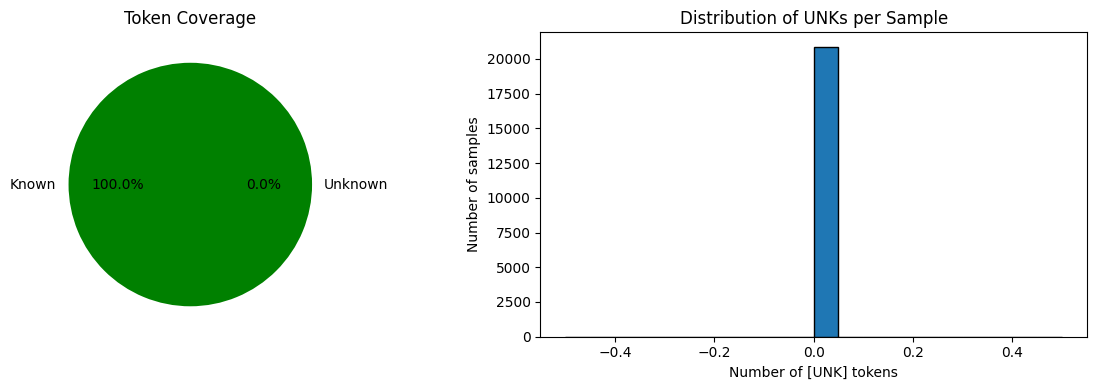

The [UNK] token has the ID: 1.
Testing tokenizer coverage...


Testing...:   0%|          | 0/158660 [00:00<?, ?it/s]

Total tokens tested: 52618328.
Total [UNK] tokens found: 118.
Coverage percentage: 100.00%.
Perfect imports percentage: 100.00%.
Sequence: invalid registerclipboardformat invalid charnext invalid unregisterclass invalid postthreadmessage i
[UNK] tokens: 41
Total tokens: 398
Sequence: m#icu u strcmpcodepointorder qe 4 2 m#icu ucnv resetfromunicode qe 4 2 m#icu ucnv resettounicode qe 
[UNK] tokens: 26
Total tokens: 512
Sequence: m#icu u strcmpcodepointorder qe 4 2 m#icu ucnv fromuchars qe 4 2 m#icu ucnv getnextuchar qe 4 2 m#ic
[UNK] tokens: 24
Total tokens: 512
Sequence: m#icu u strcmpcodepointorder qe 4 2 m#icu u austrcpy qe 4 2 m#icu u strlen qe 4 2 m#icu ucnv resetfr
[UNK] tokens: 23
Total tokens: 512




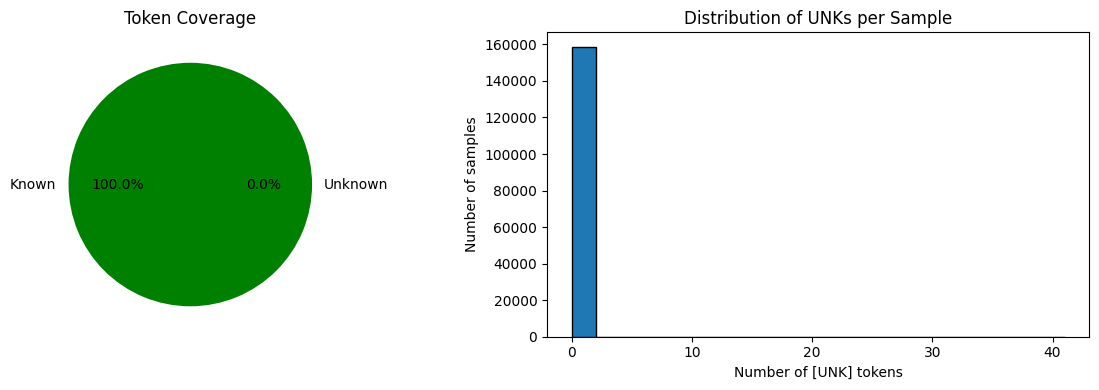

In [20]:
# Test coverage on both validation and test sets.
tokenizer_coverage = test_tokenizer_coverage(import_tokenizer, filtered_val)
tokenizer_coverage = test_tokenizer_coverage(import_tokenizer, filtered_test)

## <u>11. Test Import Tokenizer Compression (w/o Truncation)</u>

In [17]:
def test_tokenizer_compression(tokenizer, test_samples):
  """
  Test how efficiently the BPE tokenizer can compress import sequences (i.e. how efficiently
  it learns meaningful patterns).

  Args:
    tokenizer     : A BPE tokenizer trained on import sequences.
    test_samples  : A DataFrame containing test samples (needs pre-tokenization).

  Returns:
    The mean of all compression ratios for all test samples.
  """

  initial_lengths = []
  tokenized_lengths = []
  compression_ratios = []

  print("\nTesting tokenizer compression...")
  print("=" * 60)

  for _, sample in tqdm(test_samples.iterrows(), total=len(test_samples), desc="Testing..."):
    # Determine and save the initial import sequence length.
    initial_seq = " ".join(sample["imports"]).replace("::", " ").replace("_", " ")
    initial_tokens = initial_seq.split()
    initial_lengths.append(len(initial_tokens))

    # Determine the tokenized representation.
    encoded = tokenizer.encode(initial_seq)

    # Subtract the 2 special tokens [CLS] and [SEP].
    tokenized_length = len(encoded.ids) - 2
    tokenized_lengths.append(tokenized_length)

    # Compute the compression ratio for the current sample.
    compression_ratio = len(initial_tokens) / tokenized_length if tokenized_length > 0.0 else 0.0
    compression_ratios.append(compression_ratio)

  # Print a summary of the coverage results.
  print(f"Average nr. of original tokens: {np.mean(initial_lengths):.2f}.")
  print(f"Average nr. of BPE tokens: {np.mean(tokenized_lengths):.2f}.")
  print(f"Average compression ratio: {np.mean(compression_ratios):.2f}x.")
  print(f"Best compression ratio: {max(compression_ratios):.2f}x.")
  print(f"Worst compression ratio: {min(compression_ratios):.2f}x.")
  print("=" * 60)

  print("\n")

  fig, axes = plt.subplots(1, 3, figsize=(15, 4))

  # Plot 1: Histogram of the distribution of token counts.
  axes[0].hist(initial_lengths, bins=30, alpha=0.5, label="Initial", color="blue")
  axes[0].hist(tokenized_lengths, bins=30, alpha=0.5, label="Tokenized", color="red")
  axes[0].set_xlabel("Number of Tokens")
  axes[0].set_ylabel("Frequency")
  axes[0].set_title("Token Count Distribution")
  axes[0].legend()

  # Plot 2: Histogram of the distribution of compression ratios.
  axes[1].hist(compression_ratios, bins=30, color="green", edgecolor="black")
  axes[1].set_xlabel("Compression Ratio")
  axes[1].set_ylabel("Frequency")
  axes[1].set_title("Compression Ratio Distribution")
  axes[1].axvline(1.0, color="red", linestyle="--", label="No Compression")
  axes[1].legend()

  # Plot 3: Scatter plot of original vs tokenized length.
  axes[2].scatter(initial_lengths, tokenized_lengths, alpha=0.5, s=10)
  axes[2].plot([0, max(initial_lengths)], [0, max(initial_lengths)], "r--", label="1:1 Ratio")
  axes[2].set_xlabel("Original Token Count")
  axes[2].set_ylabel("BPE Token Count")
  axes[2].set_title("Original vs Tokenized Length")
  axes[2].legend()

  plt.tight_layout()
  plt.show()

  return np.mean(compression_ratios)

Testing tokenizer compression...


Testing...:   0%|          | 0/20870 [00:00<?, ?it/s]

Average nr. of original tokens: 437.16.
Average nr. of BPE tokens: 324.24.
Average compression ratio: 1.21x.
Best compression ratio: 7.12x.
Worst compression ratio: 0.23x.




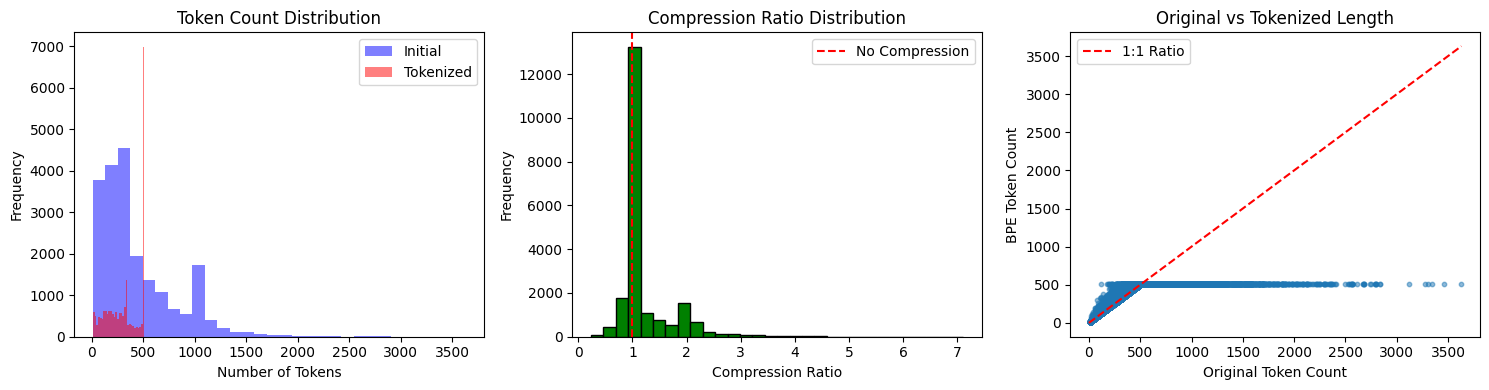

Testing tokenizer compression...


Testing...:   0%|          | 0/158660 [00:00<?, ?it/s]

Average nr. of original tokens: 439.30.
Average nr. of BPE tokens: 329.64.
Average compression ratio: 1.20x.
Best compression ratio: 9.09x.
Worst compression ratio: 0.22x.




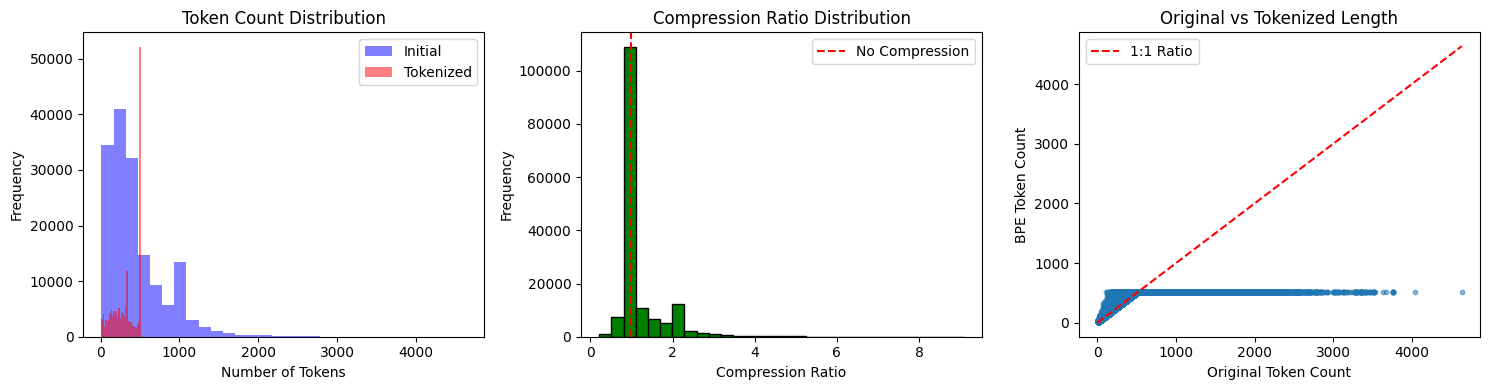

In [22]:
# Test compression on both validation and test sets.
mean_compression_ratio = test_tokenizer_compression(import_tokenizer, filtered_val)
mean_compression_ratio = test_tokenizer_compression(import_tokenizer, filtered_test)

## <u>12. Compression Rate, Vocabulary Size and Embedding Memory Trade-Off</u>

In [18]:
def sweep_vocab_sizes(train, test, vocab_sizes, min_frequency=2, embedding_dim=512):
  results = []

  for vocab_size in vocab_sizes:
    tokenizer = train_import_tokenizer(train, vocab_size=vocab_size, min_frequency=min_frequency)

    mean_compression_ratio = test_tokenizer_compression(tokenizer, test)

    # Compute the memory (in MB) needed for embedding.
    embedding_memory_usage = (vocab_size * embedding_dim * 4) / (1024 * 1024)

    results.append({
      "vocab_size": vocab_size,
      "mean_compression_ratio": mean_compression_ratio,
      "embedding_memory_usage": embedding_memory_usage
    })

  return results


def plot_vocab_size_compression_tradeoff(results):
  vocab_sizes = [r["vocab_size"] for r in results]
  compression_ratios = [r["mean_compression_ratio"] for r in results]
  embedding_mems = [r["embedding_memory_usage"] for r in results]

  print("\n")

  fig, ax1 = plt.subplots()

  # Plot 1: Compression ratios with respect to vocabulary size.
  ax1.set_xlabel("Vocabulary Size")
  ax1.set_ylabel("Compression Ratio", color="tab:blue")
  ax1.plot(vocab_sizes, compression_ratios, marker="o", color="tab:blue", label="Compression Ratio")
  ax1.tick_params(axis="y", labelcolor="tab:blue")

  # Plot 2: Embedding memory required with respect to vocabulary size.
  ax2 = ax1.twinx()
  ax2.set_ylabel("Embedding Table Size (MB)", color="tab:red")
  ax2.plot(vocab_sizes, embedding_mems, marker="s", color="tab:red", label="Embedding Memory")
  ax2.tick_params(axis="y", labelcolor="tab:red")

  fig.tight_layout()
  plt.title("Tokenizer Trade-off: Compression vs Embedding Size")
  plt.show()

  print("\n")

Training BPE tokenizer with 10000 tokens...
Example sequences: vcl initialization vcl finalization kernel waitforsingleobject kernel sleep kernel gettemppath kerne
Tokenizer vocabulary size: 10000.
Testing tokenizer compression...


Testing...:   0%|          | 0/29359 [00:00<?, ?it/s]

Average nr. of original tokens: 449.21.
Average nr. of BPE tokens: 547.78.
Average compression ratio: 0.92x.
Best compression ratio: 1.00x.
Worst compression ratio: 0.20x.




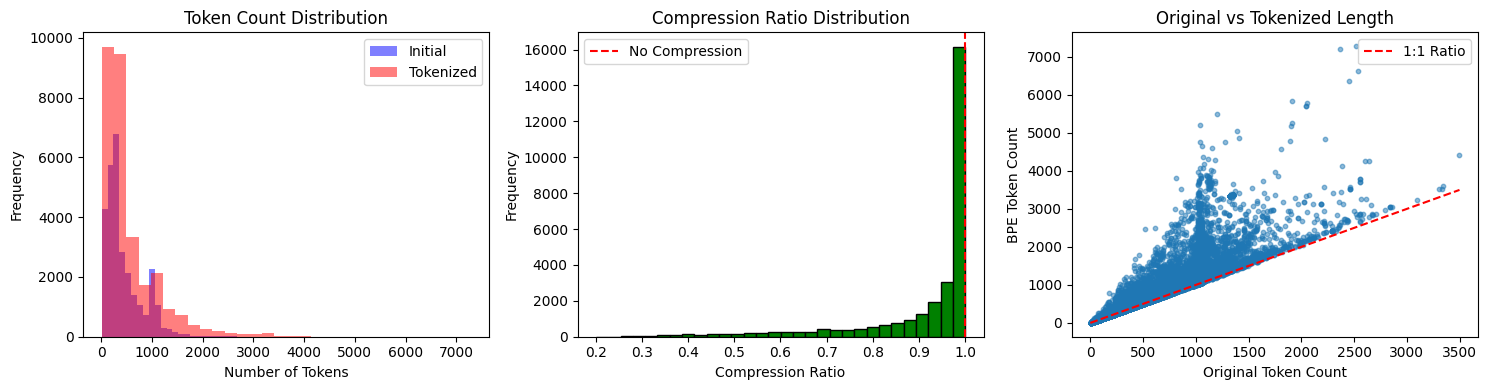

Training BPE tokenizer with 12500 tokens...
Example sequences: vcl initialization vcl finalization kernel waitforsingleobject kernel sleep kernel gettemppath kerne
Tokenizer vocabulary size: 12500.
Testing tokenizer compression...


Testing...:   0%|          | 0/29359 [00:00<?, ?it/s]

Average nr. of original tokens: 449.21.
Average nr. of BPE tokens: 535.47.
Average compression ratio: 0.93x.
Best compression ratio: 1.00x.
Worst compression ratio: 0.21x.




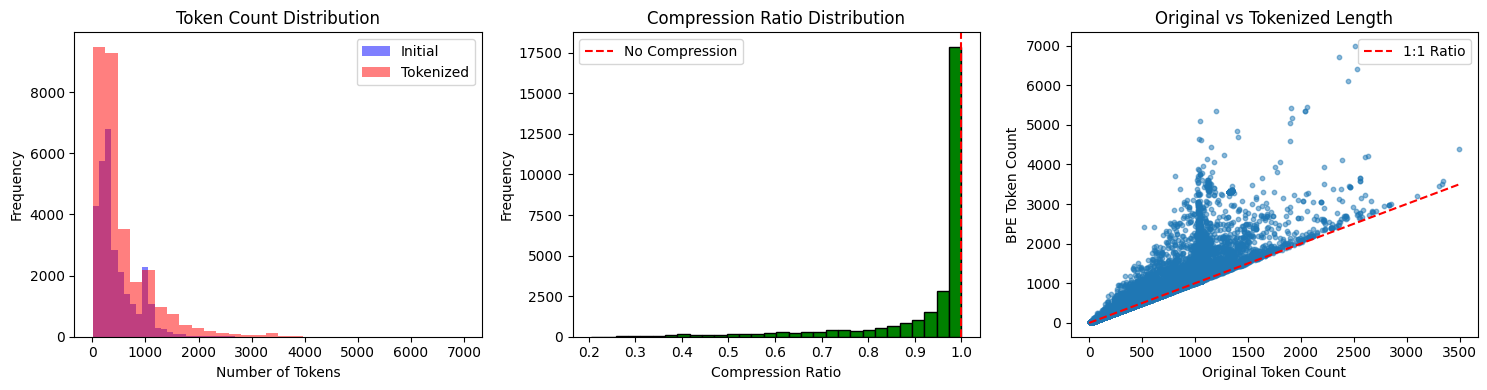

Training BPE tokenizer with 15000 tokens...
Example sequences: vcl initialization vcl finalization kernel waitforsingleobject kernel sleep kernel gettemppath kerne
Tokenizer vocabulary size: 15000.
Testing tokenizer compression...


Testing...:   0%|          | 0/29359 [00:00<?, ?it/s]

Average nr. of original tokens: 449.21.
Average nr. of BPE tokens: 527.77.
Average compression ratio: 0.93x.
Best compression ratio: 1.00x.
Worst compression ratio: 0.21x.




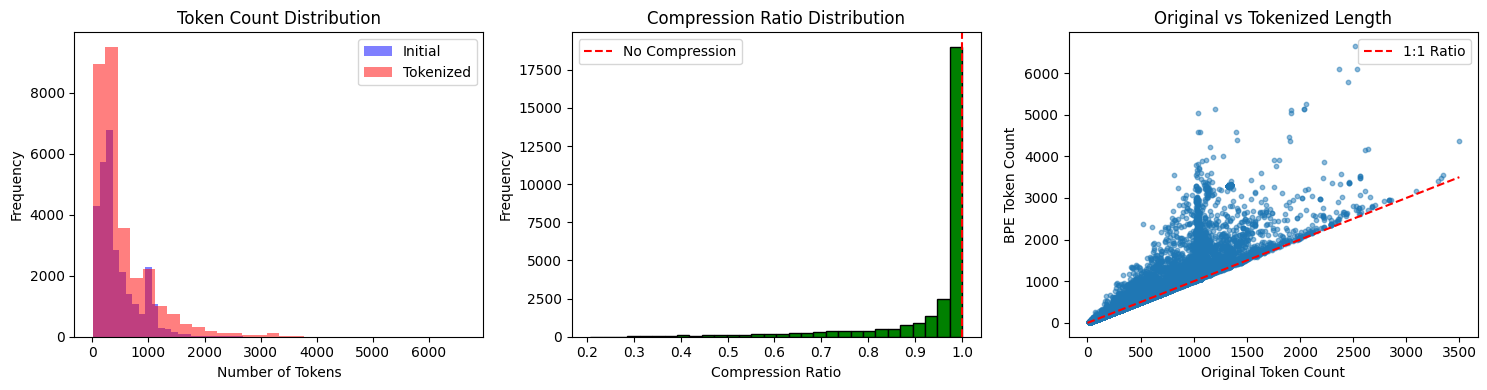

Training BPE tokenizer with 17500 tokens...
Example sequences: vcl initialization vcl finalization kernel waitforsingleobject kernel sleep kernel gettemppath kerne
Tokenizer vocabulary size: 17500.
Testing tokenizer compression...


Testing...:   0%|          | 0/29359 [00:00<?, ?it/s]

Average nr. of original tokens: 449.21.
Average nr. of BPE tokens: 521.56.
Average compression ratio: 0.94x.
Best compression ratio: 1.00x.
Worst compression ratio: 0.21x.




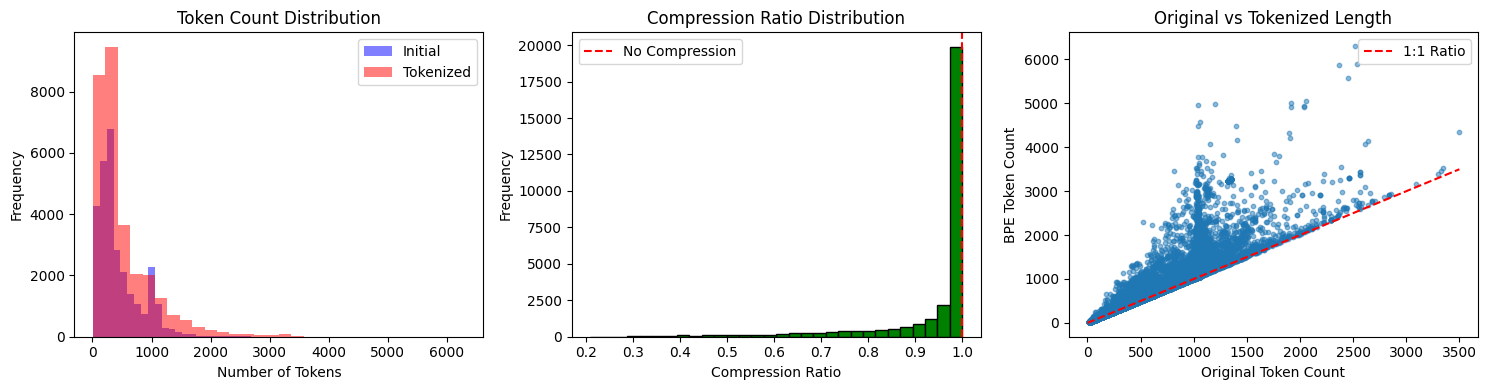

Training BPE tokenizer with 20000 tokens...
Example sequences: vcl initialization vcl finalization kernel waitforsingleobject kernel sleep kernel gettemppath kerne
Tokenizer vocabulary size: 20000.
Testing tokenizer compression...


Testing...:   0%|          | 0/29359 [00:00<?, ?it/s]

Average nr. of original tokens: 449.21.
Average nr. of BPE tokens: 516.43.
Average compression ratio: 0.94x.
Best compression ratio: 1.00x.
Worst compression ratio: 0.21x.




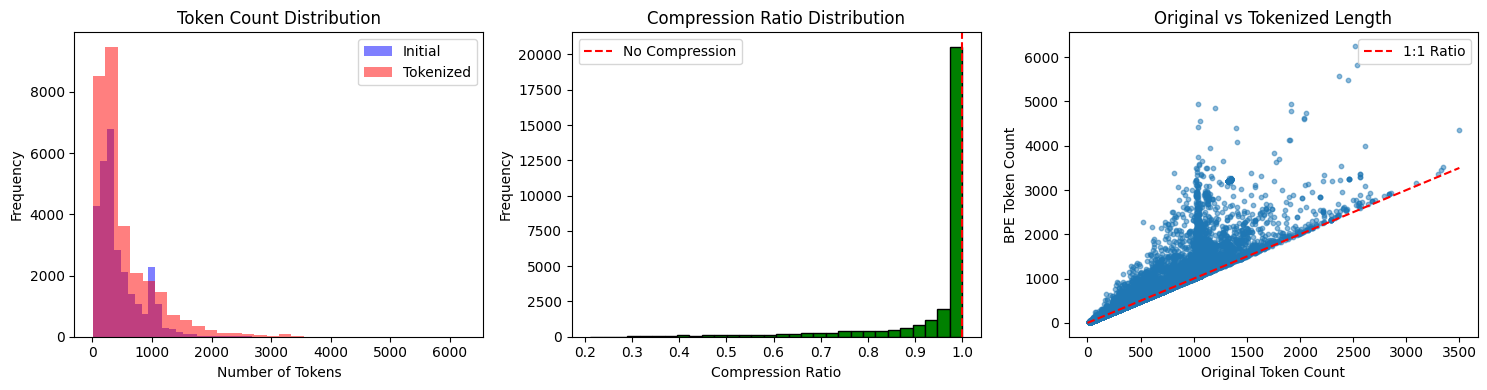

Training BPE tokenizer with 22500 tokens...
Example sequences: vcl initialization vcl finalization kernel waitforsingleobject kernel sleep kernel gettemppath kerne
Tokenizer vocabulary size: 22500.
Testing tokenizer compression...


Testing...:   0%|          | 0/29359 [00:00<?, ?it/s]

Average nr. of original tokens: 449.21.
Average nr. of BPE tokens: 512.56.
Average compression ratio: 0.95x.
Best compression ratio: 1.00x.
Worst compression ratio: 0.21x.




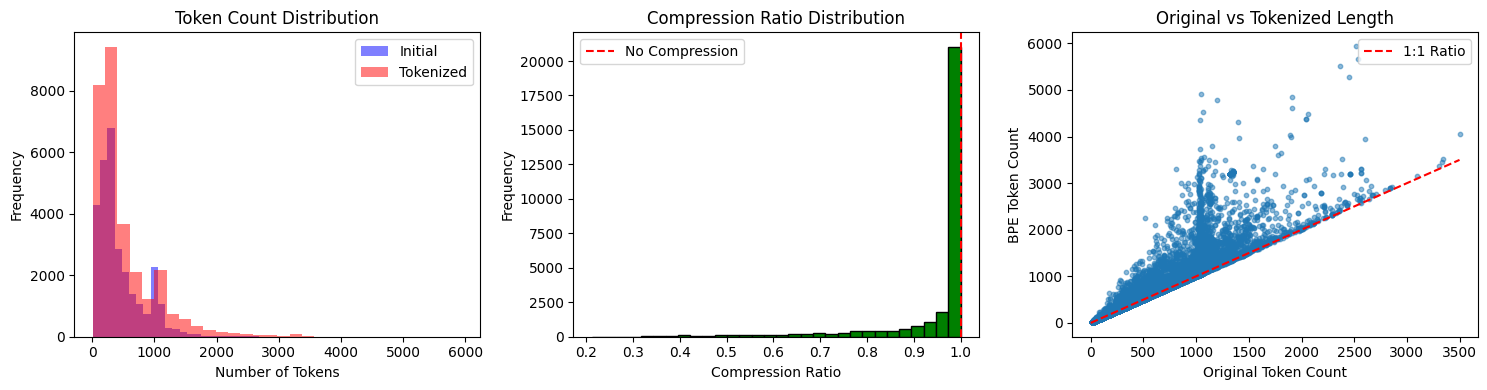

Training BPE tokenizer with 25000 tokens...
Example sequences: vcl initialization vcl finalization kernel waitforsingleobject kernel sleep kernel gettemppath kerne
Tokenizer vocabulary size: 25000.
Testing tokenizer compression...


Testing...:   0%|          | 0/29359 [00:00<?, ?it/s]

Average nr. of original tokens: 449.21.
Average nr. of BPE tokens: 509.37.
Average compression ratio: 0.95x.
Best compression ratio: 1.00x.
Worst compression ratio: 0.21x.




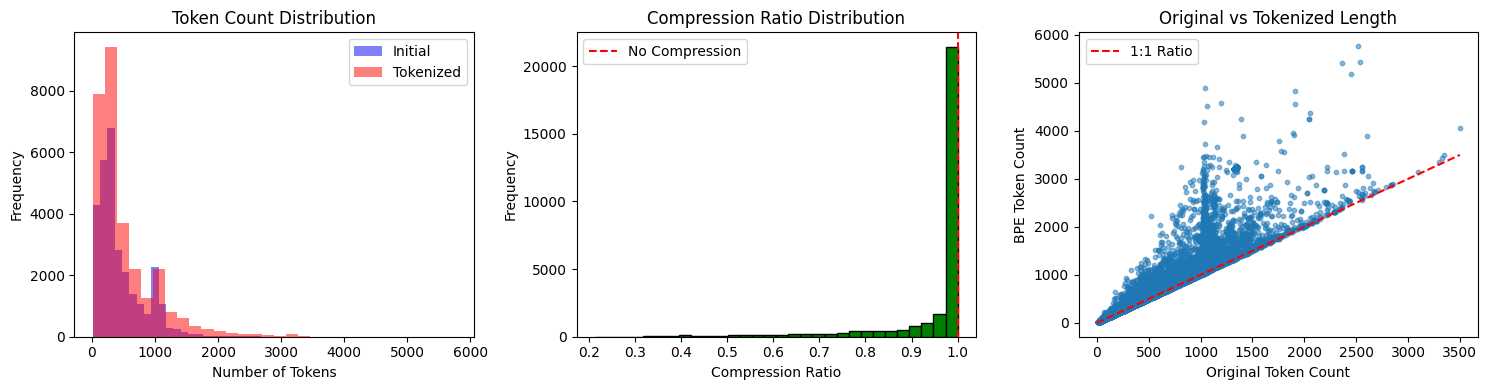

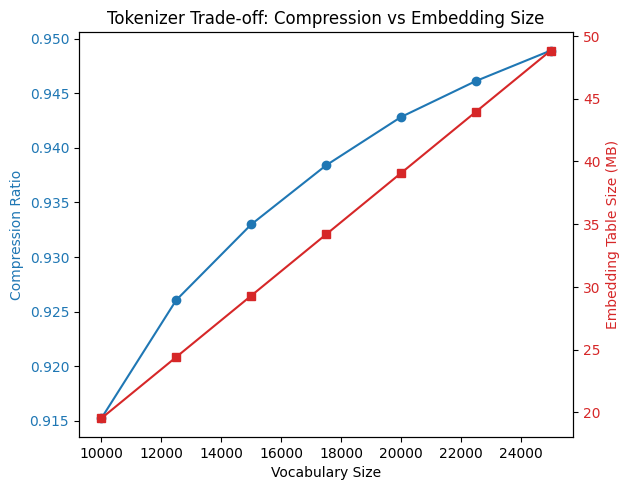

In [45]:
# vocab_sizes = [2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]

# Narrowing it down to [10k, 25k].
vocab_sizes = [10000, 12500, 15000, 17500, 20000, 22500, 25000]
results = sweep_vocab_sizes(train, filtered_test, vocab_sizes, min_frequency=2)
plot_vocab_size_compression_tradeoff(results)

In [15]:
# Determine the 95th percentile of tokenized lengths.
tokenized_lengths = []

for imports_list in tqdm(train_final["imports"], total=len(train_final), desc="Loading..."):
  sequence = " ".join(imports_list).replace("::", " ").replace("_", " ")
  encoded = import_tokenizer.encode(sequence)
  tokenized_lengths.append(len(encoded.ids))

percentile_95 = np.percentile(tokenized_lengths, 95)

print(f"The 95th percentile for token sequence lengths is: {percentile_95:.2f}.")

Loading...:   0%|          | 0/309774 [00:00<?, ?it/s]

The 95th percentile for token sequence lengths is: 1369.00.


In [16]:
# Determine the percentage of samples covered by length = 512.
token_lengths = np.array(tokenized_lengths)
percentile_512 = (token_lengths <= 512).mean() * 100
# About 72.5%.
print(f"A length of 512 covers {percentile_512}% of all samples.")

72.56322351133407


## <u>13. Import-Based Adversarial Generation Methods</u>

In [19]:
def adversarial_shuffle(imports):
  """
  Shuffle a sequence of imports to generate a new adversarial variant. Since imports are order
  agnostic, reordering them will not break the functionality of the underlying sample. As such,
  the original label can be attached to the resulting variant. All things related to the random
  seed of the different RNGs are defined in Section 1.

  Args:
    imports : A sequence of imports.

  Returns:
    A new adversarial sample with imports that differ in ordering.
  """

  variant = imports.copy()
  random.shuffle(variant)
  return variant


def adversarial_mask(imports, mask_prob=0.1, mask_token="[MASK]"):
  """
  Mask a random subset of imports to generate a new adversarial variant. Since this does not
  actually remove the imports (rather simply masks them from the model), it will not affect
  the functionality of the sample. As such, the original label can be attached to the resulting
  variant. All things related to the random seed of the different RNGs are defined in Section 1.

  Args:
    imports     : A sequence of imports.
    mask_prob   : The probability that an import is masked (by default 10%).
    mask_token  : The token used to mask imports (by default [MASK]).

  Returns:
    A new adversarial sample with some of the imports masked.
  """

  return [mask_token if random.random() < mask_prob else imp for imp in imports]


def adversarial_add(imports, dataset, add_prob=0.1, row_sample_size=5):
  """
  Add random imports to a sample from a number of randomly chosen samples in the dataset to generate
  a new adversarial variant. The added imports should be different from imports already included in
  the sample to avoid duplicates. Adding imports does not break the functionality of the underlying
  sample (just because imports are added does not mean they are actually used). As such, the original
  label can be attached to the resulting variant. The imports are added at the end of the initial
  sequence and the resulting variant is shuffled. All things related to the random seed of the different
  RNGs are defined in Section 1.

  Args:
    imports         : A sequence of imports.
    dataset         : A DataFrame of samples with imports.
    add_prob        : The probability that a certain import is added (by default 10%).
    row_sample_size : The number of rows to sample from the dataset for imports (by default 5).

  Returns:
    A new adversarial sample with additional imports.
  """

  variant = imports.copy()

  # Sample random rows from the dataset.
  sampled_rows = dataset.sample(n=row_sample_size, replace=False, random_state=42)

  # Flatten the imports from the sampled rows.
  sampled_imports = [imp for sequence in sampled_rows["imports"] for imp in sequence]

  # Cap the number of added imports to 10% of the initial sequence length.
  added_imports = 0
  max_imports_to_add = int(0.1 * len(imports))

  # Add imports that aren't already present in the sequence.
  for imp in sampled_imports:
    if imp not in variant and random.random() < add_prob and added_imports <= max_imports_to_add:
      variant.append(imp)
      added_imports += 1

  # Shuffle the resulting imports sequence (so the additional imports are not only at the end).
  random.shuffle(variant)

  return variant

In [21]:
def generate_adversarial_variants(imports, dataset, num_variants=1, mask_prob=0.1, add_prob=0.1):
  """
  Generate one or more (functionality-preserving) adversarial variants for a given import sequence.
  All things related to the random seed of the different RNGs are defined in Section 1.

  Args:
    imports      : A sequence of imports.
    dataset      : A DataFrame of samples with imports.
    num_variants : The number of adversarial variants to generate (by default 1 for memory reasons).

  Returns:
    One or more adversarial variants.
  """

  variants = []
  methods = ["shuffle", "mask", "add"]

  for _ in range(num_variants):
    choice = random.choice(methods)

    if choice == "shuffle":
      variants.append(adversarial_shuffle(imports))

    elif choice == "mask":
      variants.append(adversarial_mask(imports, mask_prob=mask_prob))

    elif choice == "add":
      variants.append(adversarial_add(imports, dataset, add_prob=add_prob))

  return variants

## <u>14. Dataset Augmentation</u>

In [46]:
def augment_dataset(dataset, num_variants=1, mask_prob=0.1, add_prob=0.1):
  """
  Apply adversarial augmentation (using the methods described above) to the entire dataset.

  Args:
    dataset       : The dataset to augment as a DataFrame.
    num_variants  : The number of adversarial variants to generate for each sample (by default 1).

  Returns:
    The augmented dataset as a DataFrame.
  """

  augmented_samples = []

  print("Augmenting the dataset...")
  print("=" * 60)
  print(f"Generating {num_variants} adversarial variants per sample...")

  for _, sample in tqdm(dataset.iterrows(), total=len(dataset), desc="Augmenting..."):
    # Add the initial sequence to the augmented dataset.
    augmented_samples.append({
      "sha256": sample["sha256"],
      "label": sample["label"],
      "imports": sample["imports"],
      "n_imports": len(sample["imports"]),
      # Add the timestamp for AUT downstream.
      "timestamp": sample["first_submission"]
    })

    # Generate adversarial variants for the current sample.
    variants = generate_adversarial_variants(sample["imports"], dataset, num_variants=num_variants, mask_prob=mask_prob, add_prob=add_prob)

    # Add the new variants after the initial sequence (to preserve chronological order).
    for i, variant in enumerate(variants):
      augmented_samples.append({
        # Create a unique hash for the new sample (original hash + adv + variant index).
        "sha256": f"{sample['sha256']}_adv{i}",
        "label": sample["label"],
        "imports": variant,
        "n_imports": len(variant),
        # Add the timestamp for AUT downstream.
        "timestamp": sample["first_submission"]
      })

  print(f"Generated a total of {len(augmented_samples) - len(dataset)} adversarial samples.")
  print("=" * 60)

  return pd.DataFrame(augmented_samples)

In [ ]:
# Load the clean train and test sets from the corresponding JSONL files.
clean_train_path = "/content/drive/MyDrive/train_normalized.jsonl"
clean_test_path = "/content/drive/MyDrive/test_normalized.jsonl"

print(f"Loading the train set from: {clean_train_path}...")
print(f"Loading the test set from: {clean_test_path}...")

train = load_jsonl_to_dataframe(clean_train_path)
filtered_test = load_jsonl_to_dataframe(clean_test_path)

# Sweep different augmentation parameters.
add_probabilities = [0.05, 0.1, 0.15]
mask_probabilities = [0.1, 0.15, 0.2]

# Create all combinations of add and mask probabilities.
for add_prob, mask_prob in itertools.product(add_probabilities, mask_probabilities):
  print(f"Augmenting with add_prob = {add_prob} and mask_prob = {mask_prob}...")
  print("=" * 60)

  train_augmented = augment_dataset(
    train,
    num_variants=1,
    mask_prob=mask_prob,
    add_prob=add_prob
  )
  save_dataframe_to_jsonl(train_augmented, f"/content/drive/MyDrive/train_normalized_augmented_mask{mask_prob * 100}_add{add_prob * 100}.jsonl")

  test_augmented = augment_dataset(
    filtered_test,
    num_variants=1,
    mask_prob=mask_prob,
    add_prob=add_prob
  )
  save_dataframe_to_jsonl(test_augmented, f"/content/drive/MyDrive/test_normalized_augmented_mask{mask_prob * 100}_add{add_prob * 100}.jsonl")

  print("=" * 60)

# No augmentation is applied to the validation set (only used for tuning).

Loading the train set from: /content/drive/MyDrive/train_normalized.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized.jsonl...
Augmenting with add_prob = 0.05 and mask_prob = 0.1...
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/309774 [00:00<?, ?it/s]

Generated a total of 309774 adversarial samples.
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/158660 [00:00<?, ?it/s]

Generated a total of 158660 adversarial samples.
Augmenting with add_prob = 0.05 and mask_prob = 0.15...
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/309774 [00:00<?, ?it/s]

Generated a total of 309774 adversarial samples.
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/158660 [00:00<?, ?it/s]

Generated a total of 158660 adversarial samples.
Augmenting with add_prob = 0.05 and mask_prob = 0.2...
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/309774 [00:00<?, ?it/s]

Generated a total of 309774 adversarial samples.
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/158660 [00:00<?, ?it/s]

Generated a total of 158660 adversarial samples.
Augmenting with add_prob = 0.1 and mask_prob = 0.1...
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/309774 [00:00<?, ?it/s]

Generated a total of 309774 adversarial samples.
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/158660 [00:00<?, ?it/s]

Generated a total of 158660 adversarial samples.
Augmenting with add_prob = 0.1 and mask_prob = 0.15...
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/309774 [00:00<?, ?it/s]

Generated a total of 309774 adversarial samples.
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/158660 [00:00<?, ?it/s]

Generated a total of 158660 adversarial samples.
Augmenting with add_prob = 0.1 and mask_prob = 0.2...
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/309774 [00:00<?, ?it/s]

Generated a total of 309774 adversarial samples.
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/158660 [00:00<?, ?it/s]

Generated a total of 158660 adversarial samples.
Augmenting with add_prob = 0.15 and mask_prob = 0.1...
Augmenting the dataset...
Generating 1 adversarial variants per sample...


Augmenting...:   0%|          | 0/309774 [00:00<?, ?it/s]

In [12]:
# Print normal samples along with an adversarial sample.
print("Normal Samples")
print("=" * 60)

normal_sample = train.iloc[0]
print(f"SHA256: {normal_sample['sha256'][:16]}...")
print(f"Label: {normal_sample['label']}")
print(f"Imports: {normal_sample['imports']}")
print(f"Length: {len(normal_sample['imports'])}")
print("=" * 60)

normal_sample = train_augmented.iloc[0]
print(f"SHA256: {normal_sample['sha256'][:16]}...")
print(f"Label: {normal_sample['label']}")
print(f"Imports: {normal_sample['imports']}")
print(f"Length: {len(normal_sample['imports'])}")
print("=" * 60)

print("Adversarial Sample")
print("=" * 60)

adversarial_sample = train_augmented.iloc[1]
print(f"SHA256: {adversarial_sample['sha256']}...")
print(f"Label: {adversarial_sample['label']}")
print(f"Imports: {adversarial_sample['imports']}")
print(f"Length: {len(adversarial_sample['imports'])}")
print("=" * 60)

Normal Samples
SHA256: e19016cdc028554c...
Label: 0
Imports: ['msys_ncursesw::sp', 'msys_ncursesw::nc_screen_of', 'msys_ncursesw::nc_wcrtomb', 'msys_ncursesw::copywin', 'msys_ncursesw::delwin', 'msys_ncursesw::derwin', 'msys_ncursesw::getmouse', 'msys_ncursesw::is_linetouched', 'msys_ncursesw::newpad', 'msys_ncursesw::setcchar', 'msys_ncursesw::stdscr', 'msys_ncursesw::wadd_wch', 'msys_ncursesw::waddch', 'msys_ncursesw::waddnstr', 'msys_ncursesw::wbkgdset', 'msys_ncursesw::wclear', 'msys_ncursesw::wclrtobot', 'msys_ncursesw::wclrtoeol', 'msys_ncursesw::wcursyncup', 'msys_ncursesw::wdelch', 'msys_ncursesw::wenclose', 'msys_ncursesw::werase', 'msys_ncursesw::win_wch', 'msys_ncursesw::win_wchnstr', 'msys_ncursesw::winch', 'msys_ncursesw::winnstr', 'msys_ncursesw::wins_wch', 'msys_ncursesw::winsch', 'msys_ncursesw::winsdelln', 'msys_ncursesw::wmouse_trafo', 'msys_ncursesw::wmove', 'msys_ncursesw::wresize', 'msys_ncursesw::wsyncup', 'msys_ncursesw::wtouchln', 'msys::cxa_atexit', 'msys::errn

In [13]:
# # Check that the tokenizer removes [UNK] tokens.
# sequence_with_unk = "kernel function [UNK] getfile"
# encoded_seq = import_tokenizer.encode(sequence_with_unk)

# # Print the tokens not the token ids.
# decoded_seq = import_tokenizer.decode(encoded_seq.ids)
# print(decoded_seq)

kernel function getfile


In [11]:
# # Check how the tokenizer handles import sequences containing masked imports.
# example_masked_sequence = "kernel function [MASK] user dll"
# encoded_masked_sequence = import_tokenizer.encode(example_masked_sequence)
# print(encoded_masked_sequence.tokens)

['[CLS]', 'kernel', 'function', '[MASK]', 'user', 'dll', '[SEP]']


The [UNK] token has the ID: 1.
Testing tokenizer coverage...


Testing...:   0%|          | 0/317320 [00:00<?, ?it/s]

Total tokens tested: 104950795.
Total [UNK] tokens found: 223.
Coverage percentage: 100.00%.
Perfect imports percentage: 100.00%.
Sequence: invalid registerclipboardformat invalid charnext invalid unregisterclass invalid postthreadmessage i
[UNK] tokens: 41
Total tokens: 398
Sequence: invalid loadaccelerators # escape invalid drawtext shgetspecialfolderlocation shgetmalloc invalid se
[UNK] tokens: 41
Total tokens: 440
Sequence: m#icu u strcmpcodepointorder qe 4 2 m#icu ucnv resetfromunicode qe 4 2 m#icu ucnv resettounicode qe 
[UNK] tokens: 26
Total tokens: 512
Sequence: m#icu ucnv setfallback qe 4 2 m#icu ucnv resettounicode qe 4 2 kernel getsystemtimeasfiletime kernel
[UNK] tokens: 25
Total tokens: 512
Sequence: m#icu u strcmpcodepointorder qe 4 2 m#icu ucnv fromuchars qe 4 2 m#icu ucnv getnextuchar qe 4 2 m#ic
[UNK] tokens: 24
Total tokens: 512




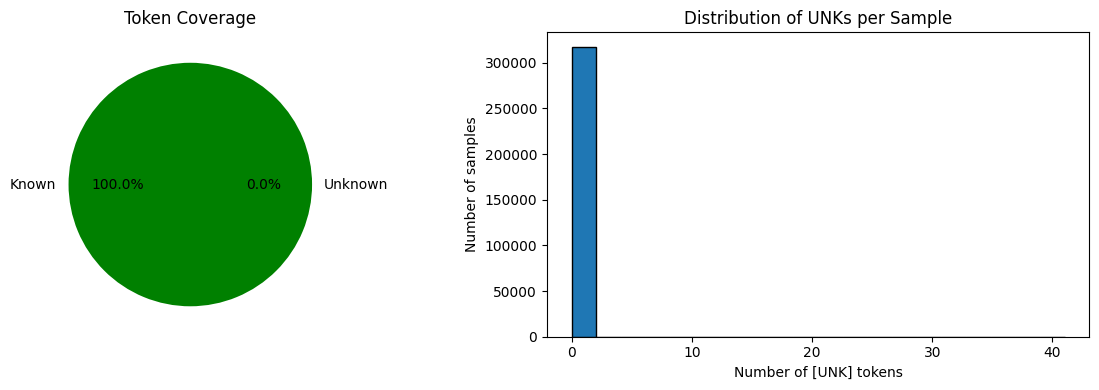

In [9]:
# Test the tokenizer coverage on the augmented test set.
test_augmented = load_jsonl_to_dataframe("/content/drive/MyDrive/test_normalized_augmented_mask20.0_add15.0.jsonl")
tokenizer_coverage = test_tokenizer_coverage(import_tokenizer, test_augmented)

## <u>15. Dataset Encoding (Clean + Augmented)</u>

In [24]:
def encode_dataset(dataset, tokenizer, output_path=None, chunk_size=None):
  """
  Encode a given imports dataset for transformer input and optionally save in chunks.

  Args:
    dataset     : A DataFrame of samples with imports (not pre-tokenized).
    tokenizer   : A BPE tokenizer trained on import sequences.
    output_path : Optional path to save the encoded dataset in JSONL format (appends).
    chunk_size  : If specified, processes and saves the data in chunks of this size.

  Returns:
    A DataFrame containing encoded samples if output_path is None, otherwise None.
  """

  encoded_samples = []
  max_tokens_len = tokenizer.truncation["max_length"]

  print(f"Encoding {len(dataset)} samples...")
  print("=" * 60)

  if chunk_size:
    print(f"Processing in chunks of {chunk_size}...")
    # Initialize the output file (will be overwritten if it already exists).
    if output_path:
      with open(output_path, "w") as f:
        pass

  if chunk_size:
    # Process and encode in chunks.
    num_chunks = (len(dataset) + chunk_size - 1) // chunk_size
    for i in tqdm(range(num_chunks), desc="Encoding..."):
      start_idx = i * chunk_size
      end_idx = min((i + 1) * chunk_size, len(dataset))
      chunk_df = dataset.iloc[start_idx:end_idx]

      chunk_encoded_samples = []
      for _, sample in chunk_df.iterrows():
        sequence = " ".join(sample["imports"])
        sequence = sequence.replace("::", " ").replace("_", " ")
        encoded = tokenizer.encode(sequence)

        input_ids = encoded.ids[:max_tokens_len]
        attention_mask = [1] * len(input_ids)

        padding_length = max_tokens_len - len(input_ids)
        if padding_length > 0:
          input_ids = input_ids + [tokenizer.token_to_id("[PAD]")] * padding_length
          attention_mask = attention_mask + [0] * padding_length

        chunk_encoded_samples.append({
          "sha256": sample["sha256"],
          "label": sample["label"],
          "input_ids": input_ids,
          "attention_mask": attention_mask,
          "n_tokens": len(encoded.ids),
          "timestamp": sample["timestamp"],
          "truncated": len(encoded.ids) > max_tokens_len
        })

      # Append the encoded chunk to the output file.
      if output_path:
        with open(output_path, "a") as f:
          for sample_dict in chunk_encoded_samples:
            # Ensure input_ids and attention_mask are lists for JSON serialization.
            sample_dict["input_ids"] = list(sample_dict["input_ids"])
            sample_dict["attention_mask"] = list(sample_dict["attention_mask"])
            json_line = json.dumps(sample_dict) + "\n"
            f.write(json_line)
      else:
        # If no output_path, collect all samples.
        encoded_samples.extend(chunk_encoded_samples)

    print(f"\nTotal samples encoded: {len(dataset)}.")
    print("=" * 60)

    if output_path:
      # Return None if saved to file.
      return None
    else:
       # Return the encoded DataFrame if not saved to a file.
      return pd.DataFrame(encoded_samples)

  else:
    # Original behavior: encode all and return a DataFrame.
    for _, sample in tqdm(dataset.iterrows(), total=len(dataset), desc="Encoding..."):
      sequence = " ".join(sample["imports"])
      sequence = sequence.replace("::", " ").replace("_", " ")
      encoded = tokenizer.encode(sequence)

      input_ids = encoded.ids[:max_tokens_len]
      attention_mask = [1] * len(input_ids)

      padding_length = max_tokens_len - len(input_ids)
      if padding_length > 0:
        input_ids = input_ids + [tokenizer.token_to_id("[PAD]")] * padding_length
        attention_mask = attention_mask + [0] * padding_length

      encoded_samples.append({
        "sha256": sample["sha256"],
        "label": sample["label"],
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "n_tokens": len(encoded.ids),
        "timestamp": sample["timestamp"],
        "truncated": len(encoded.ids) > max_tokens_len
      })

    print(f"\nTotal samples encoded: {len(encoded_samples)}.")
    print("=" * 60)

    if output_path:
      # Save the entire dataframe if output_path is provided without chunking.
      save_dataframe_to_jsonl(pd.DataFrame(encoded_samples), output_path)
      return None
    else:
      # Return the encoded DataFrame if not saved to a file.
      return pd.DataFrame(encoded_samples)

In [11]:
# Check if the import tokenizer is loaded.
if "import_tokenizer" not in globals():
  print("Loading the import tokenizer...")
  print("=" * 60)

  import_tokenizer_path = "/content/drive/MyDrive/import_tokenizer.json"
  import_tokenizer = Tokenizer.from_file(import_tokenizer_path)

  print(f"The import tokenizer has been loaded from: {import_tokenizer_path}.")
  print("=" * 60)

In [12]:
add_probabilities = [0.05, 0.1, 0.15]
mask_probabilities = [0.1, 0.15, 0.2]

# Set a chunk size for encoding to manage memory.
encoding_chunk_size = 10000

# Encode all augmented sets in chunks.
for add_prob, mask_prob in itertools.product(add_probabilities, mask_probabilities):
  print(f"Encoding the augmented sets for add_prob = {add_prob} and mask_prob = {mask_prob}...")
  print("=" * 60)

  # Load the augmented train and test sets from the corresponding JSONL files.
  augmented_train_path = f"/content/drive/MyDrive/train_normalized_augmented_mask{mask_prob * 100}_add{add_prob * 100}.jsonl"
  augmented_test_path = f"/content/drive/MyDrive/test_normalized_augmented_mask{mask_prob * 100}_add{add_prob * 100}.jsonl"

  print(f"Loading the train set from: {augmented_train_path}...")
  print(f"Loading the test set from: {augmented_test_path}...")

  # Load the DataFrames into dictionaries to be able to free up the memory.
  augmented_train = dict()
  augmented_train["df"] = load_jsonl_to_dataframe(augmented_train_path)
  augmented_test = dict()
  augmented_test["df"] = load_jsonl_to_dataframe(augmented_test_path)

  # Define output paths for encoded augmented sets.
  augmented_train_encoded_path = f"/content/drive/MyDrive/train_normalized_augmented_encoded_mask{mask_prob * 100}_add{add_prob * 100}.jsonl"
  augmented_test_encoded_path = f"/content/drive/MyDrive/test_normalized_augmented_encoded_mask{mask_prob * 100}_add{add_prob * 100}.jsonl"

  # Encode and save in chunks for augmented train set.
  encode_dataset(
    augmented_train["df"],
    import_tokenizer,
    output_path=augmented_train_encoded_path,
    chunk_size=encoding_chunk_size
  )

  # Encode and save in chunks for augmented test set.
  encode_dataset(
    augmented_test["df"],
    import_tokenizer,
    output_path=augmented_test_encoded_path,
    chunk_size=encoding_chunk_size
  )

  # Explicitly clear augmented DataFrames to free up memory.
  augmented_train.clear()
  augmented_test.clear()
  # Suggest garbage collection (not guaranteed to run immediately).
  gc.collect()
  # Finally something that actually gives back memory.
  ctypes.CDLL("libc.so.6").malloc_trim(0)

# Encode both clean sets in chunks.
print("\nEncoding the clean sets in chunks...")

# Load the clean train, val and test sets from their corresponding JSONL files.
clean_train_path = "/content/drive/MyDrive/train_normalized.jsonl"
clean_val_path = "/content/drive/MyDrive/val_normalized.jsonl"
clean_test_path = "/content/drive/MyDrive/test_normalized.jsonl"

print(f"Loading the train set from: {clean_train_path}...")
print(f"Loading the val set from: {clean_val_path}...")
print(f"Loading the test set from: {clean_test_path}...")

train = dict()
train["df"] = load_jsonl_to_dataframe(clean_train_path)
filtered_val = dict()
filtered_val["df"] = load_jsonl_to_dataframe(clean_val_path)
filtered_test = dict()
filtered_test["df"] = load_jsonl_to_dataframe(clean_test_path)

# Define output paths for encoded clean sets (train, val and test).
clean_train_encoded_path = "/content/drive/MyDrive/train_normalized_encoded.jsonl"
clean_val_encoded_path = "/content/drive/MyDrive/val_normalized_encoded.jsonl"
clean_test_encoded_path = "/content/drive/MyDrive/test_normalized_encoded.jsonl"

# Encode and save in chunks for clean train set.
encode_dataset(
  train["df"],
  import_tokenizer,
  output_path=clean_train_encoded_path,
  chunk_size=encoding_chunk_size
)

# Encode and save in chunks for the validation set.
encode_dataset(
  filtered_val["df"],
  import_tokenizer,
  output_path=clean_val_encoded_path,
  chunk_size=encoding_chunk_size
)

# Encode and save in chunks for clean test set.
encode_dataset(
  filtered_test["df"],
  import_tokenizer,
  output_path=clean_test_encoded_path,
  chunk_size=encoding_chunk_size
)

# Explicitly delete clean DataFrames to free up memory.
train.clear()
filtered_val.clear()
filtered_test.clear()
# Suggest garbage collection (not guaranteed to run immediately)
gc.collect()
# The only thing that actually works!!
ctypes.CDLL("libc.so.6").malloc_trim(0)

print("=" * 60)

Encoding the augmented sets for add_prob=0.05 and mask_prob=0.1...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask10.0_add5.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask10.0_add5.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.
Encoding the augmented sets for add_prob=0.05 and mask_prob=0.15...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask15.0_add5.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask15.0_add5.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.
Encoding the augmented sets for add_prob=0.05 and mask_prob=0.2...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask20.0_add5.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask20.0_add5.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.
Encoding the augmented sets for add_prob=0.1 and mask_prob=0.1...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask10.0_add10.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask10.0_add10.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.
Encoding the augmented sets for add_prob=0.1 and mask_prob=0.15...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask15.0_add10.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask15.0_add10.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.
Encoding the augmented sets for add_prob=0.1 and mask_prob=0.2...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask20.0_add10.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask20.0_add10.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.
Encoding the augmented sets for add_prob=0.15 and mask_prob=0.1...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask10.0_add15.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask10.0_add15.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.
Encoding the augmented sets for add_prob=0.15 and mask_prob=0.15...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask15.0_add15.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask15.0_add15.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.
Encoding the augmented sets for add_prob=0.15 and mask_prob=0.2...
Loading the train set from: /content/drive/MyDrive/train_normalized_augmented_mask20.0_add15.0.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized_augmented_mask20.0_add15.0.jsonl...
Encoding 619548 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/62 [00:00<?, ?it/s]


Total samples encoded: 619548.
Encoding 317320 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/32 [00:00<?, ?it/s]


Total samples encoded: 317320.

Encoding the clean sets in chunks...
Loading the train set from: /content/drive/MyDrive/train_normalized.jsonl...
Loading the val set from: /content/drive/MyDrive/val_normalized.jsonl...
Loading the test set from: /content/drive/MyDrive/test_normalized.jsonl...
Encoding 309774 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/31 [00:00<?, ?it/s]


Total samples encoded: 309774.
Encoding 20870 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/3 [00:00<?, ?it/s]


Total samples encoded: 20870.
Encoding 158660 samples...
Processing in chunks of 10000...


Encoding...:   0%|          | 0/16 [00:00<?, ?it/s]


Total samples encoded: 158660.


In [13]:
# Load the clean train, val and test sets from the corresponding JSONL files.
clean_train_encoded_path = "/content/drive/MyDrive/train_normalized_encoded.jsonl"
clean_val_encoded_path = "/content/drive/MyDrive/val_normalized_encoded.jsonl"
clean_test_encoded_path = "/content/drive/MyDrive/test_normalized_encoded.jsonl"

# Use the same trick as above to be able to eventually free up the memory.
clean_train_encoded = dict()
clean_train_encoded["df"] = load_jsonl_to_dataframe(clean_train_encoded_path)
clean_val_encoded = dict()
clean_val_encoded["df"] = load_jsonl_to_dataframe(clean_val_encoded_path)
clean_test_encoded = dict()
clean_test_encoded["df"] = load_jsonl_to_dataframe(clean_test_encoded_path)

# Print example encoded samples from all sets.
print("\nEncoded Train Sample")
print("=" * 60)

example = clean_train_encoded["df"].iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']}")
print(f"Input IDs (first 20): {example['input_ids'][:20]}")
print(f"Attention mask (first 20): {example['attention_mask'][:20]}")
print(f"Total tokens: {example['n_tokens']}")
print(f"Truncated: {example['truncated']}")
print("=" * 60)

print("\nEncoded Val Sample")
print("=" * 60)

example = clean_val_encoded["df"].iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']}")
print(f"Input IDs (first 20): {example['input_ids'][:20]}")
print(f"Attention mask (first 20): {example['attention_mask'][:20]}")
print(f"Total tokens: {example['n_tokens']}")
print(f"Truncated: {example['truncated']}")
print("=" * 60)

print("\nEncoded Test Sample")
print("=" * 60)

example = clean_test_encoded["df"].iloc[0]
print(f"SHA256: {example['sha256'][:16]}...")
print(f"Label: {example['label']}")
print(f"Input IDs (first 20): {example['input_ids'][:20]}")
print(f"Attention mask (first 20): {example['attention_mask'][:20]}")
print(f"Total tokens: {example['n_tokens']}")
print(f"Truncated: {example['truncated']}")
print("=" * 60)

Encoded Train Sample
SHA256: e19016cdc028554c...
Label: 0
Input IDs (first 20): [2, 1042, 28, 14034, 295, 1042, 28, 14034, 2563, 1470, 554, 1042, 28, 14034, 2563, 12487, 1042, 28, 14034, 462]
Attention mask (first 20): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total tokens: 287
Truncated: False
Encoded Val Sample
SHA256: 0804de820d898226...
Label: 0
Input IDs (first 20): [2, 54, 1463, 54, 1109, 54, 2604, 54, 2219, 54, 2565, 54, 1032, 54, 1097, 54, 2114, 54, 1521, 54]
Attention mask (first 20): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total tokens: 512
Truncated: False
Encoded Test Sample
SHA256: dfc04a1a9e68128b...
Label: 0
Input IDs (first 20): [2, 113, 3954, 113, 3989, 46, 1302, 46, 1144, 46, 1307, 46, 1263, 46, 506, 46, 1419, 46, 1359, 46]
Attention mask (first 20): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total tokens: 188
Truncated: False


In [14]:
# Check the lengths of some of the encoded samples.
num_samples_to_check = 200000
inconsistent_lengths = False
expected_len = import_tokenizer.truncation["max_length"]

if len(clean_test_encoded["df"]) < num_samples_to_check:
  num_samples_to_check = len(clean_test_encoded["df"])
  print(f"Checking all {num_samples_to_check} samples.")

first_input_length = len(clean_test_encoded["df"].iloc[0]["input_ids"])
first_attention_length = len(clean_test_encoded["df"].iloc[0]["attention_mask"])

for i in tqdm(range(num_samples_to_check), total=num_samples_to_check, desc="Loading..."):
  current_input_length = len(clean_test_encoded["df"].iloc[i]["input_ids"])
  current_attention_length = len(clean_test_encoded["df"].iloc[i]["attention_mask"])

  if current_input_length != expected_len or current_attention_length != expected_len:
    print(f"Sample {i} has inconsistent lengths:")
    print(f"Input IDs length: {current_input_length}")
    print(f"Attention Mask length: {current_attention_length}")
    inconsistent_lengths = True
    break

if not inconsistent_lengths:
  print(f"All checked samples ({num_samples_to_check}) have consistent input_ids and attention_mask lengths of {first_input_length}.")

Checking all 158660 samples.


Loading...:   0%|          | 0/158660 [00:00<?, ?it/s]

All checked samples (158660) have consistent input_ids and attention_mask lengths of 512.


In [7]:
# Checkpoint 2.
if "import_tokenizer" not in globals():
  print("Loading the import tokenizer and clean encoded sets...")
  print("=" * 60)

  # Load the import tokenizer from the file.
  tokenizer_path = "/content/drive/MyDrive/import_tokenizer.json"
  import_tokenizer = Tokenizer.from_file(tokenizer_path)

  # Load the clean train, val and test sets from the corresponding JSONL files.
  clean_train_encoded_path = "/content/drive/MyDrive/train_normalized_encoded.jsonl"
  clean_val_encoded_path = "/content/drive/MyDrive/val_normalized_encoded.jsonl"
  clean_test_encoded_path = "/content/drive/MyDrive/test_normalized_encoded.jsonl"

  # Use the same trick as above to be able to eventually free up the memory.
  clean_train_encoded = dict()
  clean_train_encoded["df"] = load_jsonl_to_dataframe(clean_train_encoded_path)
  clean_val_encoded = dict()
  clean_val_encoded["df"] = load_jsonl_to_dataframe(clean_val_encoded_path)
  clean_test_encoded = dict()
  clean_test_encoded["df"] = load_jsonl_to_dataframe(clean_test_encoded_path)

  print(f"The import tokenizer has been loaded from: {tokenizer_path}.")
  print(f"The clean encoded training set has been loaded from: {clean_train_encoded_path}.")
  print(f"The clean encoded validation set has been loaded from: {clean_val_encoded_path}.")
  print(f"The clean encoded testing set has been loaded from: {clean_test_encoded_path}.")
  print("=" * 60)

else:
  print("The import tokenizer, and clean sets are already loaded.")

Loading the import tokenizer and clean encoded sets...
The import tokenizer has been loaded from: /content/drive/MyDrive/import_tokenizer.json.
The clean encoded training set has been loaded from: /content/drive/MyDrive/train_normalized_encoded.jsonl.
The clean encoded validation set has been loaded from: /content/drive/MyDrive/val_normalized_encoded.jsonl.
The clean encoded testing set has been loaded from: /content/drive/MyDrive/test_normalized_encoded.jsonl.


## <u>16. Prepare Data Loaders</u>

In [28]:
class ImportDataset(Dataset):
  def __init__(self, encoded_df):
    self.data = encoded_df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data.iloc[idx]

    # Convert to tensors on the fly.
    return {
      "input_ids": torch.tensor(sample["input_ids"], dtype=torch.long),
      "attention_mask": torch.tensor(sample["attention_mask"], dtype=torch.long),
      # For binary classification with BCEWithLogitsLoss (use tensor directly since labels are 1D).
      "labels": torch.tensor(sample["label"], dtype=torch.float),
      # Also include the sample timestamp.
      "timestamp": sample["timestamp"]
    }

In [29]:
batch_size = 32

In [30]:
def create_loader(df, batch_size, shuffle=True):
  dataset = ImportDataset(df)
  return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
# Enable shuffling for the training set (prevents the model from learning spurious time-based patterns).
clean_train_loader = create_loader(clean_train_encoded["df"], batch_size)

# Disable shuffling for the validation set (needs to match the test set as closely as possible).
clean_val_loader = create_loader(clean_val_encoded["df"], batch_size, shuffle=False)

# Disable shuffling for the testing set.
clean_test_loader = create_loader(clean_test_encoded["df"], batch_size, shuffle=False)

In [10]:
# Sanity check.
batch = next(iter(clean_train_loader))
print("Shape of input_ids:", batch["input_ids"].shape)
print("Example input_ids:", batch["input_ids"][:30])
print("Shape of attention_masks:", batch["attention_mask"].shape)
print("Shape of labels:", batch["labels"].shape)

Shape of input_ids: torch.Size([32, 512])
Example input_ids: tensor([[    2,  5218,   437,  ...,  2462,  5062,     3],
        [    2,   268,   784,  ...,     0,     0,     0],
        [    2,   113,  1641,  ...,     0,     0,     0],
        ...,
        [    2,    46,  1511,  ..., 12182,   257,     3],
        [    2,   117,  2391,  ...,     0,     0,     0],
        [    2,   545,  2284,  ...,     0,     0,     0]])
Shape of attention_masks: torch.Size([32, 512])
Shape of labels: torch.Size([32])


## <u>17. Build Selective Keep Mask</u>

In [31]:
def generate_logistic_sequence(length, seed, r=4.0):
  """
  Generate a chaotic sequence of the given length using the logistic map (starting from the given
  seed).

  Args:
    length  : The length of the sequence to be generated.
    seed    : The starting (seed) value for the logistic map.
    r       : A parameter determining how the logistic map behaves (4 => full chaos, no islands of stability).

  Returns:
    A numpy array of floats in the interval (0, 1).
  """

  lm_sequence = np.empty(length, dtype=np.float32)
  current_value = float(seed)

  for i in range(length):
    current_value = r * current_value * (1.0 - current_value)
    lm_sequence[i] = current_value

  return lm_sequence


def generate_henon_sequence(length, seed, a=1.4, b=0.3):
  """
  Generate a chaotic sequence of the given length using the Henon map (starting from the given
  seed).

  Args:
    length  : The length of the sequence to be generated.
    seed    : The starting (seed) value for the Henon map.
    a       : Parameter determining the nonlinearity (1.4 => chaotic behavior).
    b       : Parameter determining the dissipation (0.3 => chaotic behavior).

  Returns:
    A numpy array of floats in the interval (0, 1).
  """

  henon_sequence = np.empty(length, dtype=np.float32)
  current_x = float(seed)
  current_y = 0.0

  for i in range(length):
    # For Henon => x_1 = 1.0 - a * (x_0)^2 + y_0.
    next_x = 1.0 - a * current_x ** 2 + current_y
    next_y = b * current_x
    current_x = next_x
    current_y = next_y

    # Scale from the Henon range to [0, 1].
    scaled_value = (current_x + 1.5) / 3.0
    scaled_value = max(0.0, min(1.0, scaled_value))

    henon_sequence[i] = scaled_value

  return henon_sequence


def build_selective_keep_mask(
  input_ids,
  importance_scores=None,
  base_drop_prob=0.15,
  chaos_prob_threshold=0.0,
  special_token_ids=None,
  device=None,
  seed=42,
  chaotic_map="logistic"
):
  """
  Create a boolean mask of shape [Batch Size, Sequence Length] where True at position [x, y] means
  that the corresponding token will be kept and False means the token will be dropped.

  Args:
    input_ids             : A tensor of shape [Batch Size, Sequence Length] containing token IDs.
    importance_scores     : A torch tensor of importance scores (in [0, 1]) of shape input_shape.
    base_drop_prob        : The baseline probability of dropping a token.
    chaos_prob_threshold  : If > 0 apply chaos modulation (by the given threshold) to the drop probabilities.
    special_token_ids     : A list of token IDs that should not be dropped.
    device                : The PyTorch device (CPU by default).
    seed                  : Base seed for deterministic chaotic sequence generation.
    chaotic_map           : The chaotic map to use (logistic or henon).

  Returns:
    A boolean tensor of shape input_shape where True indicates which tokens are kept.
  """

  batch_size, max_seq_length = input_ids.shape
  device = device or torch.device("cpu")

  # Use a uniform drop probability for all positions (if no importance scores are given).
  if importance_scores is None:
    drop_prob = torch.full(
      (batch_size, max_seq_length),
      base_drop_prob,
      device=device,
      dtype=torch.float32
    )

  else:
    # Map the importance scores to drop probabilities (higher scores => less probable).
    # Drop probability = base drop probability * (1 - importance score).
    drop_prob = base_drop_prob * (1.0 - importance_scores.float()).to(device)

  # Apply chaotic modulation (if specified).
  if chaos_prob_threshold and chaos_prob_threshold > 0.0:
    # Generate a chaotic sequence for each sample in the batch (use sample_idx for deterministic seeding).
    for sample_idx in range(batch_size):
      # Choose a deterministic initial seed for the chaotic map based on the base seed and sample index.
      deterministic_seed = seed + sample_idx
      # Create a new random number generator instance for this sample to ensure deterministic generation.
      sample_rng = random.Random(deterministic_seed)
      # Choose the logistic map initial seed.
      chaos_seed = sample_rng.uniform(0.001, 0.999)
      # The returned sequence is a numpy array.
      if chaotic_map == "logistic":
        chaos_sequence = generate_logistic_sequence(max_seq_length, chaos_seed)
      elif chaotic_map == "henon":
        chaos_sequence = generate_henon_sequence(max_seq_length, chaos_seed)
      else:
        raise ValueError(f"Unknown chaotic map: {chaotic_map} (use 'logistic' or 'henon').")

      # Use chaos to modulate the drop probabilities for this sample (scale chaos values to [1.0 - chaos_prob_threshold / 2,
      # 1.0 + chaos_prob_threshold / 2] so they can both increase and decrease drop probabilities).
      chaos_modulator = torch.from_numpy(chaos_sequence).to(device) * chaos_prob_threshold + (1.0 - chaos_prob_threshold / 2.0)
      drop_prob[sample_idx] = drop_prob[sample_idx] * chaos_modulator

  # Sample a random tensor to decide if a token is dropped or not (random state is set in Section 1).
  random_tensor = torch.rand((batch_size, max_seq_length), device=device)
  # Keep if the random tensor value is greater.
  keep = (random_tensor > drop_prob)

  # Always keep the special tokens.
  if special_token_ids:
    for token_id in special_token_ids:
      keep[input_ids == token_id] = True

  return keep

## <u>18. Derive Importance Table Based on Mutual Information</u>

In [32]:
def build_importance_table(
  token_ids,
  weighting_method="inverse_freq",
  min_frequency=1,
  vocab_size=16000,
  device="cpu",
  alpha=0.5,
  labels=None
):
  """
  Build an importance table from token sequences using different methods. The following methods are
  supported:
    - inverse_freq  : rare tokens get higher importance;
    - frequency     : common tokens get higher importance;
    - log_freq      : log-scaled frequency weighting;
    - sqrt_freq     : square root frequency weighting;
    - mutual_info   : mutual information weighting (how discriminative a token is).

  Args:
    token_ids         : Sequences of token IDs for determining importance.
    weighting_method  : A string indicating the importance weighting method (one of the above).
    min_frequency     : The minimum frequency required for inclusion.
    vocab_size        : The size of the vocabulary.
    device            : The torch device for the output tensor.
    alpha             : A smoothing parameter used in some of the weighting methods.
    labels            : The associated labels required for computing mutual information.

  Returns:
    A torch tensor of shape [vocab_size] containing importance scores (i.e. values in [0, 1]).
  """

  counts = Counter()

  for token_sequence in token_ids:
    counts.update(token_sequence)

  # Apply the minimum frequency filter.
  counts = {tid: count for tid, count in counts.items() if count >= min_frequency}
  max_count = max(counts.values())
  min_count = min(counts.values())
  total_tokens = sum(counts.values())

  importance = np.zeros(vocab_size, dtype=np.float32)
  seen = np.zeros(vocab_size, dtype=bool)

  if weighting_method == "mutual_info":
    if labels is None:
      raise ValueError("Mutual Information requires labels!")

    labels = np.asarray(labels)
    if len(labels) != len(token_ids):
      raise ValueError("The number of labels should be equal to the number of sequences!")

    unique_labels, y_idx = np.unique(labels, return_inverse=True)
    # The number of distinct classes.
    C = len(unique_labels)
    # The total number of documents for normalizations and computing probabilities.
    N = len(token_ids)

    class_counts = np.bincount(y_idx, minlength=C).astype(np.float64)

    # For each token, determine document-level and class-conditional presence counts. Build
    # per-token presence sets.
    token_doc_presence = defaultdict(list)
    for doc_i, seq in enumerate(token_ids):
      # Determine unique tokens in this sequence.
      present = set(seq)
      for tid in present:
        if tid in counts:
          token_doc_presence[tid].append(doc_i)

    # Pre-compute class membership per sequence for quick lookups (boolean mask over docs).
    docs_in_class = [(y_idx == c) for c in range(C)]
    docs_in_class = np.stack(docs_in_class, axis=0)

    # Prepare for main MI loop.
    log = np.log
    max_mi = np.log(min(2, C))

    for tid in counts.keys():
      present_docs = np.array(token_doc_presence.get(tid, []), dtype=np.int64)
      # Compute the number of docs where the token is present.
      total_present = len(present_docs)
      # Compute the number of docs where the token is absent.
      total_absent = N - total_present

      # Build the counts (present per class).
      n1c = np.zeros(C, dtype=np.float64)
      if total_present > 0:
        # For each class count how many present_docs belong to it (equiv. to sum over doc
        # mask intersections).
        present_mask = np.zeros(N, dtype=bool)
        present_mask[present_docs] = True
        for c in range(C):
          n1c[c] = np.count_nonzero(present_mask & docs_in_class[c])

      # Absent per class (total - present per class).
      n0c = class_counts - n1c

      # Apply Laplace smoothing to joint counts.
      n1c_s = n1c + alpha
      n0c_s = n0c + alpha
      N_s = N + alpha * 2 * C

      # Compute the smoothed joint probabilities.
      p1c = n1c_s / N_s
      p0c = n0c_s / N_s

      # Compute marginals from smoothed joints (sum over classes).
      p1 = np.sum(p1c)
      p0 = np.sum(p0c)

      # Compute smoothed class probabilities.
      p_y = (class_counts + alpha) / (N + alpha * C)

      # MI = sum_{c} [ p(1,c) log p(1,c) / (p(1)p(c)) + p(0,c) log p(0,c) / (p(0)p(c)) ].
      # Use sum of logs.
      with np.errstate(divide="ignore", invalid="ignore"):
        term1 = p1c * (log(p1c) - log(p1) - log(p_y))
        term0 = p0c * (log(p0c) - log(p0) - log(p_y))

      mi = np.nansum(term1) + np.nansum(term0)

      # Normalize to [0, 1] by max MI.
      importance[tid] = float(mi / max_mi) if max_mi > 0 else 0.0
      seen[tid] = True

  else:
    for tid, count in counts.items():
      if weighting_method == "inverse_freq":
        importance[tid] = 1.0 - (count / max_count) ** alpha

      elif weighting_method == "frequency":
        importance[tid] = (count / max_count) ** alpha

      elif weighting_method == "log_freq":
        # Useful for very skewed token distributions.
        importance[tid] = np.log(count + 1) / np.log(max_count + 1)

      elif weighting_method == "sqrt_freq":
        importance[tid] = np.sqrt(count) / np.sqrt(max_count)

      seen[tid] = True

    unseen_importance = 1.0 if weighting_method == "inverse_freq" else 0.0
    importance[~seen] = unseen_importance

  if weighting_method != "mutual_info":
    # Normalize to [0, 1] and clamp for all other methods.
    maxv = importance.max() if importance.size else 0.0
    if maxv > 0:
      importance = importance / maxv

  importance = np.clip(importance, 0.0, 1.0)

  return torch.tensor(importance, dtype=torch.float32, device=device)

In [34]:
# Set the device being used (CPU vs GPU). Also switch the runtime to a GPU runtime.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model hyperparameters for the (lightweight-ish) model.
vocab_size = import_tokenizer.get_vocab_size()

# The total number of resulting parameters is vocabulary size * embedding size.
d_model = 256

# Use 4 attention heads (enough to allow the model to focus on different parts of the input).
num_heads = 4

# Relatively shallow (?), maybe increase later if needed.
num_layers = 2

# Set to twice the embedding size.
dim_feedforward = 512

# Higher values might help with smaller datasets (?).
dropout = 0.15

# Attention scales O(n^2) wrt. length (keep as small as possible).
max_seq_length = 512

NameError: name 'import_tokenizer' is not defined

In [33]:
def test_mutual_information():
  """
  Test the mutual information computation with synthetic data where the expected behavior is known.
  The following tests are used:
    - Perfect correlation : token 1 appears only in class 0, token 2 appears only in class 1.
    - No correlation      : both tokens appear equally in both classes.
    - Partial correlation : token 1 appears more in class 0, token 2 appears more in class 1.
    - Multi-class         : there are more than 2 classes.

  Returns:
    None
  """

  print("Testing the mutual information implementation...")
  print("=" * 60)

  # Perfect correlation.
  print("\n1. Perfect Correlation Test:")
  print("=" * 60)

  # Class 0 docs contain only token 1 while class 1 docs contain only token 2.
  token_ids_perfect = [
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
    [2, 2, 2],
    [2, 2, 2],
    [2, 2, 2]
  ]
  labels_perfect = [0, 0, 0, 1, 1, 1]

  importance_perfect = build_importance_table(
    token_ids_perfect,
    weighting_method="mutual_info",
    # min_frequency=1,
    vocab_size=10,
    # device=device,
    # Use a small smoothing factor.
    alpha=0.01,
    labels=labels_perfect
  )

  print(f"Token 1 importance (perfect correlation): {importance_perfect[1]:.4f}.")
  print(f"Token 2 importance (perfect correlation): {importance_perfect[2]:.4f}.")
  print(f"Token 3 importance (not present): {importance_perfect[3]:.4f}.")
  print("=" * 60)

  # No correlation.
  print("\n2. No Correlation Test:")
  print("=" * 60)

  token_ids_none = [
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2]
  ]
  labels_none = [0, 0, 0, 1, 1, 1]

  importance_none = build_importance_table(
    token_ids_none,
    weighting_method="mutual_info",
    # min_frequency=1,
    vocab_size=10,
    # device=device,
    alpha=0.01,
    labels=labels_none
  )

  print(f"Token 1 importance (no correlation): {importance_none[1]:.4f}.")
  print(f"Token 2 importance (no correlation): {importance_none[2]:.4f}.")

  # Partial correlation.
  print("\n3. Partial Correlation Test:")
  print("=" * 60)

  token_ids_partial = [
    [1, 3],
    [1, 3],
    [2, 3],
    [2, 3],
    [2, 3],
    [1, 3]
  ]
  labels_partial = [0, 0, 0, 1, 1, 1]

  importance_partial = build_importance_table(
    token_ids_partial,
    weighting_method="mutual_info",
    # min_frequency=1,
    vocab_size=10,
    # device=device,
    alpha=0.01,
    labels=labels_partial
  )

  print(f"Token 1 importance (partial correlation): {importance_partial[1]:.4f}.")
  print(f"Token 2 importance (partial correlation): {importance_partial[2]:.4f}.")

  # Multi-class scenario.
  print("\n4. Multi-class Test:")
  token_ids_multi = [
    [1],
    [1],
    [2],
    [2],
    [3],
    [3]
  ]
  labels_multi = [0, 0, 1, 1, 2, 2]

  importance_multi = build_importance_table(
    token_ids_multi,
    weighting_method="mutual_info",
    # min_frequency=1,
    vocab_size=10,
    # device=device,
    alpha=0.01,
    labels=labels_multi
  )

  print(f"Token 1 importance (3-class): {importance_multi[1]:.4f}.")
  print(f"Token 2 importance (3-class): {importance_multi[2]:.4f}.")
  print(f"Token 3 importance (3-class): {importance_multi[3]:.4f}.")

In [35]:
test_mutual_information()

Testing the mutual information implementation...

1. Perfect Correlation Test:
Token 1 importance (perfect correlation): 0.9680.
Token 2 importance (perfect correlation): 0.9680.
Token 3 importance (not present): 0.0000.

2. No Correlation Test:
Token 1 importance (no correlation): 0.0000.
Token 2 importance (no correlation): 0.0000.

3. Partial Correlation Test:
Token 1 importance (partial correlation): 0.0806.
Token 2 importance (partial correlation): 0.0806.

4. Multi-class Test:
Token 1 importance (3-class): 0.8749.
Token 2 importance (3-class): 0.8749.
Token 3 importance (3-class): 0.8749.


In [18]:
"""
IMPORTANCE SHOULD BE COMPUTED FOR THE CLEAN TRAINING SET (- THE VALIDATION SUBSET). This reflects
the natural token-class relationships (without the artifical patterns introduced by adversarial
generation).
"""

importance_table = build_importance_table(
  clean_train_encoded["df"]["input_ids"].tolist(),
  weighting_method="mutual_info",
  min_frequency=1,
  vocab_size=import_tokenizer.get_vocab_size(),
  device=device,
  alpha=0.01,
  labels=clean_train_encoded["df"]["label"].tolist()
)

print(f"Importance Table Statistics")
print("=" * 60)

print(f"Shape: {importance_table.shape}.")
print(f"Min: {importance_table.min():.4f}.")
print(f"Max: {importance_table.max():.4f}.")
print(f"Mean: {importance_table.mean():.4f}.")
print(f"Std: {importance_table.std():.4f}.")
print(f"Non-zero tokens: {(importance_table > 0).sum().item()} / {len(importance_table)}.")

print("=" * 60)

zero_tokens = (importance_table == 0).sum().item()
ones_tokens = (importance_table >= 0.09).sum().item()
mid_range_tokens = ((importance_table > 0.0001) & (importance_table < 0.08)).sum().item()

print(f"Distribution Breakdown")
print("=" * 60)

print(f"Zero importance: {zero_tokens} ({zero_tokens / len(importance_table) * 100:.2f}%).")
print(f"High importance (>=0.09): {ones_tokens} ({ones_tokens / len(importance_table) * 100:.2f}%).")
print(f"Mid-range (0.0001, 0.08): {mid_range_tokens} ({mid_range_tokens / len(importance_table) * 100:.2f}%).")

print("=" * 60)

# Get top 20 most important tokens according to the table.
top_k = 20
top_indices = torch.topk(importance_table, k=top_k).indices
top_scores = importance_table[top_indices]

print(f"Top {top_k} Most Important Tokens")
print("=" * 60)

for i, (token_id, score) in enumerate(zip(top_indices, top_scores)):
  token = import_tokenizer.decode([token_id.item()])
  print(f"{i + 1:2d}. ID {token_id.item():5d}: '{token}' (MI: {score:.4f}).")

print("=" * 60)

# Get bottom 20 least important NON-ZERO tokens.
non_zero_mask = importance_table > 0
if non_zero_mask.sum() > 0:
  non_zero_importance = importance_table[non_zero_mask]
  non_zero_indices = torch.where(non_zero_mask)[0]

  bottom_k = min(20, len(non_zero_importance))
  bottom_values, bottom_idx = torch.topk(non_zero_importance, k=bottom_k, largest=False)
  bottom_token_ids = non_zero_indices[bottom_idx]

  print(f"Bottom {bottom_k} Least Important (Non-Zero) Tokens")
  print("=" * 60)

  for i, (token_id, score) in enumerate(zip(bottom_token_ids, bottom_values)):
    token = import_tokenizer.decode([token_id.item()])
    print(f"{i + 1:2d}. ID {token_id.item():5d}: '{token}' (MI: {score:.4f}).")

  print("=" * 60)

Importance Table Statistics
Shape: torch.Size([16000]).
Min: 0.0000.
Max: 0.1119.
Mean: 0.0012.
Std: 0.0049.
Non-zero tokens: 15358 / 16000.
Distribution Breakdown
Zero importance: 642 (4.01%).
High importance (>=0.09): 10 (0.06%).
Mid-range (0.0001, 0.08): 10670 (66.69%).
Top 20 Most Important Tokens
 1. ID  2697: 'findfirsturlcacheentry' (MI: 0.1119).
 2. ID  2702: 'findnexturlcacheentry' (MI: 0.1119).
 3. ID   425: 'crtdll' (MI: 0.1113).
 4. ID  2646: 'deleteurlcacheentry' (MI: 0.1094).
 5. ID  2828: 'createdesktop' (MI: 0.1033).
 6. ID  2796: 'setthreaddesktop' (MI: 0.0993).
 7. ID  2266: 'winexec' (MI: 0.0983).
 8. ID  2709: 'getthreaddesktop' (MI: 0.0954).
 9. ID  1856: 'getmainargs' (MI: 0.0906).
10. ID  2710: 'getsecurityinfo' (MI: 0.0905).
11. ID   708: 'wininet' (MI: 0.0865).
12. ID  2597: 'setsecurityinfo' (MI: 0.0849).
13. ID   658: 'queryperformancecounter' (MI: 0.0773).
14. ID  2163: 'srand' (MI: 0.0740).
15. ID   773: 'isdebuggerpresent' (MI: 0.0717).
16. ID  1998: 'isba

In [36]:
def get_batch_importance_scores(input_ids_batch, importance_table):
  """
  Get the importance scores for the tokens in a batch.

  Args:
    input_ids_batch   : A tensor of shape [Batch Size, Sequence Length] containing token IDs.
    importance_table  : A torch tensor of shape [vocab_size] containing importance scores
                        (in [0, 1]).

  Returns:
    A torch tensor of shape [Batch Size, Sequence Length] containing importance scores
    (in [0, 1]).
  """

  return importance_table[input_ids_batch]

In [20]:
# Get importance scores for a batch and check the shape.
batch_importance = get_batch_importance_scores(batch["input_ids"], importance_table)
print(batch_importance.shape)

torch.Size([32, 512])


In [12]:
special_token_ids = [
  import_tokenizer.token_to_id("[CLS]"),
  import_tokenizer.token_to_id("[SEP]"),
  import_tokenizer.token_to_id("[MASK]"),
  import_tokenizer.token_to_id("[PAD]"),
  import_tokenizer.token_to_id("[UNK]")
]

NameError: name 'import_tokenizer' is not defined

In [22]:
keep_mask = build_selective_keep_mask(
  batch["input_ids"],
  importance_scores=batch_importance,
  base_drop_prob=0.15,
  chaos_prob_threshold=0.2,
  special_token_ids=special_token_ids,
  device=device,
  seed=42,
  chaotic_map="henon"
)

# Basic dropout statistics.
total_tokens = keep_mask.numel()
kept_tokens = keep_mask.sum().item()
dropped_tokens = total_tokens - kept_tokens
dropout_rate = dropped_tokens / total_tokens

print("Keep Mask Analysis")
print("=" * 60)

print(f"Dropout rate: {dropout_rate:.4f} ({dropout_rate * 100:.2f}%.)")
print(f"Keep rate: {kept_tokens / total_tokens:.4f}.")

# Determine the per-sample dropout rates.
batch_size, seq_len = keep_mask.shape
per_sample_keep_rates = keep_mask.sum(dim=1).float() / seq_len

print(f"Keep rate per sample - Mean: {per_sample_keep_rates.mean():.4f}, Std: {per_sample_keep_rates.std():.4f}.")
print(f"Keep rate range: {per_sample_keep_rates.min():.4f} to {per_sample_keep_rates.max():.4f}.")

# Analyze dropout patterns across sequence positions.
position_keep_rates = keep_mask.float().mean(dim=0)
print(f"Position-wise keep rates (first 20 positions):")
for i in range(min(20, len(position_keep_rates))):
    print(f"Pos {i:2d}: {position_keep_rates[i]:.4f}.")

# Find positions with highest/lowest keep rates.
min_pos = position_keep_rates.argmin().item()
max_pos = position_keep_rates.argmax().item()
print(f"Lowest keep rate at position {min_pos}: {position_keep_rates[min_pos]:.4f}.")
print(f"Highest keep rate at position {max_pos}: {position_keep_rates[max_pos]:.4f}.")

# Check if special tokens are actually preserved.
if special_token_ids:
  for special_id in special_token_ids:
    special_positions = (batch["input_ids"] == special_id)
    if special_positions.any():
      special_kept = keep_mask[special_positions]
      all_kept = special_kept.all().item()
      print(f"Special token {special_id}: {'All kept' if all_kept else 'Some dropped!'}.")

print("=" * 60)

Keep Mask Analysis
Dropout rate: 0.0842 (8.42%.)
Keep rate: 0.9158.
Keep rate per sample - Mean: 0.9158, Std: 0.0488.
Keep rate range: 0.8359 to 1.0000.
Position-wise keep rates (first 20 positions):
Pos  0: 1.0000.
Pos  1: 0.7812.
Pos  2: 0.9062.
Pos  3: 0.8125.
Pos  4: 0.7812.
Pos  5: 0.7500.
Pos  6: 0.8750.
Pos  7: 0.8125.
Pos  8: 0.8125.
Pos  9: 0.8438.
Pos 10: 0.8125.
Pos 11: 0.7500.
Pos 12: 0.8438.
Pos 13: 0.8125.
Pos 14: 0.9062.
Pos 15: 0.8438.
Pos 16: 0.8125.
Pos 17: 0.8438.
Pos 18: 0.9375.
Pos 19: 0.9062.
Lowest keep rate at position 84: 0.7188.
Highest keep rate at position 0: 1.0000.
Special token 2: All kept.
Special token 3: All kept.
Special token 0: All kept.


## <u>19. Lightweigth Import Model</u>

In [38]:
class LightweightImportTransformer(nn.Module):
  def __init__(
    self,
    vocab_size,
    pad_token_id,
    d_model=256,
    num_heads=4,
    num_layers=2,
    dim_feedforward=512,
    max_seq_len=512,
    dropout=0.15
  ):
    """
    Initialize a lightweight import transformer model for binary classification of normalized
    import sequences as either benign (0) or malicious (1). This model combines token embeddings
    with learnable positional embeddings, processes them through a stack of transformer encoder
    layers, and outputs a single classification logit via mean pooling + a linear classifier.

    The model supports selective dropout based on token importance scores, allowing for dynamic
    regularization where less important tokens are more (or less) likely to be dropped.

    Args:
      vocab_zise      : The size of the vocabulary (determines the input dimensions of the token
                        embedding layer).
      pad_token_id    : The ID of the padding token in the vocabulary.
      d_model         : The hidden dimension size (must be divisible by num_heads for multi-head
                        attention).
      num_heads       : The number of attention heads in each transformer layer.
      num_layers      : The number of transformer encoder layers to stack.
      dim_feedforward : The hidden dimension size of the feedforward network in each transformer
                        layer.
      max_seq_len     : Maximum sequence length the model can handle.
      dropout         : The dropout probability.
    """

    super().__init__()
    self.d_model = d_model
    self.max_seq_len = max_seq_len
    self.pad_token_id = pad_token_id

    # Token embedding: map token ids to vectors of size d_model.
    self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_token_id)

    # Use learned positional embeddings (or no positions at all?).
    self.positional_embedding = nn.Embedding(max_seq_len, d_model)

    # Transformer encoder layers (using the PyTorch built-in layer but looping to allow re-applying
    # the mask).
    encoder_layer = nn.TransformerEncoderLayer(
      d_model,
      num_heads,
      dim_feedforward,
      dropout,
      batch_first=True,
      activation="gelu"
    )
    self.encoder_layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])

    # Apply layer normalization before the final classification.
    self.layer_norm = nn.LayerNorm(d_model)

    # Final linear layer mapping d_model dimensions to a binary output (classification logit).
    self.classifier = nn.Linear(d_model, 1)

    self.dropout = nn.Dropout(dropout)


  def forward(
    self,
    input_ids,
    attention_mask=None,
    importance_scores=None,
    base_drop_prob=0.15,
    chaos_prob_threshold=0.0,
    special_token_ids=None,
    chaotic_map="logistic"
  ):
    """
    Forward pass of the LightweightImportTransformer for binary classification. Processes input token
    sequences through embeddings, optional selective dropout, transformer encoder layers, mean pooling
    and final classification to produce binary classification logits. Supports advanced regularization
    through guided selective dropout that can dynamically mask tokens based on their computed importance
    scores.

    Args:
      input_ids             : Tensor of input token IDs with shape [Batch Size, Sequence Length].
      attention_mask        : Tensor of 1 / 0 with shape [Batch Size, Sequence Length].
      importance_scores     : Tensor of importance scores with shape [Batch Size, Sequence Length].
      base_drop_prob        : The baseline probability for dropout.
      chaos_prob_threshold  : If > 0 apply an additional chaotic drop filter (drop if the chaotic value
                              is below this threshold).
      special_token_ids     : A list of token IDs that should not be dropped.
      apply_mask_in_layers  : If True, re-applies the selective dropout mask after each transformer
                              encoder layer.
      chaotic_map           : The chaotic map to use for the chaotic modulation.

    Returns:
      A tensor of shape [Batch Size] containing binary classification logits.
    """

    batch_size, max_seq_len = input_ids.shape
    device = input_ids.device

    # Token embeddings (in the [Batch Size, Sequence Length, Embedding Dim] shape).
    token_vectors = self.token_embedding(input_ids)
    pos_ids = torch.arange(max_seq_len, device=device).unsqueeze(0).expand(batch_size, max_seq_len)
    pos_vectors = self.positional_embedding(pos_ids)

    x = token_vectors + pos_vectors

    # Build the selective keep mask if specified.
    combined_attention_mask = attention_mask
    # Apply selective dropout only if either base_drop_prob > 0.0 or importance_scores are provided
    # or a chaos_prob_threshold > 0.0 is specified.
    if (base_drop_prob > 0.0) or (importance_scores is not None) or (chaos_prob_threshold > 0.0):

      # The provided importance scores should be of shape [Batch Size, Sequence Length].
      # Pass the input_ids tensor to build_selective_keep_mask
      keep_mask = build_selective_keep_mask(
        input_ids,
        importance_scores=importance_scores,
        base_drop_prob=base_drop_prob,
        chaos_prob_threshold=chaos_prob_threshold,
        special_token_ids=special_token_ids,
        # seed=42,
        device=device,
        chaotic_map=chaotic_map
      )

      # Combine the dropout mask with the attention mask.
      if attention_mask is not None:
        combined_attention_mask = attention_mask * keep_mask
      else:
        combined_attention_mask = keep_mask

    # Build a padding mask from the attention mask (True for padding positions).
    key_padding_mask = None
    if combined_attention_mask is not None:
      key_padding_mask = (combined_attention_mask == 0)

    for layer in self.encoder_layers:
      # Each layer expects [Batch Size, Sequence Length, Embedding Dim] shapes.
      x = layer(x, src_key_padding_mask=key_padding_mask)

    # Use mean for pooling over real (and kept) tokens.
    if combined_attention_mask is not None:
      # Convert the combined attention mask to float32.
      combined_mask = combined_attention_mask.to(dtype=torch.float32, device=device)
    else:
      combined_mask = torch.ones((batch_size, max_seq_len), device=device, dtype=torch.float32)

    # Ensure no division by 0 (keep as [Batch Size, 1] for later broadcasting).
    denominator = combined_mask.sum(dim=1, keepdim=True).clamp(min=1.0)

    # Compute the masked mean of x across the sequence length (expand the mask for broadcasting).
    pooled = (x * combined_mask.unsqueeze(-1)).sum(dim=1) / denominator

    # Apply layer normalization to the pooled tensor.
    pooled = self.layer_norm(pooled)

    # Apply dropout to the normalized pooled tensor.
    pooled = self.dropout(pooled)

    # Pass through the final linear classifier (scalar per batch item [B]).
    logits = self.classifier(pooled).squeeze(-1)

    return logits

In [24]:
# Instantiate the model and run a batch to check outputs and shapes.
import_model = LightweightImportTransformer(
  vocab_size=import_tokenizer.get_vocab_size(),
  pad_token_id=import_tokenizer.token_to_id("[PAD]"),
  d_model=d_model,
  num_heads=num_heads,
  num_layers=num_layers,
  dim_feedforward=dim_feedforward,
  max_seq_len=max_seq_length,
  dropout=dropout
).to(device)

input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)

logits = import_model(
  input_ids=input_ids,
  attention_mask=attention_mask,
  importance_scores=batch_importance,
  base_drop_prob=0.15,
  chaos_prob_threshold=0,
  special_token_ids=special_token_ids
)

# Expecting [Batch Size].
print("Logits Analysis")
print("=" * 60)

print(f"Logits shape: {logits.shape}.")
print(f"Logits range: {logits.min():.4f} to {logits.max():.4f}.")
print(f"Batch size: {input_ids.shape[0]}.")

# Check for NaN / Inf values.
print(f"Contains NaN: {torch.isnan(logits).any().item()}.")
print(f"Contains Inf: {torch.isinf(logits).any().item()}.")

print("=" * 60)

Logits Analysis
Logits shape: torch.Size([32]).
Logits range: -0.8651 to 0.9368.
Batch size: 32.
Contains NaN: False.
Contains Inf: False.


## <u>20. Training and Evaluation Loops</u>

In [39]:
# Selective dropout configurations.
# Baseline selective dropout probability during training (set to 0 for no selective dropout).
base_drop_prob = 0.15
# The chaotic modulation threshold (enables chaotic modulation if > 0.0).
chaos_prob_threshold = 0.0
# The special tokens to be protected during masking (already defined previously).
# special_token_ids

# The step size in gradient descent (converging speed and stability).
learning_rate = 5e-5
# The L2 regularization strength in the optimizer (to reduce overfitting by shrinking weights).
weight_decay = 1e-3
# The number of full passes over the training set.
epochs = 12
# The maximum norm for gradient clipping (to prevent exploding gradients).
grad_clip = 1.0
# Enable Automatic Mixed Precision (AMP) for training.
use_amp = True
log_every = 100

In [41]:
def train_one_epoch(
  model,
  loader,
  optimizer,
  scaler,
  grad_clip=None,
  class_weights=None,
  scheduler=None,
  importance_table=None,
  base_drop_prob=0.15,
  chaos_prob_threshold=0.0,
  special_token_ids=None,
  chaotic_map="logistic",
  log_every=100,
  device="cpu"
):
  """
  Train the model for one complete epoch with optional selective dropout and mixed precision. Performs
  a full training pass through the dataset, applying selective dropout based on token importance scores
  if provided. Supports both mixed precision training (with scaler) and regular training. Computes and
  logs training metrics (loss, AUC, accuracy) periodically and at epoch end.

  Args:
    model                 : The transformer model to train. Will be set to training mode.
    loader                : PyTorch DataLoader containing training batches. Each batch should have keys: 'input_ids',
                            'attention_mask' and 'labels'.
    optimizer             : Optimizer for updating model parameters (AdamW).
    scaler                : Mixed precision scaler for fp16 training. If None, uses regular fp32 training.
    grad_clip             : Maximum norm for gradient clipping (to prevent exploding gradients).
    class_weights         : Optional class weights for the loss function (to account for class imbalance).
    scheduler             : Optional learning rate scheduler.
    importance_table      : Precomputed importance scores for tokens (shape [vocab_size]). Used to compute per-batch
                            importance scores for selective dropout.
    base_drop_prob        : Base probability for selective dropout. Range [0, 1).
    chaos_prob_threshold  : Threshold for chaotic dropout pattern. If > 0, applies additional randomized dropout.
                            Range [0, 1).
    special_token_ids     : The tokens to be protected during selective dropout.
    chaotic_map           : The chaotic map to use for the chaotic modulation.
    log_every             : The number of steps at which to print training metrics.

  Returns:
    A tuple containing (avg_loss, auc, accuracy) for the epoch.
  """

  # Set the model to training mode.
  model.train()

  # Weighted loss to counter class imbalance.
  pos_weight = None
  if class_weights is not None:
    # In the shape [weight for class 0, weight for class 1].
    pos_weight = torch.tensor(class_weights[1] / class_weights[0]).to(device)

  running_loss = 0.0
  all_logits = []
  all_labels = []
  t_start = time.time()

  for step, batch in enumerate(loader, 1):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    # Use float labels for BCEWithLogits.
    labels = batch["labels"].float().to(device)

    importance_scores = None
    if importance_table is not None:
      # Use the importance table to get the scores for the batch (if provided).
      importance_scores = get_batch_importance_scores(input_ids, importance_table)

    # Clear previous gradients (use set_to_none instead of setting to 0).
    optimizer.zero_grad(set_to_none=True)

    # Check if training uses mixed precision (fp16).
    if scaler is not None:
      # Uses fp16 when beneficial and fp32 when needed.
      with autocast(device_type=device.type):
        logits = model(
          input_ids,
          attention_mask=attention_mask,
          importance_scores=importance_scores,
          base_drop_prob=base_drop_prob,
          chaos_prob_threshold=chaos_prob_threshold,
          special_token_ids=special_token_ids,
          chaotic_map=chaotic_map
        )

        # Compute the BCEWithLogits loss between model logits and labels.
        if class_weights is not None:
          criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
          loss = criterion(logits, labels)
        else:
          loss = F.binary_cross_entropy_with_logits(logits, labels)

      # Scale the loss to prevent fp16 underflow then compute gradients via backpropagation.
      scaler.scale(loss).backward()

      if grad_clip is not None:
        # Unscale gradients back to their true values before clipping.
        scaler.unscale_(optimizer)
        # Clip gradients to prevent exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

      # Update the model parameters using the scaled gradients.
      scaler.step(optimizer)
      # Update the scalers internal scaling factor for the next iteration.
      scaler.update()

      if scheduler is not None:
        scheduler.step()

    else:
      # The regular precision branch (no AMP).
      logits = model(
        input_ids,
        attention_mask=attention_mask,
        importance_scores=importance_scores,
        base_drop_prob=base_drop_prob,
        chaos_prob_threshold=chaos_prob_threshold,
        special_token_ids=special_token_ids,
        chaotic_map=chaotic_map
      )

      # Compute the BCEWithLogits loss between model logits and labels.
      if class_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = criterion(logits, labels)
      else:
        loss = F.binary_cross_entropy_with_logits(logits, labels)

      loss.backward()

      if grad_clip is not None:
        # Clip gradients to prevent exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

      optimizer.step()

      if scheduler is not None:
        scheduler.step()

    running_loss += loss.item()

    # Detach to prevent gradient tracking.
    all_logits.append(logits.detach().cpu())
    all_labels.append(labels.detach().cpu())

    if step % log_every == 0:
      with torch.no_grad():
        predictions = torch.sigmoid(torch.cat(all_logits)).numpy()
        labels = torch.cat(all_labels).numpy()

        # Compute AUC if both classes are present.
        auc = roc_auc_score(labels, predictions) if len(np.unique(labels)) > 1 else float("NaN")
        # Compute accuracy using 0.5 threshold probabilities (e.g. >= 0.5 => class 1 => malware).
        accuracy = accuracy_score(labels, (predictions >= 0.5).astype(np.float32))

      print(f"[Step {step}] Loss={running_loss / step:.4f} AUC={auc:.4f} ACC={accuracy:.4f}.")

  # Compute the epoch metrics.
  with torch.no_grad():
    predictions = torch.sigmoid(torch.cat(all_logits)).numpy()
    labels = torch.cat(all_labels).numpy()

    # Compute AUC if both classes are present.
    auc = roc_auc_score(labels, predictions) if len(np.unique(labels)) > 1 else float("NaN")
    # Compute accuracy using 0.5 threshold probabilities (e.g. >= 0.5 => class 1 => malware).
    accuracy = accuracy_score(labels, (predictions >= 0.5).astype(np.float32))

    print(f"[Step {step}] Loss={running_loss / step:.4f} AUC={auc:.4f} ACC={accuracy:.4f}.")

  return running_loss / step, auc, accuracy

In [42]:
def compute_aut(preds, labels, timestamps, threshold=0.5, bin_freq="W"):
  """
  Determine the Area Under Time curve (AUT). Bin chronological samples and measure TPR per bin
  at a fixed threshold.

  Args:
    preds       : The model predictions.
    labels      : The ground truth labels.
    timestamps  : The timestamps of the samples.
    threshold   : The decision threshold for malware detection.
    bin_freq    : The binning frequency ('W' = weekly, 'M' = monthly).

  Returns:
    A tuple containing the normalized area under the TPR-vs-time curve and a DataFrame with time
    bins and TPR values.
  """

  df = pd.DataFrame({
    "pred": preds,
    "label": labels,
    "timestamp": pd.to_datetime(timestamps)
  }).sort_values("timestamp")

  df["bin"] = df["timestamp"].dt.to_period(bin_freq)

  rows = []
  for b, g in df.groupby("bin"):
    total_malware = (g["label"] == 1).sum()
    # Handle cases where there is no malware in the bin.
    if total_malware == 0:
      continue

    tp = ((g["pred"] >= threshold) & (g["label"] == 1)).sum()
    tpr = tp / total_malware

    rows.append({
      "time": b.start_time,
      "TPR": tpr
    })

  if not rows:
    return float("NaN"), pd.DataFrame(columns=["time", "TPR"])

  per_bin = pd.DataFrame(rows).sort_values("time")

  # Normalize by the actual timespan.
  time_span = (per_bin["time"].max() - per_bin["time"].min()).total_seconds()

  if time_span > 0:
    x = [(t - per_bin["time"].min()).total_seconds() for t in per_bin["time"]]
    aut = float(np.trapz(per_bin["TPR"].values, x=x) / time_span)
  else:
    # Fallback for single time point.
    aut = per_bin["TPR"].mean()

  return aut, per_bin

In [37]:
@torch.no_grad()
def evaluate(model, loader):
  """
  Evaluate model performance on a dataset with clean inference (i.e. no dropout). Measures the models
  true predictive capabilities. Gradient computation is disabled for the entire function.

  Args:
    model  : The transformer model to evaluate. Will be set to evaluation mode.
    loader : The PyTorch DataLoader containing evaluation batches. Each batch should have keys: 'input_ids',
             'attention_mask', 'labels' and 'timestamps'.

  Returns:
    A dict mapping metric names to values.
  """

  # Set the model to evaluation mode.
  model.eval()

  all_logits = []
  all_labels = []
  # Track all timestamps for AUT.
  all_timestamps = []

  for batch in tqdm(loader, desc="Evaluating..."):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    timestamps = batch["timestamp"]

    # Turn off selective dropout for a clean evaluation.
    logits = model(
      input_ids,
      attention_mask=attention_mask,
      importance_scores=None,
      base_drop_prob=0.0,
      chaos_prob_threshold=0.0,
      special_token_ids=None,
      apply_mask_in_layers=False
    )

    all_logits.append(logits.cpu())
    all_labels.append(labels.cpu())
    all_timestamps.append(timestamps)

  predictions = torch.sigmoid(torch.cat(all_logits)).numpy().ravel()
  labels = torch.cat(all_labels).numpy().ravel()
  timestamps = list(itertools.chain.from_iterable(all_timestamps))

  yhat = (predictions >= 0.5).astype(int)

  results = {}

  # Core metrics.
  results["AUC"] = roc_auc_score(labels, predictions) if len(np.unique(labels)) > 1 else float("NaN")
  results["AP"] = average_precision_score(labels, predictions)
  results["ACC"] = accuracy_score(labels, yhat)
  results["BAL_ACC"] = balanced_accuracy_score(labels, yhat)
  results["PREC"] = precision_score(labels, yhat, zero_division=0)
  results["REC"] = recall_score(labels, yhat, zero_division=0)
  results["F1"] = f1_score(labels, yhat, zero_division=0)
  results["MCC"] = matthews_corrcoef(labels, yhat)
  results["BRIER"] = brier_score_loss(labels, predictions)

  # Set ROC operating points.
  fpr, tpr, thresholds = roc_curve(labels, predictions)

  def tpr_at_fpr(max_fpr):
    mask = fpr <= max_fpr
    if np.any(mask):
      return float(np.max(tpr[mask]))
    else:
      return 0.0

  results["TPR@FPR=0.01"] = tpr_at_fpr(0.01)
  results["TPR@FPR=0.001"] = tpr_at_fpr(0.001)

  # Confusion matrix counts.
  tn, fp, fn, tp = confusion_matrix(labels, yhat).ravel()
  results["TP"] = int(tp)
  results["FP"] = int(fp)
  results["TN"] = int(tn)
  results["FN"] = int(fn)

  # Derived rates.
  results["FPR"] = fp / (fp + tn) if (fp + tn) > 0 else 0.0
  results["FNR"] = fn / (fn + tp) if (fn + tp) > 0 else 0.0

  # Area Under Time.
  aut, per_bin = compute_aut(
    predictions,
    labels,
    timestamps,
    threshold=0.5,
    bin_freq="W"
  )

  results["AUT"] = aut

  return results

In [33]:
# Build importance table from the training set (to be replaced by Mutual Information - MI).
importance_table = build_importance_table(
  clean_train_encoded["df"]["input_ids"].tolist(),
  weighting_method="mutual_info",
  min_frequency=1,
  vocab_size=import_tokenizer.get_vocab_size(),
  device=device,
  alpha=0.01,
  labels=clean_train_encoded["df"]["label"].tolist()
)

## <u>21. Experiments</u>

In [33]:
def create_experiment_loaders(train_path, val_path, test_path):
  print("Loading the required resources...")
  print("=" * 60)

  # Load the import tokenizer from the file.
  tokenizer_path = "/content/drive/MyDrive/import_tokenizer.json"
  import_tokenizer = Tokenizer.from_file(tokenizer_path)

  # Use the same trick as above to be able to eventually free up the memory.
  train_encoded = dict()
  train_encoded["df"] = load_jsonl_to_dataframe(train_path)
  train_loader = create_loader(
    train_encoded["df"],
    batch_size=batch_size,
    # Enable shuffling for training sets.
    shuffle=True
  )

  val_encoded = dict()
  val_encoded["df"] = load_jsonl_to_dataframe(val_path)
  val_loader = create_loader(
    val_encoded["df"],
    batch_size=batch_size,
    # Disable shuffling for the validation set.
    shuffle=False
  )

  test_encoded = dict()
  test_encoded["df"] = load_jsonl_to_dataframe(test_path)
  test_loader = create_loader(
    test_encoded["df"],
    batch_size=batch_size,
    # Disable shuffling for testing sets.
    shuffle=False
  )

  print(f"The import tokenizer has been loaded from: {tokenizer_path}")
  print(f"The encoded training set has been loaded from: {train_path}.")
  print(f"The encoded validation set has been loaded from: {val_path}.")
  print(f"The encoded testing set has been loaded from: {test_path}.")
  print("=" * 60)

  return import_tokenizer, train_loader, val_loader, test_loader

In [34]:
train_path = "/content/drive/MyDrive/train_normalized_encoded.jsonl"
val_path = "/content/drive/MyDrive/val_normalized_encoded.jsonl"
test_path = "/content/drive/MyDrive/test_normalized_encoded.jsonl"

import_tokenizer, clean_train_loader, clean_val_loader, clean_test_loader = create_experiment_loaders(
  train_path,
  val_path,
  test_path
)

Loading the required resources...
The import tokenizer has been loaded from: /content/drive/MyDrive/import_tokenizer.json
The encoded training set has been loaded from: /content/drive/MyDrive/train_normalized_encoded.jsonl.
The encoded validation set has been loaded from: /content/drive/MyDrive/val_normalized_encoded.jsonl.
The encoded testing set has been loaded from: /content/drive/MyDrive/test_normalized_encoded.jsonl.


In [30]:
special_token_ids = [
  import_tokenizer.token_to_id("[CLS]"),
  import_tokenizer.token_to_id("[SEP]"),
  import_tokenizer.token_to_id("[MASK]"),
  import_tokenizer.token_to_id("[PAD]"),
  import_tokenizer.token_to_id("[UNK]")
]

# Set the device being used (CPU vs GPU). Also switch the runtime to a GPU runtime.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the model hyperparameters for the (lightweight-ish) model.
vocab_size = import_tokenizer.get_vocab_size()
# The total number of resulting parameters is vocabulary size * embedding size.
d_model = 256
# Use 4 attention heads (enough to allow the model to focus on different parts of the input).
num_heads = 4
# Relatively shallow (?), maybe increase later if needed.
num_layers = 2
# Set to twice the embedding size.
dim_feedforward = 512
# Higher values might help with smaller datasets (?).
dropout = 0.15
# Attention scales O(n^2) wrt. length (keep as small as possible).
max_seq_length = 512

# Selective dropout configurations.
# Baseline selective dropout probability during training (set to 0 for no selective dropout).
base_drop_prob = 0.15
# The chaotic modulation threshold (enables chaotic modulation if > 0.0).
chaos_prob_threshold = 0.0
# The special tokens to be protected during masking (already defined previously).
# special_token_ids
# The step size in gradient descent (converging speed and stability).
learning_rate = 5e-5
# The L2 regularization strength in the optimizer (to reduce overfitting by shrinking weights).
weight_decay = 1e-3
# The number of full passes over the training set.
epochs = 12
# The maximum norm for gradient clipping (to prevent exploding gradients).
grad_clip = 1.0
# Enable Automatic Mixed Precision (AMP) for training.
use_amp = True
log_every = 100

### <u>21.1. No Augmentation, No Selective Dropout</u>

In [36]:
# No selective dropout.
base_drop_prob = 0.0
chaos_prob_threshold = 0.0

# Step 1 - Define the model.
import_model = LightweightImportTransformer(
  vocab_size=import_tokenizer.get_vocab_size(),
  pad_token_id=import_tokenizer.token_to_id("[PAD]"),
  d_model=d_model,
  num_heads=num_heads,
  num_layers=num_layers,
  dim_feedforward=dim_feedforward,
  max_seq_len=max_seq_length,
  dropout=dropout
).to(device)

# Step 2 - Define the optimizer (AdamW).
optimizer = torch.optim.AdamW(
  import_model.parameters(),
  lr=learning_rate,
  weight_decay=weight_decay
)

# Step 3 - Define the scaler (for AMP training, GradScaler).
scaler = GradScaler(enabled=use_amp)

In [90]:
metric_key = "TPR@FPR=0.001"
patience = 5
best_score = -math.inf
best_state = None
no_improvement_count = 0

# Step 4 - Main training loop.
for epoch in tqdm(range(1, epochs + 1), total=epochs, desc="Training...", unit="epoch"):
  print(f"\nEpoch {epoch}")
  print("=" * 60)

  # Determine the class weights.
  train_benign_ratio = clean_train_encoded["df"]["label"].value_counts()[0] / len(clean_train_encoded["df"])
  train_malware_ratio = clean_train_encoded["df"]["label"].value_counts()[1] / len(clean_train_encoded["df"])
  benign_weight = 1.0 / train_benign_ratio
  malware_weight = 1.0 / train_malware_ratio
  class_weights = [benign_weight, malware_weight]

  train_avg_loss, train_auc, train_accuracy = train_one_epoch(
    import_model,
    clean_train_loader,
    optimizer,
    scaler,
    grad_clip=grad_clip,
    class_weights=class_weights,
    importance_table=None,
    base_drop_prob=0.0,
    chaos_prob_threshold=0.0,
    special_token_ids=special_token_ids,
    chaotic_map="henon",
    log_every=log_every
  )

  # Evaluate every epoch on the validation set (always clean) for early stopping (saves compute
  # and prevents overfitting). Using TPR@FPR=0.01 instead of AUC (is this really better suited for
  # deployment purposes??).
  val_results = evaluate(import_model, clean_val_loader)
  score = val_results[metric_key]
  print(f"Early-stop metric ({metric_key}): {score:.4f}.")

  if score > best_score:
    best_score = score
    best_state = copy.deepcopy(import_model.state_dict())
    no_improvement_count = 0
    print(f"New best model saved ({metric_key} = {score:.4f}).")
  else:
    no_improvement_count += 1
    if no_improvement_count >= patience:
      print(f"No improvement for {patience} epochs, stopping early.")
      break

  print("=" * 60)

# Restore the best model.
if best_state is not None:
  import_model.load_state_dict(best_state)
  print(f"Best model restored ({metric_key} = {best_score:.4f}).")

# The final evaluation on the test set.
test_results = evaluate(import_model, clean_test_loader)
print(f"Test results: {test_results}.")

# Save the model to disk.
torch.save(import_model.state_dict(), "lw_transformer_chrono.pt")
print("Model saved as lw_transformer_chrono.pt.")

Training...:   0%|          | 0/4 [00:00<?, ?epoch/s]


Epoch 1
[Step 100] Loss=0.4075 AUC=0.8156 ACC=0.8313.
[Step 200] Loss=0.3681 AUC=0.8537 ACC=0.8503.
[Step 300] Loss=0.3528 AUC=0.8687 ACC=0.8584.
[Step 400] Loss=0.3370 AUC=0.8813 ACC=0.8652.
[Step 500] Loss=0.3284 AUC=0.8882 ACC=0.8702.
[Step 600] Loss=0.3208 AUC=0.8939 ACC=0.8740.
[Step 700] Loss=0.3148 AUC=0.8980 ACC=0.8764.
[Step 800] Loss=0.3106 AUC=0.9010 ACC=0.8783.
[Step 900] Loss=0.3038 AUC=0.9053 ACC=0.8812.
[Step 1000] Loss=0.2996 AUC=0.9078 ACC=0.8825.
[Step 1100] Loss=0.2969 AUC=0.9091 ACC=0.8839.
[Step 1200] Loss=0.2928 AUC=0.9117 ACC=0.8859.
[Step 1300] Loss=0.2899 AUC=0.9134 ACC=0.8870.
[Step 1400] Loss=0.2865 AUC=0.9156 ACC=0.8883.
[Step 1500] Loss=0.2845 AUC=0.9166 ACC=0.8897.
[Step 1600] Loss=0.2819 AUC=0.9179 ACC=0.8907.
[Step 1700] Loss=0.2800 AUC=0.9190 ACC=0.8914.
[Step 1800] Loss=0.2781 AUC=0.9196 ACC=0.8925.
[Step 1900] Loss=0.2763 AUC=0.9206 ACC=0.8933.
[Step 2000] Loss=0.2745 AUC=0.9215 ACC=0.8941.
[Step 2100] Loss=0.2727 AUC=0.9226 ACC=0.8949.
[Step 2200] L

Evaluating...:   0%|          | 0/9917 [00:00<?, ?it/s]

Test AUC: 0.9043 ACC: 0.9381.
Model saved as lw_transformer_chrono.pt.


### <u>21.2. Baseline Sweep</u>

In [39]:
train_path = "/content/drive/MyDrive/train_normalized_encoded.jsonl"
val_path = "/content/drive/MyDrive/val_normalized_encoded.jsonl"
test_path = "/content/drive/MyDrive/test_normalized_encoded.jsonl"

import_tokenizer, clean_train_loader, clean_val_loader, clean_test_loader = create_experiment_loaders(
  train_path,
  val_path,
  test_path
)

In [ ]:
# Define the search space (varying d_model, num_layers and learning_rate).
d_models = [128, 256, 384]
num_layers = [2, 3]
learning_rates = [1e-4, 5e-5, 2e-5, 3e-5]

# Fix dropout at 0.15 (good middle ground).
dropout = 0.15

# Fix weight decay at 1e-2.
weight_decay = 1e-2

# Fix batch size at 64.
batch_size = 64

# Build the search space.
search_space = [
  {"d_model": d, "num_layers": n, "lr": lr}
  for d, n, lr in itertools.product(d_models, num_layers, learning_rates)
]

results = []

for i, cfg in enumerate(search_space, 1):
  print(f"\nConfig {i} / {len(search_space)}: {cfg}")

  # Step 1 - Define the model with varying d_model, num_layers and ffn.
  import_model = LightweightImportTransformer(
    vocab_size=import_tokenizer.get_vocab_size(),
    pad_token_id=import_tokenizer.token_to_id("[PAD]"),
    d_model=cfg["d_model"],
    num_heads=4,
    num_layers=cfg["num_layers"],
    # Scales with d_model even though not sweeped now.
    dim_feedforward=cfg["d_model"] * 2,
    max_seq_len=max_seq_length,
    dropout=0.15
  ).to(device)

  # Step 2 - Define the optimizer (AdamW) with varying learning rates.
  optimizer = torch.optim.AdamW(
    import_model.parameters(),
    lr=cfg["lr"],
    weight_decay=weight_decay
  )

  # Step 3 - Use warmup (for stability in early training) and cosine decay (for better
  # convergence and generalization.

  steps_per_epoch = len(clean_train_loader)
  total_steps = epochs * steps_per_epoch
  warmup_steps = int(0.1 * total_steps)

  def lr_lambda(current_step):
    if current_step < warmup_steps:
      # Scale linearly from 0 to cfg["lr"] during warmup.
      return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))

    # Use cosine decay from cfg["lr"] to 0 for the rest of the steps.
    return 0.5 * (1.0 + math.cos(math.pi * progress))

  scheduler = LambdaLR(optimizer, lr_lambda)

  # Step 4 - Define the scaler (for AMP training, GradScaler).
  scaler = GradScaler(enabled=use_amp)

  # Step 5 - Train with early stopping.
  metric_key = "TPR@FPR=0.001"
  patience = 5
  best_score = -math.inf
  best_state = None
  no_improvement_count = 0

  for epoch in tqdm(range(1, epochs + 1), total=epochs, desc="Training...", unit="epoch"):
    print(f"\nEpoch {epoch}")
    print("=" * 60)

    # Determine the class weights.
    train_benign_ratio = clean_train_encoded["df"]["label"].value_counts()[0] / len(clean_train_encoded["df"])
    train_malware_ratio = clean_train_encoded["df"]["label"].value_counts()[1] / len(clean_train_encoded["df"])
    benign_weight = 1.0 / train_benign_ratio
    malware_weight = 1.0 / train_malware_ratio
    class_weights = [benign_weight, malware_weight]

    train_avg_loss, train_auc, train_accuracy = train_one_epoch(
      import_model,
      clean_train_loader,
      optimizer,
      scaler,
      grad_clip=1.0,
      class_weights=class_weights,
      scheduler=scheduler,
      importance_table=None,
      base_drop_prob=0.0,
      chaos_prob_threshold=0.0,
      special_token_ids=special_token_ids,
      chaotic_map="henon",
      log_every=log_every
    )

    # Evaluate every epoch on the validation set (always clean) for early stopping (saves compute
    # and prevents overfitting). Using TPR@FPR=0.001 instead of AUC (is this really better suited for
    # deployment purposes??).
    val_results = evaluate(import_model, clean_val_loader)
    score = val_results[metric_key]
    print(f"Early-stop metric ({metric_key}): {score:.4f}.")

    if score > best_score:
      best_score = score
      best_state = copy.deepcopy(import_model.state_dict())
      no_improvement_count = 0
      print(f"New best model saved ({metric_key} = {score:.4f}).")
    else:
      no_improvement_count += 1
      if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs, stopping early.")
        break

    print("=" * 60)

  # Step 6 - Restore the best model.
  if best_state is not None:
    import_model.load_state_dict(best_state)
    print(f"Best model restored ({metric_key} = {best_score:.4f}).")

  # Step 7 - The final evaluation on the clean test set.
  test_results = evaluate(import_model, clean_test_loader)
  print(f"Test results: {test_results}.")

  # Step 8 - Save the model to disk.
  save_path = f"dim{cfg['d_model']}_layers{cfg['num_layers']}_lr{cfg['lr']}.pt"
  torch.save(import_model.state_dict(), save_path)
  print(f"Model saved as {save_path}")

  # Step 9 - Save the results for comparison.
  results.append({
    "config": cfg,
    "val_score": best_score,
    "test_results": test_results
  })

pd.DataFrame(results).to_csv("sweep_results.csv", index=False)